In [153]:
import torch
from typing import List
from collections import Counter
import pickle5 as pickle 
from tqdm import trange

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import average_precision_score

from transformers import (DistilBertTokenizerFast, DistilBertModel)

In [154]:
import torch

covariance_matrix1 = torch.rand(4, 4)

print(torch.diagflat(torch.diag(covariance_matrix1)))

tensor([[0.0923, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0019, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5319, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8340]])


### CLASSES

In [97]:

class Vocab:

    def __init__(self):
        self._tok_counts = Counter()
        self._id_to_tok = {}

    def fit(self, data, word_list):
        for sequence in data:
            self._tok_counts.update([tok for tok in sequence if tok in word_list])

        self._toks = (["</s>", "<unk>"] +
                      [tok for tok, _ in self._tok_counts.most_common()])
        self._tok_to_id = {tok: i for i, tok in enumerate(self._toks)}

    def __len__(self):
        return len(self._toks)
    
class Tokenizer:

    def __init__(self):
        self._t = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    def words(self, sequences: List[str]):
        return [s.split() for s in sequences]

    def __call__(self, sequences: List[str]):
        words = self.words(sequences)
        subw = self._t.batch_encode_plus(words,
                                         is_split_into_words=True,
                                         padding=True)
        return words, subw

class EmbedAverages(torch.nn.Module):
    def __init__(self, n_words, dim):
        super().__init__()
        # matrix of wordvector sums
        self.register_buffer("_sum", torch.zeros(n_words, dim))
        self.register_buffer("_counts", torch.zeros(n_words, dtype=torch.long))
        self.register_buffer("_cov", torch.zeros(n_words, dim, dim))
    
    def add(self, ix, vec):
        self._counts[ix] += 1
        self._sum[ix] += vec
        self._cov[ix] += vec.reshape([len(vec), 1]) @ vec.reshape([1, len(vec)])
    
    def get_mean_covariance(self, ix):
        mean = self._sum[ix] / self._counts[ix]
        d = len(mean)
        cov = self._cov[ix] / self._counts[ix] - mean.reshape([d, 1])  @ mean.reshape([1, d])
        cov = .001 * torch.eye(d) + cov
        return mean, cov

In [7]:

def calculate_kl(wordpair):
    # Get the mean vectors and covariance matrices for the two words in the word pair
    mean1, covariance_matrix1 = embavg.get_mean_covariance(vocab._tok_to_id.get(wordpair[0])) 
    mean2, covariance_matrix2 = embavg.get_mean_covariance(vocab._tok_to_id.get(wordpair[1])) 
    
    # Create PyTorch multivariate normal distributions using the mean vectors and covariance matrices
    p = torch.distributions.multivariate_normal.MultivariateNormal(mean1, covariance_matrix=covariance_matrix1)
    q = torch.distributions.multivariate_normal.MultivariateNormal(mean2, covariance_matrix=covariance_matrix2)

    # Calculate the KL divergence between the two distributions
    kl = torch.distributions.kl.kl_divergence(p, q)

    return kl.item()

In [8]:
def cosine_similarity(a, b):
    nominator = torch.dot(a, b)
    
    a_norm = torch.sqrt(torch.sum(a**2))
    b_norm = torch.sqrt(torch.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [158]:
file = "../data_shared/hyperlex-data/hyperlex-all.txt"

results = []
with open(file) as f:
    line = f.readline()
    while line:
        results.append(line.strip().split(" "))
        line = f.readline()
f.close()

HyperLex = pd.DataFrame(results)
HyperLex.columns = HyperLex.iloc[0]
HyperLex = HyperLex.iloc[1:].reset_index(drop=True)

HyperLex.head()


,WORD1,WORD2,POS,TYPE,AVG_SCORE,AVG_SCORE_0_10,STD,SCORES..,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,conflict,disagreement,N,r-hyp-1,5.20,8.67,1.25,5,6,6,...,6,5,2,6,4,6,None,None,None,None
1,advance,take,V,no-rel,1.42,2.37,1.66,3,0,3,...,0,5,0,0,1,2,3,0,None,None
2,trail,follow,V,hyp-2,4.31,7.18,1.86,4,4,6,...,6,6,6,3,0,4,3,6,6,None
3,mason,worker,N,hyp-3,4.50,7.5,1.76,6,6,4,...,6,3,6,3,5,0,5,6,None,None
4,aura,light,N,hyp-1,3.69,6.15,1.86,4,5,3,...,6,0,3,6,3,0,4,5,5,None


In [159]:
results_neg_file, results_pos_file, baroni, baroni_set

HyperLex["WORD1"].values.tolist()
HyperLex["WORD2"].values.tolist()

HyperLex_set = set(HyperLex["WORD1"].values.tolist() + HyperLex["WORD2"].values.tolist())


In [118]:
with open('../data_shared/hyperlex_output/curated/df_curated10_diag_False.pickle', 'rb') as f:
    df_curated10_diag_False = pickle.load(f)

df_curated10_diag_False

,WORD1,WORD2,POS,TYPE,AVG_SCORE,AVG_SCORE_0_10,STD,SCORES..,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bert KL score,bert COS score,empirical KL score,empirical COS score
0,conflict,disagreement,N,r-hyp-1,5.20,8.67,1.25,5,6,6,...,4,6,None,None,None,None,27791.152344,tensor(0.8348),0.545212,0.608640
1,advance,take,V,no-rel,1.42,2.37,1.66,3,0,3,...,1,2,3,0,None,None,26103.863281,tensor(0.7453),1.664570,0.569970
2,trail,follow,V,hyp-2,4.31,7.18,1.86,4,4,6,...,0,4,3,6,6,None,35560.683594,tensor(0.6117),2.841045,0.287112
3,mason,worker,N,hyp-3,4.50,7.5,1.76,6,6,4,...,5,0,5,6,None,None,41889.355469,tensor(0.5939),4.445343,0.479686
4,aura,light,N,hyp-1,3.69,6.15,1.86,4,5,3,...,3,0,4,5,5,None,19859.097656,tensor(0.6823),5.231529,0.476924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,newspaper,medium,N,hyp-3,4.08,6.8,1.59,3,3,4,...,6,6,0,4,6,None,39881.554688,tensor(0.5786),0.411671,0.152536
2612,concert,event,N,hyp-4,5.73,9.55,0.45,6,6,5,...,6,6,6,None,None,None,25099.994141,tensor(0.7239),21.377121,0.606520
2613,food,pie,N,r-hyp-3,0.92,1.53,1.49,0,1,0,...,0,0,0,3,5,None,30256.830078,tensor(0.7417),863.420898,0.513506
2614,ledge,shelf,N,syn,4.30,7.17,1.00,5,4,6,...,4,3,None,None,None,None,23158.416016,tensor(0.7025),31.506771,0.416172


In [132]:
print(df_curated10_diag_False['bert COS score'].astype(float).corr(df_curated10_diag_False['AVG_SCORE_0_10'].astype(float), method="spearman"))

print(-df_curated10_diag_False['bert KL score'].astype(float).corr(df_curated10_diag_False['AVG_SCORE_0_10'].astype(float), method="spearman"))

print(df_curated10_diag_False['empirical COS score'].astype(float).corr(df_curated10_diag_False['AVG_SCORE_0_10'].astype(float), method="spearman"))

print(-df_curated10_diag_False['empirical KL score'].astype(float).corr(df_curated10_diag_False['AVG_SCORE_0_10'].astype(float), method="spearman"))

0.1690315193922307
0.22318115453266124
0.17255994439299785
-0.1226219981534623


In [155]:
with open('../data_shared/fixed/curated100.pickle', 'rb') as f:
    df_curated10_diag_False = pickle.load(f)

df_curated10_diag_False

['civil marriage so far as its validity in law is concerned is a civil contract between two persons to which the consent of the parties capable in law of contracting is essential',
 'on july the hoover school board voted to not renew bishop s contract after one year of service',
 'turpan has the turpan water museum a protected area of the people s republic of china dedicated to demonstrating its karez water system as well as exhibiting other historical artifacts',
 'scientific recognition robotic governance was first mentioned in the scientific community within a dissertation project at the technical university of munich supervised by professor dr',
 'gilbert served as president of the armidale and district historical society and has been honored with freedom of the city of armidale',
 'esau said that he had enough but jacob pressed him to accept his present saying that seeing esau s face was like seeing the face of god and esau took the gifts',
 'michiko kakutani s review in the new y

In [161]:
import ast
import nltk
import random
with open('../Data_shared/wiki_subset.txt') as f:
    data = f.read()
baroni_set = {'fallacy', 'subcontractor', 'declaration', 'colt', 'cabbage'}
wikidata = ast.literal_eval(data)
wikidata = wikidata["text"]   
max_length = 100
max_context = 2

wikidata = [sentence[:max_length].strip() if len(sentence.split()) > max_length else sentence.strip()
            for seq in wikidata
            for sentence in seq.split(".")]



collected_sentences = []
sentence_counter = {word: int(0) for word in HyperLex_set}
# Shuffle the order of the sentences in wikidata
random.shuffle(wikidata)
# Iterate through the shuffled list of sentences
for sentence in wikidata:
    words = sentence.split()
    for word in words:
        if word in HyperLex_set and sentence_counter[word] < int(max_context):

                collected_sentences.append((word, sentence))
                sentence_counter[word] += 1
                pass

In [172]:
print(HyperLex_set)

{'instrument', 'glacier', 'dress', 'pepper', 'shoe', 'achievement', 'time', 'statue', 'boil', 'puberty', 'blaze', 'grasp', 'movement', 'rap', 'state', 'friend', 'shatter', 'difficulty', 'nose', 'construction', 'gem', 'lodge', 'society', 'reflection', 'ear', 'sheep', 'fruit', 'hammock', 'existence', 'slay', 'ozone', 'scribble', 'art', 'argument', 'fail', 'bury', 'bandage', 'mascara', 'leopard', 'rooster', 'hell', 'wisdom', 'plant', 'rib', 'villain', 'complain', 'shame', 'inform', 'evict', 'colt', 'spirit', 'superstition', 'formula', 'leak', 'intellect', 'noon', 'sunrise', 'custom', 'duck', 'eagle', 'geometry', 'reptile', 'mosquito', 'turnip', 'force', 'lesson', 'hour', 'shell', 'boat', 'racquetball', 'sleeve', 'blast', 'decline', 'tragedy', 'pitcher', 'poison', 'hate', 'trip', 'kidnap', 'sum', 'connect', 'tissue', 'paradise', 'deteriorate', 'recruit', 'knit', 'ask', 'bother', 'balcony', 'oregano', 'call', 'designer', 'kidney', 'theme', 'plaything', 'pail', 'rinse', 'depart', 'haystack',

In [177]:
# Iterate through the shuffled list of sentences
max_context = 0
counter = 0 
for sentence in wikidata:

    words = sentence.split()
    for word in words:
        if word in baroni_set and sentence_counter[word] < int(max_context):

                collected_sentences.append(text_preprocessing(sentence))
                sentence_counter[word] += 1
                break

    if all(val == max_context for val in sentence_counter.values()):
        print("All keys have reached their max context.")
        with open(f'../data_shared/curated1-10/curated{max_context}num{counter}.pickle', 'wb') as handle:
            pickle.dump(collected_sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)

        counter += 1

    if counter == 5:
        counter = 0
        max_context += 5

KeyError: 'declaration'

In [162]:
collected_sentences

[('hearing',
  'Exempt from the draft because of hearing problems, Merrick moved to Washington, D'),
 ('two',
  'In early 2005 five territorial and two breeding pairs were located again in the province of Utrecht'),
 ('sister',
  '28 July 1524), esquire, of Withyham, Sussex, and the sister of John Sackville'),
 ('period',
  'The oral testimonies – ranging from the British mandate period to the creation of the Israeli state and the Arab-Israeli wars – are transcribed in Arabic, Hebrew and English and photographs are taken'),
 ('creation',
  'The oral testimonies – ranging from the British mandate period to the creation of the Israeli state and the Arab-Israeli wars – are transcribed in Arabic, Hebrew and English and photographs are taken'),
 ('state',
  'The oral testimonies – ranging from the British mandate period to the creation of the Israeli state and the Arab-Israeli wars – are transcribed in Arabic, Hebrew and English and photographs are taken'),
 ('season',
  'The 2014–15 Divisi

In [112]:

def import_baroni(neg_file, pos_file):
    filenames = ["neg_file", "pos_file"]

    for i, file in enumerate([neg_file, pos_file]):
        globals()['results_{}'.format(filenames[i])] = []
        
        with open(file) as f:
            line = f.readline()
            while line:
                globals()['results_{}'.format(filenames[i])].append(line.replace("-n", "").replace("\n", "").strip("").split("\t"))
                line = f.readline()
        f.close()

    baroni = sum(results_neg_file, []) + sum(results_pos_file, [])
    baroni_set = set(baroni)

    return results_neg_file, results_pos_file, baroni, baroni_set

print(baroni_set)

{'instrument', 'temperament', 'safari', 'drinker', 'retina', 'superior', 'blaze', 'spacecraft', 'cataract', 'sonata', 'telecommunication', 'fruit', 'pouch', 'golfer', 'art', 'python', 'soprano', 'subcontractor', 'endurance', 'veil', 'tuberculosis', 'surcharge', 'apparatus', 'plant', 'bungalow', 'mosque', 'colt', 'gunboat', 'vulture', 'feeder', 'calamity', 'leak', 'documentary', 'duck', 'humanism', 'eagle', 'geometry', 'reptile', 'psychiatry', 'librarian', 'caucus', 'boat', 'chocolate', 'enzyme', 'system', 'midwife', 'elite', 'bomber', 'tissue', 'telephony', 'playing', 'coriander', 'mare', 'physiotherapy', 'aqueduct', 'skier', 'dealership', 'theology', 'motto', 'overpayment', 'bend', 'airplane', 'antibiotic', 'elm', 'ceremony', 'goalkeeper', 'projectile', 'candy', 'relative', 'scapegoat', 'bronze', 'gas', 'subcommittee', 'parameter', 'violinist', 'organization', 'horse', 'handset', 'illness', 'calf', 'solid', 'glaucoma', 'thunderstorm', 'rat', 'netball', 'passageway', 'leaf', 'aspirin',

In [53]:
results_neg_file

[['adjective', 'document'],
 ['adrenaline', 'integer'],
 ['adult', 'anaesthetist'],
 ['adult', 'gent'],
 ['adult', 'instrument'],
 ['adult', 'librarian'],
 ['adult', 'nanny'],
 ['adult', 'physician'],
 ['adult', 'tree'],
 ['advocate', 'spokeswoman'],
 ['affection', 'organization'],
 ['agony', 'adult'],
 ['agony', 'anaesthetist'],
 ['agony', 'decoration'],
 ['agreement', 'rector'],
 ['aircraft', 'astronomy'],
 ['aircraft', 'biplane'],
 ['aircraft', 'bomber'],
 ['aircraft', 'insect'],
 ['aircraft', 'letter'],
 ['aircrew', 'playlist'],
 ['airman', 'sociology'],
 ['airplane', 'bomber'],
 ['airplane', 'chalet'],
 ['alcohol', 'container'],
 ['alcohol', 'hotel'],
 ['alcohol', 'liqueur'],
 ['alcohol', 'psychology'],
 ['alga', 'garment'],
 ['algebra', 'athlete'],
 ['algebra', 'potato'],
 ['alloy', 'bronze'],
 ['ancestor', 'motto'],
 ['anger', 'lizard'],
 ['animal', 'affidavit'],
 ['animal', 'artillery'],
 ['animal', 'bitterness'],
 ['animal', 'bug'],
 ['animal', 'bull'],
 ['animal', 'calf'],
 [

In [6]:
# Open the file in read mode
with open("../data_distrembed/curated50000.pickle", "r") as f:
    # Read the contents of the file
    contents = f.read()

print(contents)# prints the contents of the file

In [3]:
embavg = torch.load('../data_distrembed/onetenth_vocab.embavg.pt')


In [33]:
pd.__version__


'1.3.5'

In [198]:
import pickle5 as pickle
df = pd.DataFrame[]

for j in tqdm(range(1,6)):
    for i in tqdm(range(5,26,5)):
        with open(f'../data_shared/fixed/df_AP{i}_Falsenum{j}.pickle', 'rb') as f:
            df1 = pickle.load(f)
        pd.merge([df, df1])
    
    


100%|██████████| 5/5 [00:00<00:00, 98.99it/s]


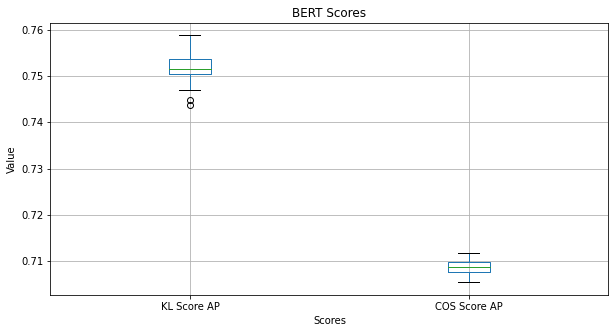

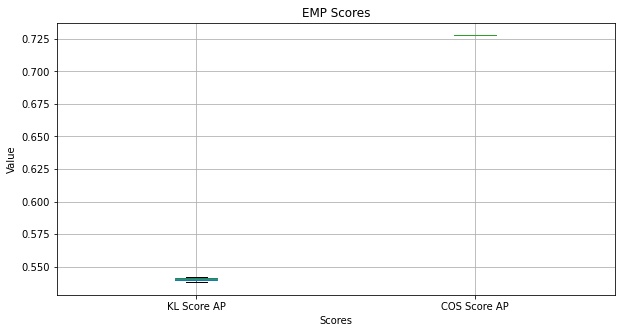

In [231]:
import pickle5 as pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize an empty dataframe to store the merged data
df = pd.DataFrame()

# Loop through the pickled files and merge them
for j in tqdm(range(1,6)):
    for i in range(5,26,5):
        with open(f'../data_shared/fixed/df_AP{i}_Falsenum{j}.pickle', 'rb') as f:
            df1 = pickle.load(f)
        df = pd.concat([df, df1])

# Split the dataframe into separate dataframes for BERT and EMP scores
df_bert = df[df['Max Context'].str.contains("BERT")]
df_emp = df[df['Max Context'].str.contains("EMP")]

# Create a boxplot for the BERT scores
plt.figure(figsize=(10,5))
df_bert.boxplot(column=['KL Score AP', 'COS Score AP'])
plt.title("BERT Scores")
plt.xlabel("Scores")
plt.ylabel("Value")
plt.show()

# Create a boxplot for the EMP scores
plt.figure(figsize=(10,5))
df_emp.boxplot(column=['KL Score AP', 'COS Score AP'])
plt.title("EMP Scores")
plt.xlabel("Scores")
plt.ylabel("Value")
plt.show()





100%|██████████| 5/5 [00:00<00:00, 66.97it/s]


Text(0, 0.5, 'Score')

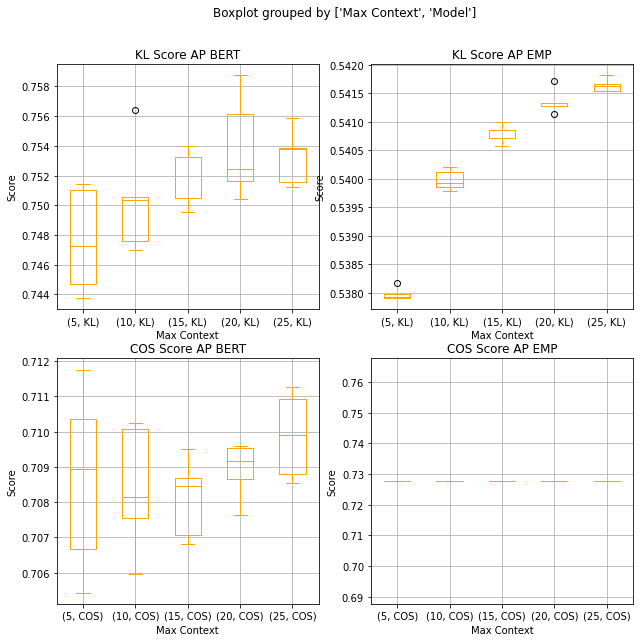

In [253]:
import pickle5 as pickle 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize an empty dataframe to store the merged data
df = pd.DataFrame()

# Loop through the pickled files and merge them
for j in tqdm(range(1,6)):
    for i in range(5,26,5):
        with open(f'../data_shared/fixed/df_AP{i}_Falsenum{j}.pickle', 'rb') as f:
            df1 = pickle.load(f)
        df = pd.concat([df, df1])

# Split the dataframe into separate dataframes for BERT and EMP scores
df_bert = df[df['Max Context'].str.contains("BERT")]
df_emp = df[df['Max Context'].str.contains("EMP")]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# KL Score AP BERT
df_kl_bert = df_bert.melt(id_vars='Max Context', value_vars=['KL Score AP'], value_name='Score')
df_kl_bert['Model'] = df_kl_bert['variable'].apply(lambda x: x.split()[0])
df_kl_bert['Max Context'] = df_kl_bert['Max Context'].apply(lambda x: int(x.split("BERT")[1]))

df_kl_bert.boxplot(by=['Max Context', 'Model'], ax=axes[0, 0], color='orange')
axes[0, 0].set_title('KL Score AP BERT')
axes[0, 0].set_xlabel('Max Context')
axes[0, 0].set_ylabel('Score')

# KL Score AP EMP
df_kl_emp = df_emp.melt(id_vars='Max Context', value_vars=['KL Score AP'], value_name='Score')
df_kl_emp['Model'] = df_kl_emp['variable'].apply(lambda x: x.split()[0])
df_kl_emp['Max Context'] = df_kl_emp['Max Context'].apply(lambda x: int(x.split("EMP")[1]))

df_kl_emp.boxplot(by=['Max Context', 'Model'], ax=axes[0, 1], color='orange')
axes[0, 1].set_title('KL Score AP EMP')
axes[0, 1].set_xlabel('Max Context')
axes[0, 1].set_ylabel('Score')

# COS Score AP BERT
df_cos_bert = df_bert.melt(id_vars='Max Context', value_vars=['COS Score AP'], value_name='Score')
df_cos_bert['Model'] = df_cos_bert['variable'].apply(lambda x: x.split()[0])
df_cos_bert['Max Context'] = df_cos_bert['Max Context'].apply(lambda x: int(x.split("BERT")[1]))

df_cos_bert.boxplot(by=['Max Context', 'Model'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('COS Score AP BERT')
axes[1, 0].set_xlabel('Max Context')
axes[1, 0].set_ylabel('Score')

# COS Score AP EMP
df_cos_emp = df_emp.melt(id_vars='Max Context', value_vars=['COS Score AP'], value_name='Score')
df_cos_emp['Model'] = df_cos_emp['variable'].apply(lambda x: x.split()[0])
df_cos_emp['Max Context'] = df_cos_emp['Max Context'].apply(lambda x: int(x.split("EMP")[1]))


df_cos_emp.boxplot(by=['Max Context', 'Model'], ax=axes[1, 1], color='orange')
axes[1, 1].set_title('COS Score AP EMP')
axes[1, 1].set_xlabel('Max Context')
axes[1, 1].set_ylabel('Score')


In [201]:
with open(f'../data_shared/fixed/df_AP5_Falsenum1.pickle', 'rb') as f:
    df1 = pickle.load(f)

df1

,Max Context,KL Score AP,COS Score AP
0,BERT5,0.743755,0.705431
1,EMP5,0.538172,0.727667


In [185]:
for i in range(0,26,5):
    print(i)
    

0
5
10
15
20
25


In [183]:
with open('../data_shared/fixed/ramdom_curated0-25/curated5num1.pickle', 'rb') as f:
    df_AP1_True = pickle.load(f)
    
df_AP1_True


['world war ii although many squadrons were raised at raaf station laverton during world war ii the base s prime focus continued to be its aircraft depot',
 'minidoux and hard tits from the album smash were used in the adult swim super violence disclaimer and actn water tanks bumpers respectively',
 'in the name of the locality was officially gazetted as hūkerenui',
 'throughout the frets magazine readers chose phillips in five readers poll awards for best jazz and best bluegrass bassist',
 'his show ruuddewild',
 'it landed three times in deloitte’s technology fast central europe ranking and twice on the ft ” the financial times’ list of fastest growing companies in europe',
 'this building burned to the ground in the and was replaced with a stone courthouse',
 'the work of sociologist erving goffman laid the theoretical foundation for ways to study the construction of everyday social meanings and behavioral norms especially by breaking unstated but universally accepted rules',
 'it i

In [101]:
tok = Tokenizer()
tok.words(df_AP1_True)

[['References',
  'External',
  'links',
  'Category:1994',
  'births',
  'Category:Living',
  'people',
  'Category:Sri',
  'Lankan',
  'cricketers',
  'Category:Kurunegala',
  'Youth',
  'Cricket',
  'Club',
  'cricketers',
  'Category:Sri',
  'Lanka',
  'Army',
  'Sports',
  'Club',
  'cricketers',
  'Category:Sportspeople',
  'from',
  'Kurunegala'],
 ['Members',
  'of',
  'the',
  'commission',
  'and',
  'the',
  'county',
  'mayor',
  'are',
  'elected',
  'to',
  'four',
  'year',
  'terms'],
 ['In',
  'fact,',
  'after',
  'Return',
  'of',
  'the',
  'Jedi,',
  'I',
  "didn't",
  'have',
  'a',
  'burning',
  'desire',
  'to',
  'return',
  'to',
  'this',
  'galaxy',
  "'far,",
  'far',
  "away',",
  'but,',
  'with',
  'The',
  'Phantom',
  'Menace,',
  'Lucas',
  'has',
  'revived',
  'my',
  'interest'],
 ['He',
  'ends',
  'up',
  'confronting',
  'his',
  'Shadow',
  'who',
  'represents',
  'his',
  'resentment',
  'of',
  'living',
  'in',
  'a',
  'small',
  'country

In [103]:
for i in tqdm(range(1,21,5)):
    print(i)

100%|██████████| 4/4 [00:00<00:00, 4540.52it/s]

1
6
11
16


In [110]:
text_preprocessing(df_AP1_True[1])

'members of the commission and the county mayor are elected to four year terms'

In [108]:
import re
import numpy as np  
from tqdm import tqdm
def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, " ")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
#     text = text.split(' ')

    # Droping empty strings
#     text = [x for x in text if x!='']

    # Droping stop words
#     text = [x for x in text if x not in stop_words]

    return text

In [67]:
frames = [df_AP700_random_True, df_AP600_random_True, df_AP500_random_True, df_AP400_random_True, df_AP300_random_True, df_AP200_random_True, df_AP100_random_True]
frames = [df_AP700_random_False, df_AP600_random_False, df_AP500_random_False, df_AP400_random_False, df_AP300_random_False, df_AP200_random_False, df_AP100_random_False]
result = pd.concat(reversed(frames))
result

,Max Context,KL Score AP,COS Score AP
0,BERT100,0.763744,0.712988
1,EMP100,0.542697,0.727667
0,BERT200,0.763760,0.712988
1,EMP200,0.542695,0.727667
0,BERT300,0.763761,0.712988
1,EMP300,0.542694,0.727667
0,BERT400,0.763764,0.712988
1,EMP400,0.542692,0.727667
0,BERT500,0.763761,0.712988
1,EMP500,0.542692,0.727667


In [66]:
df_AP700_random_False

,Max Context,KL Score AP,COS Score AP
0,BERT700,0.763728,0.712988
1,EMP700,0.542692,0.727667


In [74]:
with open('../data_shared/df_curated100_diag_False.pickle', 'rb') as f:
    df_curated100_diag_False = pickle.load(f)

with open('../data_shared/df_curated100_diag_True.pickle', 'rb') as f:
    df_curated100_diag_True = pickle.load(f)
    
with open('../data_shared/df_curated200_diag_False.pickle', 'rb') as f:
    df_curated200_diag_False = pickle.load(f)

with open('../data_shared/df_curated200_diag_True.pickle', 'rb') as f:
    df_curated200_diag_True = pickle.load(f)

In [76]:
df_curated100_diag_True.compare(df_curated200_diag_True)


bert KL score               bert COS score                  \
              self        other            self           other   
0       481.604614   481.604492             NaN             NaN   
1       505.810303   505.810425  tensor(0.7130)  tensor(0.7130)   
2       361.076416   361.076294  tensor(0.8394)  tensor(0.8394)   
3       570.493286   570.492981  tensor(0.7287)  tensor(0.7287)   
4       696.685730   696.685791  tensor(0.5654)  tensor(0.5654)   
...            ...          ...             ...             ...   
2765   1581.278564  1581.279175  tensor(0.6537)  tensor(0.6537)   
2766    476.659668   476.658936             NaN             NaN   
2767   1020.010010  1020.010620             NaN             NaN   
2768    496.043884   496.043640  tensor(0.6218)  tensor(0.6218)   
2769   1040.529297  1040.529175             NaN             NaN   

     empirical KL score              
                   self       other  
0              0.860031    0.860001  
1              0.491299    0.491291  
2              2.680397    2.680443  
3              4.122570    4.122612  
4              1.545025    1.545029  
...                 ...         ...  
2765         116.322227  116.323227  
2766         135.241302  135.237289  
2767           9.908092    9.908138  
2768          98.863403   98.862045  
2769           0.273491    0.273499  

[2760 rows x 6 columns]

In [49]:
def import_baroni(neg_file, pos_file):
    results_neg_file, results_pos_file = [], []
    with open(neg_file) as f:
        for line in f:
            results_neg_file.append(line.replace("-n", "").replace("\n", "").strip("").split("\t"))
    with open(pos_file) as f:
        for line in f:
            results_pos_file.append(line.replace("-n", "").replace("\n", "").strip("").split("\t"))
    baroni = sum(results_neg_file, []) + sum(results_pos_file, [])
    print(baroni)
    baroni_set = set(baroni)

    return results_neg_file, results_pos_file, baroni, baroni_set

In [50]:
neg_file = "../data_shared/eacl2012-data/negative-examples.txtinput"
pos_file = "../data_shared/eacl2012-data/positive-examples.txtinput"
results_neg_file, results_pos_file, baroni, baroni_set = import_baroni(neg_file, pos_file)

['adjective', 'document', 'adrenaline', 'integer', 'adult', 'anaesthetist', 'adult', 'gent', 'adult', 'instrument', 'adult', 'librarian', 'adult', 'nanny', 'adult', 'physician', 'adult', 'tree', 'advocate', 'spokeswoman', 'affection', 'organization', 'agony', 'adult', 'agony', 'anaesthetist', 'agony', 'decoration', 'agreement', 'rector', 'aircraft', 'astronomy', 'aircraft', 'biplane', 'aircraft', 'bomber', 'aircraft', 'insect', 'aircraft', 'letter', 'aircrew', 'playlist', 'airman', 'sociology', 'airplane', 'bomber', 'airplane', 'chalet', 'alcohol', 'container', 'alcohol', 'hotel', 'alcohol', 'liqueur', 'alcohol', 'psychology', 'alga', 'garment', 'algebra', 'athlete', 'algebra', 'potato', 'alloy', 'bronze', 'ancestor', 'motto', 'anger', 'lizard', 'animal', 'affidavit', 'animal', 'artillery', 'animal', 'bitterness', 'animal', 'bug', 'animal', 'bull', 'animal', 'calf', 'animal', 'cameraman', 'animal', 'chick', 'animal', 'color', 'animal', 'crow', 'animal', 'diabetes', 'animal', 'dorm', 'a

In [51]:
results_neg_file

[['adjective', 'document'],
 ['adrenaline', 'integer'],
 ['adult', 'anaesthetist'],
 ['adult', 'gent'],
 ['adult', 'instrument'],
 ['adult', 'librarian'],
 ['adult', 'nanny'],
 ['adult', 'physician'],
 ['adult', 'tree'],
 ['advocate', 'spokeswoman'],
 ['affection', 'organization'],
 ['agony', 'adult'],
 ['agony', 'anaesthetist'],
 ['agony', 'decoration'],
 ['agreement', 'rector'],
 ['aircraft', 'astronomy'],
 ['aircraft', 'biplane'],
 ['aircraft', 'bomber'],
 ['aircraft', 'insect'],
 ['aircraft', 'letter'],
 ['aircrew', 'playlist'],
 ['airman', 'sociology'],
 ['airplane', 'bomber'],
 ['airplane', 'chalet'],
 ['alcohol', 'container'],
 ['alcohol', 'hotel'],
 ['alcohol', 'liqueur'],
 ['alcohol', 'psychology'],
 ['alga', 'garment'],
 ['algebra', 'athlete'],
 ['algebra', 'potato'],
 ['alloy', 'bronze'],
 ['ancestor', 'motto'],
 ['anger', 'lizard'],
 ['animal', 'affidavit'],
 ['animal', 'artillery'],
 ['animal', 'bitterness'],
 ['animal', 'bug'],
 ['animal', 'bull'],
 ['animal', 'calf'],
 [

In [42]:
df_curated10_True

,Wordpair,True label,bert KL score,bert COS score,empirical KL score,empirical COS score
0,"[abstraction, concept]",1,543.199585,tensor(0.7519),0.861984,0.469579
1,"[accusation, statement]",1,655.894958,tensor(0.6887),0.497814,0.614132
2,"[ache, pain]",1,481.972351,tensor(0.8344),2.674484,0.792009
3,"[acid, chemical]",1,654.676636,tensor(0.7228),4.105728,0.668829
4,"[acoustics, discipline]",1,1073.539673,tensor(0.5213),1.551239,0.216910
...,...,...,...,...,...,...
2765,"[writer, dramatist]",0,2922.197266,tensor(0.6249),116.870781,0.694186
2766,"[writer, poet]",0,749.144287,tensor(0.8043),135.247009,0.798863
2767,"[yellow, protein]",0,1219.188354,tensor(0.5060),9.886383,0.333175
2768,"[yesterday, discipline]",0,913.976318,tensor(0.5464),98.800735,-0.018511


In [43]:
df_curated10_False

,Wordpair,True label,bert KL score,bert COS score,empirical KL score,empirical COS score
0,"[abstraction, concept]",1,543.199585,tensor(0.7519),0.861984,0.469579
1,"[accusation, statement]",1,655.894958,tensor(0.6887),0.497814,0.614132
2,"[ache, pain]",1,481.972351,tensor(0.8344),2.674484,0.792009
3,"[acid, chemical]",1,654.676636,tensor(0.7228),4.105728,0.668829
4,"[acoustics, discipline]",1,1073.539673,tensor(0.5213),1.551239,0.216910
...,...,...,...,...,...,...
2765,"[writer, dramatist]",0,2922.197266,tensor(0.6249),116.870781,0.694186
2766,"[writer, poet]",0,749.144287,tensor(0.8043),135.247009,0.798863
2767,"[yellow, protein]",0,1219.188354,tensor(0.5060),9.886383,0.333175
2768,"[yesterday, discipline]",0,913.976318,tensor(0.5464),98.800735,-0.018511


In [9]:
def calculate_kl_bert(wordpair, embavg, is_diagonal, vocab):
    # Get the mean vectors and covariance matrices for the two words in the word pair
    mean1, covariance_matrix1 = embavg.get_mean_covariance(vocab[0]) 
    mean2, covariance_matrix2 = embavg.get_mean_covariance(vocab[1])
    
    # Create PyTorch multivariate normal distributions using the mean vectors and covariance matrices
    if is_diagonal:
        p = torch.distributions.multivariate_normal.MultivariateNormal(mean1, covariance_matrix=torch.diagflat(torch.diag(covariance_matrix1)))
        q = torch.distributions.multivariate_normal.MultivariateNormal(mean2, covariance_matrix=torch.diagflat(torch.diag(covariance_matrix2)))
    else:
        p = torch.distributions.multivariate_normal.MultivariateNormal(mean1, covariance_matrix=covariance_matrix1)
        q = torch.distributions.multivariate_normal.MultivariateNormal(mean2, covariance_matrix=covariance_matrix2)

    # Calculate the KL divergence between the two distributions
    kl = torch.distributions.kl.kl_divergence(p, q)

    return kl.item()

# def calculate_kl_bert(wordpair, embavg, is_diagonal, vocab):
#     # Get the mean vectors and covariance matrices for the two words in the word pair
#     mean1, covariance_matrix1 = embavg.get_mean_covariance(vocab[0]) 
#     mean2, covariance_matrix2 = embavg.get_mean_covariance(vocab[1])
    
   
#     # Create PyTorch multivariate normal distributions using the mean vectors and covariance matrices
#     if is_diagonal:
#         p = torch.distributions.multivariate_normal.MultivariateNormal(mean1, torch.eye(768, 768)) # covariance_matrix=torch.diagflat(torch.diag(covariance_matrix1))
#         q = torch.distributions.multivariate_normal.MultivariateNormal(mean2, torch.eye(768, 768)) # covariance_matrix=torch.diagflat(torch.diag(covariance_matrix2)))
#     else:
#         p = torch.distributions.multivariate_normal.MultivariateNormal(mean1, covariance_matrix=covariance_matrix1)
#         q = torch.distributions.multivariate_normal.MultivariateNormal(mean2, covariance_matrix=covariance_matrix2)

#     # Calculate the KL divergence between the two distributions
#     kl = torch.distributions.kl.kl_divergence(p, q)

#     return kl.item()

In [10]:
is_diagonal = False
vocab = (4, 5)
wordpair = "somethin"

calculate_kl_bert(wordpair, embavg, is_diagonal, vocab)

44830.51171875

In [11]:
is_diagonal = True
vocab = (4, 5)
wordpair = "somethin"

calculate_kl_bert(wordpair, embavg, is_diagonal, vocab)

796.48388671875

## pipeline


In [7]:
neg_file = "../Data_Shared/eacl2012-data/negative-examples.txtinput"
pos_file = "../Data_Shared/eacl2012-data/positive-examples.txtinput"
results_neg_file, results_pos_file, baroni, baroni_set = import_baroni(neg_file, pos_file)


In [16]:
import ast
import nltk

with open('../Data_shared/wiki_subset.txt') as f:
    data = f.read()
baroni_set = {'fallacy', 'subcontractor', 'declaration', 'colt', 'cabbage'}
wikidata = ast.literal_eval(data)
wikidata = wikidata["text"]   
max_length = 40

wikidata = [sentence[:max_length].strip() if len(sentence.split()) > max_length else sentence.strip()
        for seq in tqdm(wikidata)
        for sentence in seq.split(".")]


100%|██████████| 10000/10000 [00:00<00:00, 19044.61it/s]


'It is best known in China for creating nianhua or Yangliuqing nianhua'

In [72]:
import random
collected_sentences = []
sentence_counter = {word: int(0) for word in baroni_set}
# Shuffle the order of the sentences in wikidata
random.shuffle(wikidata)

# Iterate through the shuffled list of sentences
for sentence in wikidata:
    
    words = sentence.split()
    for word in words:
        if word in baroni_set and sentence_counter[word] < max_length:
            
                collected_sentences.append(sentence)
                sentence_counter[word] += 1

In [73]:
sentence_counter

{'fallacy': 6, 'subcontractor': 3, 'declaration': 40, 'colt': 4, 'cabbage': 1}

In [19]:
import random

# Shuffle the order of the sentences in wikidata
random.shuffle(wikidata)

# Iterate through the shuffled list of sentences
for sentence in wikidata:
    # Split the sentence into words
    words = sentence.split()
    
    # Check if any of the words are in the baroni set
    for word in words:
        
        if word in baroni_set:
            # Add the sentence to the collected sentences for this word
            collected_sentences[word].append(sentence)


In [20]:
collected_sentences

{'fallacy': ['Other authors describe the fallacy as the act of dismissing an argument "with the wave of a hand"',
  'Scholars generally characterize the fallacy as a rhetorical device in which the speaker ridicules an argument without responding to the substance of the argument',
  'This fallacy stemmed from the apocryphal origin story of a folk song known as "Son de Má Teodora"',
  'Some sources also suggest the fallacy is an expression that involves "sneer[ing]", "ridicule", or "malicious comments about the proponent of the argument"',
  'Definition\nAuthors have characterized the fallacy as a form of a straw man fallacy, where an argument is described as inherently worthless or undeserving of serious attention',
  'A pooh-pooh (also styled as poo-poo) is a fallacy in informal logic that consists of dismissing an argument as being unworthy of serious consideration',
  'This fallacy stemmed from the apocryphal origin story of a folk song known as "Son de Má Teodora"',
  'Scholars gene

I want to make a counter that iterates through all words in wikidata semi random. If the word is in the set of words used in baroni, add the scentence to the new collection of scentences until you have gathered an x amount of scnetences per word in the set of baroni words. the scentences also have to be shorter than 40 words. 

In [27]:
import torch
a = torch.randn(3, 3)
a = torch.diagonal(a)
torch.diag_embed(a)

tensor([[0.8951, 0.0000, 0.0000],
        [0.0000, 0.1971, 0.0000],
        [0.0000, 0.0000, 1.0366]])

In [70]:
def diag_cosine_similarity(a, b):
    a = torch.diag(a)
    b = torch.diag(b)
    nominator = torch.dot(a, b)
    
    a_norm = torch.sqrt(torch.sum(a**2))
    b_norm = torch.sqrt(torch.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity


def cosine_similarity(a, b):
    nominator = torch.dot(a, b)
    
    a_norm = torch.sqrt(torch.sum(a**2))
    b_norm = torch.sqrt(torch.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [71]:
a = torch.randn(3, 3)
b = torch.randn(3, 3)

print(diag_cosine_similarity(a, b))
# print(cosine_similarity(a, b))


tensor(-0.4016)


In [14]:
total_words = sum(len(article.split()) for article in wikidata)
batch_size = 512
# Calculate the number of batches needed to process all the words,
# given the batch size specified in the batch_size variable
n_batches = 1 + (total_words // batch_size)

# Initialize an empty list to store the processed batches
batches = []


# Initialize a counter to keep track of the current position in the data
current_pos = 0

# Iterate over the number of batches
for k in range(n_batches):
    # Calculate the end position for the current batch
    end_pos = current_pos + batch_size

    # Select a batch of words from the data using slicing
    batch = " ".join(article[current_pos:end_pos] for article in wikidata)

    # Add the batch to the list of batches
    batches.append(batch)

    # Update the current position
    current_pos = end_pos

# Process the batches using the desired method
for batch in batches:
    print(len(batch))
    # Process the batch here

KeyboardInterrupt: 

In [210]:
for i in tok.words(wikidata):
    if len(i) > 100:
        print(i)

['Honours', 'Leotar', 'Premier', 'League', 'of', 'Bosnia', 'and', 'Herzegovina:', '2002–03', 'Red', 'Star', 'Belgrade', 'First', 'League', 'of', 'Serbia', 'and', 'Montenegro:', '2003–04', 'Serbia', 'and', 'Montenegro', 'Cup:', '2003–04', 'References', 'External', 'links', 'Category:Association', 'football', 'forwards', 'Category:Azerbaijan', 'Premier', 'League', 'players', 'Category:Belgian', 'First', 'Division', 'A', 'players', 'Category:Expatriate', 'footballers', 'in', 'Azerbaijan', 'Category:Expatriate', 'footballers', 'in', 'Belgium', 'Category:Expatriate', 'footballers', 'in', 'Bosnia', 'and', 'Herzegovina', 'Category:Expatriate', 'footballers', 'in', 'Montenegro', 'Category:Expatriate', 'footballers', 'in', 'Russia', 'Category:FC', 'Luch', 'Vladivostok', 'players', 'Category:First', 'League', 'of', 'Serbia', 'and', 'Montenegro', 'players', 'Category:FK', 'Javor', 'Ivanjica', 'players', 'Category:FK', 'Jedinstvo', 'Ub', 'players', 'Category:FK', 'Leotar', 'players', 'Category:FK'

In [203]:
for i in wikidata:
    if len(i.split()) > 198:
        print(len(i.split()))

199
199


In [82]:
embavg = torch.load('../data_distrembed/first100000.avgs.pt')

In [85]:
print(len(vocab._tok_counts))
# print(vocab._tok_counts)
for key, item in vocab._tok_counts.items():
    if key not in baroni:
        print(key, item)

670


### dataframe

In [86]:


baroni_pos_subset = [x for x in results_pos_file if x[0] in vocab._tok_counts and x[1] in vocab._tok_counts]
baroni_neg_subset = [x for x in results_neg_file if x[0] in vocab._tok_counts and x[1] in vocab._tok_counts]



In [87]:

# baroni_pos_subset, baroni_neg_subset = create_combined_subset(word_cov_matrices, results_neg_file, results_pos_file, combined_set)

baroni_subset_label = []

for i in baroni_pos_subset:
    baroni_subset_label.append([i, 1])

for i in baroni_neg_subset:
    baroni_subset_label.append([i, 0])

# MAKE DATAFRAME
df1 = pd.DataFrame(baroni_subset_label, columns =['Wordpair', 'True label'])
print(df1)

                 Wordpair  True label
0        [acid, chemical]           1
1    [affection, feeling]           1
2     [aircraft, vehicle]           1
3         [alpha, symbol]           1
4        [antiquity, era]           1
..                    ...         ...
732     [woman, mistress]           0
733         [wood, maple]           0
734          [work, bird]           0
735   [writer, dramatist]           0
736        [writer, poet]           0

[737 rows x 2 columns]


In [89]:
baroni_subset_cos = []

for wordpair in (baroni_pos_subset + baroni_neg_subset):
    A = embavg._sum[vocab._tok_to_id.get(wordpair[0])]
    B = embavg._sum[vocab._tok_to_id.get(wordpair[1])]
    baroni_subset_cos.append(torch.cosine_similarity(A, B))
    
    

### calculate KL and COS

In [94]:

# CALCULATE KL and COS
baroni_subset_kl = []
baroni_subset_cos = []

for wordpair in tqdm((baroni_pos_subset + baroni_neg_subset)):
    baroni_subset_kl.append(calculate_kl(wordpair))
    baroni_subset_cos.append(cosine_similarity(embavg._sum[vocab._tok_to_id.get(wordpair[0])], 
                                               embavg._sum[vocab._tok_to_id.get(wordpair[1])]))

df1['KL score'] = baroni_subset_kl
df1['COS score'] = baroni_subset_cos

# with open('df1.pickle', 'wb') as handle:
#     pickle.dump(df1, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(df1)
print("COS AP: ", average_precision_score(df1["True label"], df1["COS score"]))
print("KL AP: ", average_precision_score(df1["True label"], -df1["KL score"]))

100%|██████████| 737/737 [01:02<00:00, 11.71it/s]

                 Wordpair  True label      KL score       COS score
0        [acid, chemical]           1  22588.404297  tensor(0.7882)
1    [affection, feeling]           1  24089.642578  tensor(0.7085)
2     [aircraft, vehicle]           1  22337.914062  tensor(0.7861)
3         [alpha, symbol]           1  47081.132812  tensor(0.6093)
4        [antiquity, era]           1  34338.492188  tensor(0.6267)
..                    ...         ...           ...             ...
732     [woman, mistress]           0  33531.156250  tensor(0.6877)
733         [wood, maple]           0  25387.968750  tensor(0.7393)
734          [work, bird]           0  37608.054688  tensor(0.6506)
735   [writer, dramatist]           0  50024.500000  tensor(0.6341)
736        [writer, poet]           0  19814.851562  tensor(0.8291)

[737 rows x 4 columns]
COS AP:  0.6932439050975777
KL AP:  0.6869634675826695


In [16]:
words = [['Yangliuqing', '()', 'is', 'a', 'market', 'town', 'in', 'Xiqing', 'District,', 'in', 'the', 'western', 'suburbs', 'of', 'Tianjin,', "People's", 'Republic', 'of', 'China'], ['Despite', 'its', 'relatively', 'small', 'size,', 'it', 'has', 'been', 'named', 'since', '2006', 'in', 'the', '"famous', 'historical', 'and', 'cultural', 'market', 'towns', 'in', 'China"'], ['It', 'is', 'best', 'known', 'in', 'China', 'for', 'creating', 'nianhua', 'or', 'Yangliuqing', 'nianhua'], ['For', 'more', 'than', '400', 'years,', 'Yangliuqing', 'has', 'in', 'effect', 'specialised', 'in', 'the', 'creation', 'of', 'these', 'woodcuts', 'for', 'the', 'New', 'Year'], ['wood', 'block', 'prints', 'using', 'vivid', 'colourschemes', 'to', 'portray', 'traditional', 'scenes', 'of', "children's", 'games', 'often', 'interwoven', 'with', 'auspiciouse', 'objects'], [',', 'it', 'had', '27', 'residential', 'communities', '()', 'and', '25', 'villages', 'under', 'its', 'administration'], ['Shi', 'Family', 'Grand', 'Courtyard', 'Shi', 'Family', 'Grand', 'Courtyard', '(Tiānjīn', 'Shí', 'Jiā', 'Dà', 'Yuàn,', '天津石家大院)', 'is', 'situated', 'in', 'Yangliuqing', 'Town', 'of', 'Xiqing', 'District,', 'which', 'is', 'the', 'former', 'residence', 'of', 'wealthy', 'merchant', 'Shi', 'Yuanshi', '-', 'the', '4th', 'son', 'of', 'Shi', 'Wancheng,', 'one', 'of', 'the', 'eight', 'great', 'masters', 'in', 'Tianjin'], ['First', 'built', 'in', '1875,', 'it', 'covers', 'over', '6,000', 'square', 'meters,', 'including', 'large', 'and', 'small', 'yards', 'and', 'over', '200', 'folk', 'houses,', 'a', 'theater', 'and', 'over', '275', 'rooms', 'that', 'served', 'as', 'apartments', 'and', 'places', 'of', 'business', 'and', 'worship', 'for', 'this', 'powerful', 'family'], ['Shifu', 'Garden,', 'which', 'finished', 'its', 'expansion', 'in', 'October', '2003,', 'covers', '1,200', 'square', 'meters,', 'incorporates', 'the', 'elegance', 'of', 'imperial', 'garden', 'and', 'delicacy', 'of', 'south', 'garden'], ['Now', 'the', 'courtyard', 'of', 'Shi', 'family', 'covers', 'about', '10,000', 'square', 'meters,', 'which', 'is', 'called', 'the', 'first', 'mansion', 'in', 'North', 'China'], ['Now', 'it', 'serves', 'as', 'the', 'folk', 'custom', 'museum', 'in', 'Yangliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'custom', 'museum', 'in', 'Yanliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'art', 'pieces', 'like', 'Yanliuqing', 'New', 'Year', 'pictures,', 'brick', 'sculpture'], ["Shi's", 'ancestor', 'came', 'from', "Dong'e", 'County', 'in', 'Shandong', 'Province,', 'engaged', 'in', 'water', 'transport', 'of', 'grain'], ['As', 'the', 'wealth', 'gradually', 'accumulated,', 'the', 'Shi', 'Family', 'moved', 'to', 'Yangliuqing', 'and', 'bought', 'large', 'tracts', 'of', 'land', 'and', 'set', 'up', 'their', 'residence'], ['Shi', 'Yuanshi', 'came', 'from', 'the', 'fourth', 'generation', 'of', 'the', 'family,', 'who', 'was', 'a', 'successful', 'businessman', 'and', 'a', 'good', 'household', 'manager,', 'and', 'the', 'residence', 'was', 'thus', 'enlarged', 'for', 'several', 'times', 'until', 'it', 'acquired', 'the', 'present', 'scale'], ['It', 'is', 'believed', 'to', 'be', 'the', 'first', 'mansion', 'in', 'the', 'west', 'of', 'Tianjin'], ['The', 'residence', 'is', 'symmetric', 'based', 'on', 'the', 'axis', 'formed', 'by', 'a', 'passageway', 'in', 'the', 'middle,', 'on', 'which', 'there', 'are', 'four', 'archways'], ['On', 'the', 'east', 'side', 'of', 'the', 'courtyard,', 'there', 'are', 'traditional', 'single-story', 'houses', 'with', 'rows', 'of', 'rooms', 'around', 'the', 'four', 'sides,', 'which', 'was', 'once', 'the', 'living', 'area', 'for', 'the', 'Shi', 'Family'], ['The', 'rooms', 'on', 'north', 'side', 'were', 'the', "accountants'", 'office'], ['On', 'the', 'west', 'are', 'the', 'major', 'constructions', 'including', 'the', 'family', 'hall', 'for', 'worshipping', 'Buddha,', 'theater', 'and', 'the', 'south', 'reception', 'room'], ['On', 'both', 'sides', 'of', 'the', 'residence', 'are', 'side', 'yard', 'rooms', 'for', 'maids', 'and', 'servants'], ['Today,', 'the', 'Shi', 'mansion,', 'located', 'in', 'the', 'township', 'of', 'Yangliuqing', 'to', 'the', 'west', 'of', 'central', 'Tianjin,', 'stands', 'as', 'a', 'surprisingly', 'well-preserved', 'monument', 'to', "China's", 'pre-revolution', 'mercantile', 'spirit'], ['It', 'also', 'serves', 'as', 'an', 'on-location', 'shoot', 'for', 'many', 'of', "China's", 'popular', 'historical', 'dramas'], ['Many', 'of', 'the', 'rooms', 'feature', 'period', 'furniture,', 'paintings', 'and', 'calligraphy,', 'and', 'the', 'extensive', 'Shifu', 'Garden'], ['Part', 'of', 'the', 'complex', 'has', 'been', 'turned', 'into', 'the', 'Yangliuqing', 'Museum,', 'which', 'includes', 'displays', 'focused', 'on', 'symbolic', 'aspects', 'of', 'the', "courtyards'", 'construction,', 'local', 'folk', 'art', 'and', 'customs,', 'and', 'traditional', 'period', 'furnishings', 'and', 'crafts'], ['See', 'also', 'List', 'of', 'township-level', 'divisions', 'of', 'Tianjin', 'References', 'http://arts'], ['cultural-china'], ['com/en/65Arts4795'], ['html', 'Category:Towns', 'in', 'Tianjin'], ['Orana', 'Australia', 'Ltd', 'is', 'a', 'not-for-profit', 'organisation', 'that', 'provides', 'a', 'diverse', 'range', 'of', 'training', 'and', 'support', 'services', 'to', 'over', '650', 'people', 'with', 'disabilities', 'and', 'their', 'families', 'in', 'South', 'Australia'], ['History', 'The', 'Mentally', 'Retarded', 'Children’s', 'Society', 'of', 'SA', 'Inc'], ['was', 'established', 'in', '1950', 'by', 'a', 'group', 'of', 'parents', 'who', 'wanted', 'education,', 'employment', 'and', 'accommodation', 'opportunities', 'for', 'their', 'children', 'within', 'the', 'local', 'community', 'at', 'a', 'time', 'when', 'institutionalised', 'care', 'in', 'Adelaide', 'was', 'their', 'only', 'alternative'], ['The', 'society’s', 'aims', 'were', 'to', 'seek', 'education', 'or', 'training', 'facilities', 'for', 'people', 'with', 'intellectual', 'disabilities,', 'to', 'establish', 'sheltered', 'workshops,', 'and', 'to', 'establish', 'residential', 'hostels'], ['A', 'number', 'of', 'sheltered', 'workshops', 'were', 'established,', 'and', 'in', '1980,', 'the', 'name', 'was', 'changed', 'to', 'the', 'Aboriginal', 'word', '"Orana",', 'which', 'means', '"Welcome"'], ['Today,', 'Orana', 'provides', 'assisted', 'employment,', 'assisted', 'accommodation', 'and', 'respite', 'services', 'to', 'people', 'with', 'intellectual', 'disabilities'], ["Orana's", 'current', 'and', 'previous', 'clients', 'include', 'Mitsubishi', 'Motors,', 'Clipsal,', 'RAA,', 'Elders', 'Limited,', 'and', 'Billycart', 'Kids'], ['Orana', 'was', 'one', 'of', 'the', 'first', 'disability', 'service', 'organisations', 'to', 'achieve', 'Quality', 'Accreditation'], ['The', 'services', 'and', 'products', 'they', 'offer', 'are:', 'Packaging', 'Assembly', 'Sewing', 'Collating', '&', 'Mailing', 'Furniture', '-', 'Retail', 'Furniture', '–', 'Manufacture', 'for', 'Commercial', 'Market', 'Worm', 'Farming', 'Work', 'Crews', 'Pet', '&', 'Grain', '–', 'Retail', 'In', '2018,', 'after', '65', 'years', 'of', 'bettering', 'people’s', 'lives,', 'Orana', 'identified', 'a', 'community', 'need', 'and', 'expanded', 'their', 'operations', 'into', 'the', 'aged', 'care', 'sector'], ['After', 'the', 'unveiling', 'of', 'the', 'Australian', 'Government’s', 'Commonwealth', 'Home', 'Support', 'Programme', '(CHSP)', 'and', 'seeing', 'it', 'as', 'a', 'natural', 'step', 'of', 'progression,', 'Orana', 'now', 'provides', 'quality', 'tailored', 'aged', 'care', 'at', 'home'], ['The', 'well-resourced', 'organization', 'delivers', 'help', 'across', 'a', 'range', 'of', 'areas,', 'helping', 'the', 'elderly', 'remain', 'where', 'they', 'want', 'to', 'be', '-', 'in', 'the', 'comfort', 'of', 'their', 'own', 'home', 'during', 'their', 'later', 'years'], ['Orana', 'continues', 'with', 'its', 'mission', 'to', 'support', 'people', 'remain', 'independent,', 'valued', 'and', 'productive', 'members', 'of', 'the', 'community'], ['References', 'External', 'links', 'Category:Disability', 'organisations', 'based', 'in', 'Australia', 'Category:Organisations', 'based', 'in', 'South', 'Australia'], ['The', 'St'], ["Mary's", 'Church', 'is', 'a', 'church', 'owned', 'by', 'the', 'Church', 'of', 'Denmark', 'in', 'Sønderborg,', 'Denmark', 'and', 'the', 'church', 'of', 'the', 'parish', 'with', 'the', 'same', 'name'], ['Thanks', 'to', 'its', 'location', 'on', 'a', 'hill,', 'the', 'church', 'building', 'is', 'very', 'iconic', 'for', 'the', 'city'], ['History', 'In', 'the', 'Middle', 'Ages', 'there', 'was', 'a', 'leper', 'colony', 'on', 'a', 'hill', 'just', 'outside', 'the', 'city'], ['It', 'was', 'named', 'after', 'Saint', 'George', 'and', 'around', '1300', 'the', 'chapel', 'of', 'this', 'leper', 'colony', 'stood', 'in', 'the', 'place', 'of', 'the', 'present', 'St'], ["Mary's", 'Church'], ['After', 'the', 'old', 'parish', 'church', 'of', 'the', 'city,', 'the', 'St'], ['Nicholas', 'Church,', 'was', 'demolished', 'around', '1530,', 'the', 'Saint-George', 'chapel', 'became', 'the', 'new', 'main', 'church'], ['Towards', 'the', 'end', 'of', 'the', '16th', 'century,', 'John', 'II,', 'Duke', 'of', 'Schleswig-Holstein-Sonderburg', 'commissioned', 'the', 'enlargement', 'of', 'the', 'building', 'in', 'order', 'to', 'make', 'it', 'suitable', 'for', 'the', 'function', 'of', 'the', 'parish', 'church', 'of', 'his', 'city']]

In [20]:
total = 0

for word in words:
    total += len(word)

In [21]:
print(total)

1004


In [23]:
words2 = [['Yangliuqing', '()', 'is', 'a', 'market', 'town', 'in', 'Xiqing', 'District,', 'in', 'the', 'western', 'suburbs', 'of', 'Tianjin,', "People's", 'Republic', 'of', 'China.', 'Despite', 'its', 'relatively', 'small', 'size,', 'it', 'has', 'been', 'named', 'since', '2006', 'in', 'the', '"famous', 'historical', 'and', 'cultural', 'market', 'towns', 'in', 'China".', 'It', 'is', 'best', 'known', 'in', 'China', 'for', 'creating', 'nianhua', 'or', 'Yangliuqing', 'nianhua.', 'For', 'more', 'than', '400', 'years,', 'Yangliuqing', 'has', 'in', 'effect', 'specialised', 'in', 'the', 'creation', 'of', 'these', 'woodcuts', 'for', 'the', 'New', 'Year.', 'wood', 'block', 'prints', 'using', 'vivid', 'colourschemes', 'to', 'portray', 'traditional', 'scenes', 'of', "children's", 'games', 'often', 'interwoven', 'with', 'auspiciouse', 'objects.', ',', 'it', 'had', '27', 'residential', 'communities', '()', 'and', '25', 'villages', 'under', 'its', 'administration.', 'Shi', 'Family', 'Grand', 'Courtyard', 'Shi', 'Family', 'Grand', 'Courtyard', '(Tiānjīn', 'Shí', 'Jiā', 'Dà', 'Yuàn,', '天津石家大院)', 'is', 'situated', 'in', 'Yangliuqing', 'Town', 'of', 'Xiqing', 'District,', 'which', 'is', 'the', 'former', 'residence', 'of', 'wealthy', 'merchant', 'Shi', 'Yuanshi', '-', 'the', '4th', 'son', 'of', 'Shi', 'Wancheng,', 'one', 'of', 'the', 'eight', 'great', 'masters', 'in', 'Tianjin.', 'First', 'built', 'in', '1875,', 'it', 'covers', 'over', '6,000', 'square', 'meters,', 'including', 'large', 'and', 'small', 'yards', 'and', 'over', '200', 'folk', 'houses,', 'a', 'theater', 'and', 'over', '275', 'rooms', 'that', 'served', 'as', 'apartments', 'and', 'places', 'of', 'business', 'and', 'worship', 'for', 'this', 'powerful', 'family.', 'Shifu', 'Garden,', 'which', 'finished', 'its', 'expansion', 'in', 'October', '2003,', 'covers', '1,200', 'square', 'meters,', 'incorporates', 'the', 'elegance', 'of', 'imperial', 'garden', 'and', 'delicacy', 'of', 'south', 'garden.', 'Now', 'the', 'courtyard', 'of', 'Shi', 'family', 'covers', 'about', '10,000', 'square', 'meters,', 'which', 'is', 'called', 'the', 'first', 'mansion', 'in', 'North', 'China.', 'Now', 'it', 'serves', 'as', 'the', 'folk', 'custom', 'museum', 'in', 'Yangliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'custom', 'museum', 'in', 'Yanliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'art', 'pieces', 'like', 'Yanliuqing', 'New', 'Year', 'pictures,', 'brick', 'sculpture.', "Shi's", 'ancestor', 'came', 'from', "Dong'e", 'County', 'in', 'Shandong', 'Province,', 'engaged', 'in', 'water', 'transport', 'of', 'grain.', 'As', 'the', 'wealth', 'gradually', 'accumulated,', 'the', 'Shi', 'Family', 'moved', 'to', 'Yangliuqing', 'and', 'bought', 'large', 'tracts', 'of', 'land', 'and', 'set', 'up', 'their', 'residence.', 'Shi', 'Yuanshi', 'came', 'from', 'the', 'fourth', 'generation', 'of', 'the', 'family,', 'who', 'was', 'a', 'successful', 'businessman', 'and', 'a', 'good', 'household', 'manager,', 'and', 'the', 'residence', 'was', 'thus', 'enlarged', 'for', 'several', 'times', 'until', 'it', 'acquired', 'the', 'present', 'scale.', 'It', 'is', 'believed', 'to', 'be', 'the', 'first', 'mansion', 'in', 'the', 'west', 'of', 'Tianjin.', 'The', 'residence', 'is', 'symmetric', 'based', 'on', 'the', 'axis', 'formed', 'by', 'a', 'passageway', 'in', 'the', 'middle,', 'on', 'which', 'there', 'are', 'four', 'archways.', 'On', 'the', 'east', 'side', 'of', 'the', 'courtyard,', 'there', 'are', 'traditional', 'single-story', 'houses', 'with', 'rows', 'of', 'rooms', 'around', 'the', 'four', 'sides,', 'which', 'was', 'once', 'the', 'living', 'area', 'for', 'the', 'Shi', 'Family.', 'The', 'rooms', 'on', 'north', 'side', 'were', 'the', "accountants'", 'office.', 'On', 'the', 'west', 'are', 'the', 'major', 'constructions', 'including', 'the', 'family', 'hall', 'for', 'worshipping', 'Buddha,', 'theater', 'and', 'the', 'south', 'reception', 'room.', 'On', 'both', 'sides', 'of', 'the', 'residence', 'are', 'side', 'yard', 'rooms', 'for', 'maids', 'and', 'servants.', 'Today,', 'the', 'Shi', 'mansion,', 'located', 'in', 'the', 'township', 'of', 'Yangliuqing', 'to', 'the', 'west', 'of', 'central', 'Tianjin,', 'stands', 'as', 'a', 'surprisingly', 'well-preserved', 'monument', 'to', "China's", 'pre-revolution', 'mercantile', 'spirit.', 'It', 'also', 'serves', 'as', 'an', 'on-location', 'shoot', 'for', 'many', 'of', "China's", 'popular', 'historical', 'dramas.', 'Many', 'of', 'the', 'rooms', 'feature', 'period', 'furniture,', 'paintings', 'and', 'calligraphy,', 'and', 'the', 'extensive', 'Shifu', 'Garden.', 'Part', 'of', 'the', 'complex', 'has', 'been', 'turned', 'into', 'the', 'Yangliuqing', 'Museum,', 'which', 'includes', 'displays', 'focused', 'on', 'symbolic', 'aspects', 'of', 'the', "courtyards'", 'construction,', 'local', 'folk', 'art', 'and', 'customs,', 'and', 'traditional', 'period', 'furnishings', 'and', 'crafts.', 'See', 'also', 'List', 'of', 'township-level', 'divisions', 'of', 'Tianjin', 'References', 'http://arts.cultural-china.com/en/65Arts4795.html', 'Category:Towns', 'in', 'Tianjin'], ['Orana', 'Australia', 'Ltd', 'is', 'a', 'not-for-profit', 'organisation', 'that', 'provides', 'a', 'diverse', 'range', 'of', 'training', 'and', 'support', 'services', 'to', 'over', '650', 'people', 'with', 'disabilities', 'and', 'their', 'families', 'in', 'South', 'Australia.', 'History', 'The', 'Mentally', 'Retarded', 'Children’s', 'Society', 'of', 'SA', 'Inc.', 'was', 'established', 'in', '1950', 'by', 'a', 'group', 'of', 'parents', 'who', 'wanted', 'education,', 'employment', 'and', 'accommodation', 'opportunities', 'for', 'their', 'children', 'within', 'the', 'local', 'community', 'at', 'a', 'time', 'when', 'institutionalised', 'care', 'in', 'Adelaide', 'was', 'their', 'only', 'alternative.', 'The', 'society’s', 'aims', 'were', 'to', 'seek', 'education', 'or', 'training', 'facilities', 'for', 'people', 'with', 'intellectual', 'disabilities,', 'to', 'establish', 'sheltered', 'workshops,', 'and', 'to', 'establish', 'residential', 'hostels.', 'A', 'number', 'of', 'sheltered', 'workshops', 'were', 'established,', 'and', 'in', '1980,', 'the', 'name', 'was', 'changed', 'to', 'the', 'Aboriginal', 'word', '"Orana",', 'which', 'means', '"Welcome".', 'Today,', 'Orana', 'provides', 'assisted', 'employment,', 'assisted', 'accommodation', 'and', 'respite', 'services', 'to', 'people', 'with', 'intellectual', 'disabilities.', "Orana's", 'current', 'and', 'previous', 'clients', 'include', 'Mitsubishi', 'Motors,', 'Clipsal,', 'RAA,', 'Elders', 'Limited,', 'and', 'Billycart', 'Kids.', 'Orana', 'was', 'one', 'of', 'the', 'first', 'disability', 'service', 'organisations', 'to', 'achieve', 'Quality', 'Accreditation.', 'The', 'services', 'and', 'products', 'they', 'offer', 'are:', 'Packaging', 'Assembly', 'Sewing', 'Collating', '&', 'Mailing', 'Furniture', '-', 'Retail', 'Furniture', '–', 'Manufacture', 'for', 'Commercial', 'Market', 'Worm', 'Farming', 'Work', 'Crews', 'Pet', '&', 'Grain', '–', 'Retail', 'In', '2018,', 'after', '65', 'years', 'of', 'bettering', 'people’s', 'lives,', 'Orana', 'identified', 'a', 'community', 'need', 'and', 'expanded', 'their', 'operations', 'into', 'the', 'aged', 'care', 'sector.', 'After', 'the', 'unveiling', 'of', 'the', 'Australian', 'Government’s', 'Commonwealth', 'Home', 'Support', 'Programme', '(CHSP)', 'and', 'seeing', 'it', 'as', 'a', 'natural', 'step', 'of', 'progression,', 'Orana', 'now', 'provides', 'quality', 'tailored', 'aged', 'care', 'at', 'home.', 'The', 'well-resourced', 'organization', 'delivers', 'help', 'across', 'a', 'range', 'of', 'areas,', 'helping', 'the', 'elderly', 'remain', 'where', 'they', 'want', 'to', 'be', '-', 'in', 'the', 'comfort', 'of', 'their', 'own', 'home', 'during', 'their', 'later', 'years.', 'Orana', 'continues', 'with', 'its', 'mission', 'to', 'support', 'people', 'remain', 'independent,', 'valued', 'and', 'productive', 'members', 'of', 'the', 'community.', 'References', 'External', 'links', 'Category:Disability', 'organisations', 'based', 'in', 'Australia', 'Category:Organisations', 'based', 'in', 'South', 'Australia'], ['The', 'St.', "Mary's", 'Church', 'is', 'a', 'church', 'owned', 'by', 'the', 'Church', 'of', 'Denmark', 'in', 'Sønderborg,', 'Denmark', 'and', 'the', 'church', 'of', 'the', 'parish', 'with', 'the', 'same', 'name.', 'Thanks', 'to', 'its', 'location', 'on', 'a', 'hill,', 'the', 'church', 'building', 'is', 'very', 'iconic', 'for', 'the', 'city.', 'History', 'In', 'the', 'Middle', 'Ages', 'there', 'was', 'a', 'leper', 'colony', 'on', 'a', 'hill', 'just', 'outside', 'the', 'city.', 'It', 'was', 'named', 'after', 'Saint', 'George', 'and', 'around', '1300', 'the', 'chapel', 'of', 'this', 'leper', 'colony', 'stood', 'in', 'the', 'place', 'of', 'the', 'present', 'St.', "Mary's", 'Church.', 'After', 'the', 'old', 'parish', 'church', 'of', 'the', 'city,', 'the', 'St.', 'Nicholas', 'Church,', 'was', 'demolished', 'around', '1530,', 'the', 'Saint-George', 'chapel', 'became', 'the', 'new', 'main', 'church.', 'Towards', 'the', 'end', 'of', 'the', '16th', 'century,', 'John', 'II,', 'Duke', 'of', 'Schleswig-Holstein-Sonderburg', 'commissioned', 'the', 'enlargement', 'of', 'the', 'building', 'in', 'order', 'to', 'make', 'it', 'suitable', 'for', 'the', 'function', 'of', 'the', 'parish', 'church', 'of', 'his', 'city.', 'The', 'current', 'St.', "Mary's", 'Church', 'In', '1595', 'a', 'start', 'was', 'made', 'on', 'the', 'partial', 'demolition', 'of', 'the', 'old', 'church', 'and', 'the', 'construction', 'of', 'the', 'new', 'church.', 'Only', 'parts', 'of', 'the', 'old', 'medieval', 'church', 'remained.', 'From', 'the', 'medieval', 'church,', 'a', 'medieval', 'wooden', 'wall', 'cupboard', 'dating', 'from', 'about', '1400', 'remained.', 'The', 'solemn', 'inauguration', 'of', 'the', 'new', 'parish', 'church', 'took', 'place', 'just', 'before', 'Christmas', 'in', '1600.', 'In', '1649', 'the', 'George', 'Church', 'was', 'renamed', 'as', 'the', 'Mary', 'Church.', 'The', 'name', 'of', 'Saint', 'George', 'stayed', 'in', 'the', 'Danish', 'names', 'Sankt', 'Jørgensgade', 'and', 'Jørgensbjerg.', 'References', 'Category:Buildings', 'and', 'structures', 'in', 'Sønderborg', 'Municipality', 'Category:Churches', 'in', 'Denmark', 'Category:Church', 'of', 'Denmark', 'churches'], ['Kalitta', 'may', 'refer', 'to:', 'Connie', 'Kalitta', '(born', '1938),', 'a', 'retired', 'American', 'drag', 'racer', 'and', 'CEO', 'of', 'the', 'eponymous', 'Kallita', 'Air.', 'Doug', 'Kalitta', '(born', '1964),', 'an', 'American', 'drag', 'racer,', 'nephew', 'of', 'Connie', 'Kalitta', 'and', 'owner', 'of', 'Kalitta', 'Charters.', 'Scott', 'Kalitta', '(1962-2008),', 'an', 'American', 'drag', 'racer', 'and', 'son', 'of', 'Connie', 'Kalitta.', 'Kalitta', 'Air,', 'a', 'cargo', 'airline', 'flying', 'Boeing', '747', 'aircraft.', 'Kalitta', 'Charters,', 'a', 'cargo', 'airline', 'flying', 'medium-sized', 'aircraft.'], ['Where', 'Is', 'Freedom?', '()', 'is', 'a', '1954', 'Italian', 'comedy-drama', 'film', 'directed', 'by', 'Roberto', 'Rossellini.', 'The', 'film', 'had', 'a', 'troubled', 'production', 'because,', 'after', 'shooting', 'some', 'scenes,', 'Rossellini', 'lost', 'interest', 'in', 'the', 'film', 'and', 'abandoned', 'the', 'set.', 'The', 'work', 'was', 'completed', 'after', 'about', 'a', 'year,', 'mainly', 'from', 'Mario', 'Monicelli,', 'with', 'some', 'scenes', 'also', 'shot', 'by', 'Lucio', 'Fulci', 'and', 'Federico', 'Fellini.', 'Despite', 'that,', 'Rossellini', 'is', 'the', 'sole', 'credited', 'director', 'of', 'the', 'film.', 'Plot', 'Difficulties', 'and', 'troubles', 'of', 'an', 'ex-convict.', 'Embittered', 'and', 'disillusioned', 'by', 'life,', 'he', 'will', 'soon', 'plan', 'his', 'return', 'to', 'prison.', 'Cast', 'Totò:', 'Salvatore', 'Lo', 'Jacono', 'Vera', 'Molnar:', 'Agnesina', 'Nita', 'Dover:', 'maratoneta', 'di', 'danza', 'Franca', 'Faldini:', 'Maria', 'Leopoldo', 'Trieste:', 'Abramo', 'Piperno', 'Antonio', 'Nicotra:', 'maresciallo', 'Salvo', 'Libassi:', 'maresciallo', '#2', 'Giacomo', 'Rondinella:', 'carcerato', 'Ugo', "D'Alessio:", 'giudice', 'Mario', 'Castellani:', 'pubblico', 'ministero', 'Vincenzo', 'Talarico:', 'avvocato', 'difensore', 'Pietro', 'Carloni:', 'Pietro', 'References', 'External', 'links', 'Category:1954', 'films', 'Category:Italian', 'comedy-drama', 'films', 'Category:1950s', 'comedy-drama', 'films', 'Category:Films', 'directed', 'by', 'Roberto', 'Rossellini', 'Category:Commedia', "all'italiana", 'Category:Films', 'set', 'in', 'Rome', 'Category:Italian', 'films', 'Category:Films', 'produced', 'by', 'Dino', 'De', 'Laurentiis', 'Category:Films', 'produced', 'by', 'Carlo', 'Ponti'], ['Latin', 'liturgical', 'rites,', 'or', 'Western', 'liturgical', 'rites,', 'are', 'Catholic', 'liturgical', 'rites', 'employed', 'by', 'the', 'Latin', 'Church,', 'the', 'largest', 'particular', 'church', 'sui', 'iuris', 'of', 'the', 'Catholic', 'Church,', 'that', 'originated', 'in', 'Europe', 'where', 'the', 'Latin', 'language', 'once', 'dominated.', 'Its', 'language', 'is', 'now', 'known', 'as', 'Ecclesiastical', 'Latin.', 'The', 'most', 'used', 'rite', 'is', 'the', 'Roman', 'Rite.', 'The', 'Latin', 'rites', 'were', 'for', 'many', 'centuries', 'no', 'less', 'numerous', 'than', 'the', 'liturgical', 'rites', 'of', 'the', 'Eastern', 'autonomous', 'particular', 'Churches.', 'Their', 'number', 'is', 'now', 'much', 'reduced.', 'In', 'the', 'aftermath', 'of', 'the', 'Council', 'of', 'Trent,', 'in', '1568', 'and', '1570', 'Pope', 'Pius', 'V', 'suppressed', 'the', 'Breviaries', 'and', 'Missals', 'that', 'could', 'not', 'be', 'shown', 'to', 'have', 'an', 'antiquity', 'of', 'at', 'least', 'two', 'centuries', '(see', 'Tridentine', 'Mass', 'and', 'Roman', 'Missal).', 'Many', 'local', 'rites', 'that', 'remained', 'legitimate', 'even', 'after', 'this', 'decree', 'were', 'abandoned', 'voluntarily,', 'especially', 'in', 'the', '19th', 'century.', 'In', 'the', 'second', 'half', 'of', 'the', '20th', 'century,', 'most', 'of', 'the', 'religious', 'orders', 'that', 'had', 'a', 'distinct', 'liturgical', 'rite', 'chose', 'to', 'adopt', 'in', 'its', 'place', 'the', 'Roman', 'Rite', 'as', 'revised', 'in', 'accordance', 'with', 'the', 'decrees', 'of', 'the', 'Second', 'Vatican', 'Council', '(see', 'Mass', 'of', 'Paul', 'VI).', 'A', 'few', 'such', 'liturgical', 'rites', 'persist', 'today', 'for', 'the', 'celebration', 'of', 'Mass,', 'since', '1965–1970', 'in', 'revised', 'forms,', 'but', 'the', 'distinct', 'liturgical', 'rites', 'for', 'celebrating', 'the', 'other', 'sacraments', 'have', 'been', 'almost', 'completely', 'abandoned.', 'Liturgical', 'rites', 'currently', 'in', 'use', 'within', 'the', 'Latin', 'Church', 'Roman', 'Rite', 'The', 'Roman', 'Rite', 'is', 'by', 'far', 'the', 'most', 'widely', 'used.', 'Like', 'other', 'liturgical', 'rites,', 'it', 'developed', 'over', 'time,', 'with', 'newer', 'forms', 'replacing', 'the', 'older.', 'It', 'underwent', 'many', 'changes', 'in', 'the', 'first', 'millennium', 'and', 'a', 'half', 'of', 'its', 'existence', '(see', 'Pre-Tridentine', 'Mass).', 'The', 'forms', 'that', 'Pope', 'Pius', 'V,', 'as', 'requested', 'by', 'the', 'Council', 'of', 'Trent,', 'established', 'in', 'the', '1560s', 'and', '1570s', 'underwent', 'repeated', 'minor', 'variations', 'in', 'the', 'centuries', 'immediately', 'following.', 'Each', 'new', 'typical', 'edition', '(the', 'edition', 'to', 'which', 'other', 'printings', 'are', 'to', 'conform)', 'of', 'the', 'Roman', 'Missal', '(see', 'Tridentine', 'Mass)', 'and', 'of', 'the', 'other', 'liturgical', 'books', 'superseded', 'the', 'previous', 'one.', 'The', '20th', 'century', 'saw', 'more', 'profound', 'changes.', 'Pope', 'Pius', 'X', 'radically', 'rearranged', 'the', 'Psalter', 'of', 'the', 'Breviary', 'and', 'altered', 'the', 'rubrics', 'of', 'the', 'Mass.', 'Later', 'popes', 'continued', 'to', 'make', 'such', 'changes,', 'beginning', 'with', 'Pope', 'Pius', 'XII,', 'who', 'significantly', 'revised', 'the', 'Holy', 'Week', 'ceremonies', 'and', 'certain', 'other', 'aspects', 'of', 'the', 'Roman', 'Missal', 'in', '1955.', 'Ordinary', 'Form', 'The', 'Second', 'Vatican', 'Council', '(1962–1965)', 'was', 'followed', 'by', 'a', 'general', 'revision', 'of', 'the', 'rites', 'of', 'all', 'the', 'Roman', 'Rite', 'sacraments,', 'including', 'the', 'Eucharist.', 'As', 'before,', 'each', 'new', 'typical', 'edition', 'of', 'an', 'official', 'liturgical', 'book', 'supersedes', 'the', 'previous', 'one.', 'Thus,', 'the', '1970', 'Roman', 'Missal,', 'which', 'superseded', 'the', '1962', 'edition,', 'was', 'superseded', 'by', 'the', 'edition', 'of', '1975.', 'The', '2002', 'edition', 'in', 'turn', 'supersedes', 'the', '1975', 'edition', 'both', 'in', 'Latin', 'and,', 'as', 'official', 'translations', 'into', 'each', 'language', 'appear,', 'also', 'in', 'the', 'vernacular', 'languages.', 'Under', 'the', 'terms', 'of', 'Summorum', 'Pontificum', 'by', 'Pope', 'Benedict', 'XVI,', 'the', 'Mass', 'of', 'Paul', 'VI', 'is', 'known', 'as', 'the', 'Ordinary', 'Form', 'of', 'the', 'Roman', 'Rite.', 'Extraordinary', 'Form', 'The', 'Tridentine', 'Mass,', 'as', 'in', 'the', '1962', 'Roman', 'Missal,', 'is', 'still', 'authorized', 'for', 'use', 'as', 'an', 'extraordinary', 'form', 'of', 'the', 'Roman', 'Rite', 'under', 'the', 'conditions', 'indicated', 'in', 'the', 'document', 'Summorum', 'Pontificum.', 'Ordinariate', 'Use', 'The', 'Ordinariate', 'Use', 'is', 'a', 'form', 'or', 'variation', 'of', 'the', 'Roman', 'Rite,', 'rather', 'than', 'a', 'unique', 'rite', 'itself.', 'During', 'the', 'Liturgy', 'of', 'the', 'Eucharist,', 'especially', 'the', 'Eucharistic', 'Prayer,', 'it', 'is', 'closest', 'to', 'other', 'forms', 'of', 'the', 'Roman', 'Rite,', 'while', 'it', 'differs', 'more', 'during', 'the', 'Liturgy', 'of', 'the', 'Word', 'and', 'the', 'Penitential', 'Rite.', 'The', 'language', 'used,', 'which', 'differs', 'from', 'that', 'of', 'the', 'ICEL', 'translation', 'of', 'the', 'Roman', 'Rite', 'of', 'Mass,', 'is', 'based', 'upon', 'the', 'Book', 'of', 'Common', 'Prayer,', 'originally', 'written', 'in', 'the', '16th', 'century.', 'Prior', 'to', 'the', 'establishment', 'of', 'the', 'personal', 'ordinariates,', 'parishes', 'in', 'the', 'United', 'States', 'were', 'called', '"Anglican', 'Use"', 'and', 'used', 'the', 'Book', 'of', 'Divine', 'Worship,', 'an', 'adaptation', 'of', 'the', 'Book', 'of', 'Common', 'Prayer.', 'The', 'Book', 'of', 'Divine', 'Worship', 'has', 'been', 'replaced', 'with', 'the', 'similar', 'Divine', 'Worship:', 'The', 'Missal', 'for', 'use', 'in', 'the', 'ordinariates', 'worldwide.', 'Anglican', 'liturgical', 'rituals,', 'whether', 'those', 'used', 'in', 'the', 'ordinariates', 'of', 'the', 'Catholic', 'Church', 'or', 'in', 'the', 'various', 'prayer', 'books', 'and', 'missals', 'of', 'the', 'Anglican', 'Communion', 'and', 'other', 'denominations', 'trace', 'their', 'origin', 'back', 'to', 'the', 'Sarum', 'Use,', 'which', 'was', 'a', 'variation', 'of', 'the', 'Roman', 'Rite', 'used', 'in', 'England', 'before', 'introduction', 'during', 'the', 'reign', 'of', 'Edward', 'VI', 'of', 'the', '1549', 'Book', 'of', 'Common', 'Prayer,', 'following', 'the', 'break', 'from', 'the', 'Roman', 'church', 'under', 'the', 'previous', 'monarch', 'Henry', 'VIII.', 'In', 'the', 'United', 'States,', 'under', 'a', 'Pastoral', 'Provision', 'in', '1980,', 'personal', 'parishes', 'were', 'established', 'that', 'introduced', 'adapted', 'Anglican', 'traditions', 'to', 'the', 'Catholic', 'Church', 'from', "members'", 'former', 'Episcopal', 'parishes.', 'That', 'provision', 'also', 'permitted,', 'as', 'an', 'exception', 'and', 'on', 'a', 'case', 'by', 'case', 'basis,', 'the', 'ordination', 'of', 'married', 'former', 'Episcopal', 'ministers', 'as', 'Catholic', 'priests.', 'As', 'personal', 'parishes,', 'these', 'parishes', 'were', 'formerly', 'part', 'of', 'the', 'local', 'Roman', 'Catholic', 'diocese,', 'but', 'accepted', 'as', 'members', 'any', 'former', 'Anglican', 'who', 'wished', 'to', 'make', 'use', 'of', 'the', 'provision.', 'On', '9', 'November', '2009,', 'Pope', 'Benedict', 'XVI', 'established', 'a', 'worldwide', 'provision', 'for', 'Anglicans', 'who', 'joined', 'the', 'church.', 'This', 'process', 'set', 'up', 'personal', 'ordinariates', 'for', 'former', 'Anglicans', 'and', 'other', 'persons', 'entering', 'the', 'full', 'communion', 'of', 'the', 'Catholic', 'Church.', 'These', 'ordinariates', 'would', 'be', 'similar', 'to', 'dioceses,', 'but', 'encompassing', 'entire', 'regions', 'or', 'nations.', 'Parishes', 'belonging', 'to', 'an', 'ordinariate', 'would', 'not', 'be', 'part', 'of', 'the', 'local', 'diocese.', 'These', 'ordinariates', 'are', 'charged', 'with', 'maintaining', 'the', 'Anglican', 'liturgical,', 'spiritual', 'and', 'pastoral', 'traditions,', 'and', 'they', 'have', 'full', 'faculties', 'to', 'celebrate', 'the', 'Eucharist', 'and', 'the', 'other', 'sacraments,', 'the', 'Liturgy', 'of', 'the', 'Hours', 'and', 'other', 'liturgical', 'functions', 'in', 'accordance', 'with', 'the', 'liturgical', 'books', 'proper', 'to', 'Anglican', 'tradition,', 'in', 'revisions', 'approved', 'by', 'the', 'Holy', 'See.', 'This', 'faculty', 'does', 'not', 'exclude', 'liturgical', 'celebrations', 'according', 'to', 'the', 'Roman', 'Rite.', 'The', 'Personal', 'Ordinariate', 'of', 'Our', 'Lady', 'of', 'Walsingham', 'was', 'set', 'up', 'for', 'England', 'and', 'Wales', 'on', '15', 'January', '2011,', 'and', 'the', 'Personal', 'Ordinariate', 'of', 'the', 'Chair', 'of', 'Saint', 'Peter', 'for', 'the', 'United', 'States', 'and', 'Canada', 'on', '1', 'January', '2012,', 'and', 'the', 'Personal', 'Ordinariate', 'of', 'Our', 'Lady', 'of', 'the', 'Southern', 'Cross', 'for', 'Australia', 'on', '15', 'June', '2012.', 'As', 'of', '2017', 'it', 'was', 'decreed', 'that', 'all', 'parishes', 'in', 'the', 'United', 'States', 'established', 'under', 'the', 'Pastoral', 'Provision', 'be', 'transferred', 'to', 'the', 'Ordinariate.', 'Bishop', 'Steven', 'Lopes', 'of', 'the', 'Personal', 'Ordinariate', 'of', 'the', 'Chair', 'of', 'Saint', 'Peter', 'has', 'requested', 'that', 'terms', 'such', 'as', '"Anglican', 'Use"', 'and', '"Anglican', 'Ordinariate"', 'be', 'avoided,', 'saying', '"Our', 'clergy', 'and', 'faithful', 'do', 'not', 'like', 'being', 'called', 'Anglican,', 'both', 'because', 'this', 'is', 'insensitive', 'to', 'actual', 'Anglicans,', 'and', 'because', 'it', 'is', 'a', 'subtle', 'way', 'of', 'suggesting', 'that', 'their', 'entrance', 'into', 'full', 'communion', 'is', 'less', 'that', 'total.', 'We', 'are', 'Catholic', 'in', 'every', 'sense."', 'Algonquian', 'and', 'Iroquoian', 'Uses', 'Also', 'called', '"Indian', 'Masses",', 'a', 'number', 'of', 'variations', 'on', 'the', 'Roman', 'Rite', 'developed', 'in', 'the', 'Indian', 'missions', 'of', 'Canada', 'and', 'the', 'United', 'States.', 'These', 'originated', 'in', 'the', '17th', 'century,', 'and', 'some', 'remained', 'in', 'use', 'until', 'the', 'Second', 'Vatican', 'Council.', 'The', "priest's", 'parts', 'remained', 'in', 'Latin,', 'while', 'the', 'ordinaries', 'sung', 'by', 'the', 'choir', 'were', 'translated', 'into', 'the', 'vernacular', '(e.g.,', 'Mohawk,', 'Algonquin,', 'Micmac,', 'and', 'Huron).', 'They', 'also', 'generally', 'featured', 'a', 'reduced', 'cycle', 'of', 'native-language', 'propers', 'and', 'hymns.', 'At', 'present', 'they', 'are', 'rarely', 'used.', 'Zaire', 'Use', 'The', 'Zaire', 'Use', 'is', 'an', 'inculturated', 'variation', 'of', 'the', 'Ordinary', 'Form', 'of', 'the', 'Roman', 'Rite', 'of', 'the', 'Roman', 'Catholic', 'Church.', 'It', 'has', 'been', 'used', 'to', 'a', 'very', 'limited', 'extent', 'in', 'some', 'African', 'countries', 'since', 'the', 'late', '1970s.', 'Western', 'Rites', 'of', '"Gallican"', 'type', 'Ambrosian', 'Rite', 'The', 'Ambrosian', 'Rite', 'is', 'celebrated', 'in', 'most', 'of', 'the', 'Archdiocese', 'of', 'Milan,', 'Italy,', 'and', 'in', 'parts', 'of', 'some', 'neighbouring', 'dioceses', 'in', 'Italy', 'and', 'Switzerland.', 'The', 'language', 'used', 'is', 'now', 'usually', 'Italian,', 'rather', 'than', 'Latin.', 'With', 'some', 'variant', 'texts', 'and', 'minor', 'difference', 'in', 'the', 'order', 'of', 'readings,', 'it', 'is', 'similar', 'in', 'form', 'to', 'the', 'Roman', 'Rite.', 'Its', 'classification', 'as', 'Gallican-related', 'is', 'disputed.', 'Rite', 'of', 'Braga', 'The', 'Rite', 'of', 'Braga', 'is', 'used,', 'but', 'since', '18', 'November', '1971', 'only', 'on', 'an', 'optional', 'basis,', 'in', 'the', 'Archdiocese', 'of', 'Braga', 'in', 'northern', 'Portugal.', 'Mozarabic', 'Rite', 'The', 'Mozarabic', 'Rite,', 'which', 'was', 'prevalent', 'throughout', 'Spain', 'in', 'Visigothic', 'times,', 'is', 'now', 'celebrated', 'only', 'in', 'limited', 'locations,', 'principally', 'the', 'cathedral', 'of', 'Toledo.', 'Carthusian', 'Rite', 'The', 'Carthusian', 'rite', 'is', 'in', 'use', 'in', 'a', 'version', 'revised', 'in', '1981.', 'Apart', 'from', 'the', 'new', 'elements', 'in', 'this', 'revision,', 'it', 'is', 'substantially', 'the', 'rite', 'of', 'Grenoble', 'in', 'the', '12th', 'century,', 'with', 'some', 'admixture', 'from', 'other', 'sources.', 'Among', 'other', 'differences', 'from', 'the', 'Roman', 'Order', 'of', 'Mass,', 'the', 'deacon', 'prepares', 'the', 'gifts', 'while', 'the', 'Epistle', 'is', 'being', 'sung,', 'the', 'celebrating', 'priest', 'washes', 'his', 'hands', 'twice', 'at', 'the', 'offertory', 'and', 'says', 'the', 'eucharistic', 'prayer', 'with', 'arms', 'extended', 'in', 'the', 'form', 'of', 'a', 'cross', 'except', 'when', 'using', 'his', 'hands', 'for', 'some', 'specific', 'action,', 'and', 'there', 'is', 'no', 'blessing', 'at', 'the', 'end', 'of', 'Mass.', 'This', 'is', 'now', 'the', 'only', 'extant', 'Mass', 'rite', 'of', 'a', 'Catholic', 'religious', 'order;', 'but', 'by', 'virtue', 'of', 'the', 'Ecclesia', 'Dei', 'indult', 'some', 'individuals', 'or', 'small', 'groups', 'are', 'authorized', 'to', 'use', 'some', 'now', 'defunct', 'rites.', 'Western', 'Rite', 'of', 'sui', 'generis', 'type', 'Benedictine', 'Rite', 'The', 'Order', 'of', 'Saint', 'Benedict', 'has', 'never', 'had', 'a', 'rite', 'of', 'the', 'Mass', 'peculiar', 'to', 'it,', 'but', 'it', 'keeps', 'its', 'very', 'ancient', 'Benedictine', 'Rite', 'of', 'the', 'Liturgy', 'of', 'the', 'Hours.', 'Defunct', 'Catholic', 'Western', 'liturgical', 'rites', 'African', 'Rite', 'In', 'Africa', 'Proconsulare,', 'located', 'in', 'present-day', 'Tunisia', '(of', 'which', 'Carthage', 'was', 'the', 'capital),', 'the', 'African', 'Rite', 'was', 'used', 'before', 'the', '7th-century', 'Arab', 'conquest.', 'It', 'was', 'very', 'close', 'to', 'the', 'Roman', 'Rite;', 'so', 'much', 'so', 'that', 'Western', 'liturgical', 'traditions', 'have', 'been', 'classified', 'as', 'belonging', 'to', 'two', 'streams,', 'the', 'North', 'African-Rome', 'tradition,', 'and', 'the', 'Gallican', '(in', 'the', 'broad', 'sense)', 'tradition', 'encompassing', 'the', 'rest', 'of', 'the', 'Western', 'Roman', 'Empire,', 'including', 'northern', 'Italy.', 'Celtic', 'Rite', 'The', 'ancient', 'Celtic', 'Rite', 'was', 'a', 'composite', 'of', 'non-Roman', 'ritual', 'structures', '(possibly', 'Antiochian)', 'and', 'texts', 'not', 'exempt', 'from', 'Roman', 'influence,', 'that', 'was', 'similar', 'to', 'the', 'Mozarabic', 'Rite', 'in', 'many', 'respects', 'and', 'would', 'have', 'been', 'used', 'at', 'least', 'in', 'parts', 'of', 'Ireland,', 'Scotland,', 'the', 'northern', 'part', 'of', 'England', 'and', 'perhaps', 'even', 'Wales,', 'Cornwall', 'and', 'Somerset,', 'before', 'being', 'authoritatively', 'replaced', 'by', 'the', 'Roman', 'Rite', 'in', 'the', 'early', 'Middle', 'Ages.', '"Celtic"', 'is', 'possibly', 'a', 'misnomer', 'and', 'it', 'may', 'owe', 'its', 'origins', 'to', "Augustine's", 're-evangelisation', 'of', 'the', 'British', 'Isles', 'in', 'the', '6th', 'century.', 'Little', 'is', 'known', 'of', 'it,', 'though', 'several', 'texts', 'and', 'liturgies', 'survive.', 'Some', 'Christians–typically', 'groups', 'not', 'in', 'communion', 'with', 'the', 'Roman', 'Catholic', 'Church,', 'especially', 'some', 'Western', 'Orthodox', 'Christian', 'communities', 'in', 'communion', 'with', 'Eastern', 'Orthodox', 'Churches,', 'e.g.', 'Celtic', 'Orthodoxy–have', 'attempted', 'to', 'breathe', 'life', 'into', 'a', 'reconstruction', 'of', 'the', 'Celtic', 'Rite', 'the', 'historical', 'accuracy', 'of', 'which', 'is', 'debated.', 'Historical', 'evidence', 'of', 'this', 'rite', 'is', 'found', 'in', 'the', 'remnants', 'of', 'the', 'Stowe', '(Lorrha)', 'Missal.', 'Gallican', 'Rite', 'The', 'Gallican', 'Rite', 'is', 'a', 'retrospective', 'term', 'applied', 'to', 'the', 'sum', 'of', 'the', 'local', 'variants,', 'on', 'similar', 'lines', 'to', 'that', 'designated', 'elsewhere', 'as', 'the', 'Celtic', 'Rite', '(above)', 'and', 'the', 'Mozarabic', 'Rite,', 'which', 'faded', 'from', 'use', 'in', 'France', 'by', 'the', 'end', 'of', 'the', 'first', 'millennium.', 'It', 'should', 'not', 'be', 'confused', 'with', 'the', 'so-called', 'Neo-Gallican', 'liturgical', 'books', 'published', 'in', 'various', 'French', 'dioceses', 'after', 'the', 'Council', 'of', 'Trent,', 'which', 'had', 'little', 'or', 'nothing', 'to', 'do', 'with', 'it.', 'Regional', 'Latin', 'rites', 'or', 'uses', 'Several', 'local', 'rites', '(more', 'properly', 'uses', 'or', 'variants', 'of', 'the', 'Roman', 'Rite', '(most', 'with', 'Gallican', 'elements', 'some', 'with', 'Byzantine', 'liturgical', 'and', 'tradition', 'elements)', 'of', 'limited', 'scope', 'existed,', 'but', 'are', 'now', 'defunct.', 'The', 'Sarum', 'Rite', '(more', 'properly', 'Sarum', 'Use),', 'a', 'defunct', 'variant', 'on', 'the', 'Roman', 'rite', 'originating', 'in', 'the', 'Diocese', 'of', 'Salisbury,', 'which', 'had', 'come', 'to', 'be', 'widely', 'practised', 'in', 'England', 'and', 'Scotland', 'around', 'the', '1530s,', 'while', 'the', 'Protestant', 'Reformation', 'swept', 'across', 'continental', 'Europe;', 'practised', 'alongside', 'limited', 'other', 'variants', 'such', 'as', 'the', 'Use', 'of', 'York,', 'Lincoln', 'Use,', 'Bangor', 'Use,', 'and', 'Hereford', 'Use.', 'It', 'has', 'a', 'legacy', 'in', 'its', 'influence', 'on', 'later', 'Anglican', 'liturgy.', 'The', 'Cologne', 'Use,', 'used', 'in', 'the', 'diocese', 'of', 'Cologne', '()', 'prior', 'to', '1570.', 'The', 'Metz', 'Use,', 'created', 'by', 'Arnulf', 'of', 'Metz', 'and', 'Amalarius', 'of', 'Metz', 'in', 'the', 'ninth', 'century–used', 'in', 'Alsace-Lorraine,', 'the', 'Netherlands,', 'and', 'Flemish', 'and', 'Wallonian', 'lands', 'until', 'the', 'beginning', 'of', 'the', 'twentieth', 'century.', 'The', 'Lyonese', 'Rite', 'of', 'the', 'Diocese', 'of', 'Lyon,', 'France,', 'which', 'some', 'consider', 'to', 'have', 'been', '(rather', 'than', 'Milan)', 'the', 'centre', 'of', 'diffusion', 'of', 'the', 'Gallican', 'liturgy;', 'it', 'is', 'maintained', 'in', 'a', 'few', 'parishes', 'in', 'Lyon.', 'The', 'Nidaros', 'Use,', 'long', 'defunct,', 'based', 'mainly', 'on', 'imported', 'English', 'liturgical', 'books,', 'used', 'in', 'pre-Reformation', 'Norway.', 'The', 'Uppsala', 'Use,', 'suppressed', 'during', 'the', 'Reformation,', 'formerly', 'the', 'dominant', 'variant', 'of', 'the', 'Roman', 'Rite', 'used', 'in', 'northern', 'Sweden.', 'The', 'Aquileian', 'Rite,', 'a', 'defunct', 'rite', 'originating', 'in', 'the', 'former', 'patriarchate', 'of', 'Aquileia', 'in', 'northern', 'Italy.', 'The', 'Benevento', 'Rite,', 'a', 'defunct', 'Latin', 'rite', 'originated', 'in', 'this', 'city', 'in', 'Italy.', 'The', 'Durham', 'Rite', '(defunct:', 'Durham,', 'England)', 'The', 'Esztergom', 'Use', '(defunct:', 'Archdiocese', 'of', 'Esztergom,', 'used', 'between', 'the', '12th', 'and', '17th', 'centuries', 'primarily', 'in', 'the', 'Archdiocese', 'of', 'Esztergom,', 'and', 'in', 'its', 'suffragan', 'dioceses.', 'Similar', 'rites', 'were', 'also', 'in', 'Slovakia', 'and', 'in', 'southern,', 'central,', 'and', 'western', 'Poland.', 'These', 'usages', 'of', 'Roman', 'liturgy', 'was', 'the', 'closest', 'to', 'Roman', '(today', 'Vatican)', 'rites', 'with', 'some', 'small', 'Byzantine-Slavic', 'elements.', 'Rites', 'of', 'religious', 'orders', 'Some', 'religious', 'orders', 'celebrated', 'Mass', 'according', 'to', 'rites', 'of', 'their', 'own,', 'dating', 'from', 'more', 'than', '200', 'years', 'before', 'the', 'papal', 'bull', 'Quo', 'primum.', 'These', 'rites', 'were', 'based', 'on', 'local', 'usages', 'and', 'combined', 'elements', 'of', 'the', 'Roman', 'and', 'Gallican', 'Rites.', 'Following', 'the', 'Second', 'Vatican', 'Council,', 'they', 'have', 'mostly', 'been', 'abandoned,', 'except', 'for', 'the', 'Carthusian', 'Rite', '(see', 'above).', 'Religious', 'orders', 'of', 'more', 'recent', 'origin', 'have', 'never', 'had', 'special', 'rites.', 'The', 'following', 'previously', 'existing', 'rites', 'of', 'Mass,', 'distinct', 'from', 'the', 'Roman', 'Rite,', 'continue', 'to', 'be', 'used', 'on', 'a', 'limited', 'basis', 'by', 'the', 'permission', 'of', 'ecclesiastical', 'superiors:', 'Carmelite', 'Rite', 'Cistercian', 'Rite', 'Dominican', 'Rite', 'Premonstratensian', 'or', 'Norbertine', 'Rite', 'The', 'Catholic', 'Encyclopedia', 'applied', 'the', 'word', '"rite"', 'also', 'to', 'the', 'practices', 'followed', '(to', 'some', 'extent', 'even', 'now,', 'a', 'century', 'later)', 'by', 'certain', 'Catholic', 'religious', 'orders,', 'while', 'at', 'the', 'same', 'time', 'stating', 'that', 'they', 'in', 'fact', 'followed', 'the', 'Roman', 'Rite:', 'Franciscan', 'Rite', 'Friars', 'Minor', 'Capuchin', 'Rite', 'Servite', 'Rite', 'See', 'also', 'Alexandrian', 'Rite', 'Antiochene', 'Rite', 'Armenian', 'Rite', 'Byzantine', 'Rite', 'Catholic', 'particular', 'churches', 'and', 'liturgical', 'rites', 'East', 'Syriac', 'Rite', 'West', 'Syriac', 'Rite', 'General', 'Roman', 'Calendar', 'References', 'External', 'links', 'Dom', 'Fernand', "Cabrol's", 'The', 'Mass', 'of', 'the', 'Western', 'Rites', 'Non-Roman', 'Latin', 'or', 'Western', 'Rites', 'An', 'African', 'Interpretation', 'of', 'Liturgical', 'Inculturation:', 'The', 'Rite', 'Zairois', 'Category:Western', 'Christianity'], ['Fernaldia', 'pandurata', '(common', 'name:', 'loroco', ')', 'is', 'a', 'vine', 'with', 'edible', 'flowers,', 'widespread', 'in', 'Mexico', 'and', 'Central', 'America.', 'Fernaldia', 'pandurata', 'is', 'an', 'important', 'source', 'of', 'food', 'in', 'El', 'Salvador', 'and', 'Guatemala.', 'The', "plant's", 'buds', 'and', 'flowers', 'are', 'used', 'for', 'cooking', 'in', 'a', 'variety', 'of', 'ways,', 'including', 'in', 'pupusas.', 'The', 'name', '"loroco"', 'is', 'used', 'throughout', 'Mesoamerica', 'to', 'refer', 'to', 'Fernaldia', 'pandurata.', 'Fernaldia', 'pandurata', 'is', 'an', 'herbaceous', 'vine', 'with', 'oblong-elliptical', 'to', 'broadly', 'ovate', 'leaves', '.', 'long,', '1.5–8', 'cm', 'broad,', 'inflorescences', 'are', 'generally', 'somewhat', 'shorter', 'than', 'the', 'leaves,', 'with', '8–18', 'flowers,', 'the', 'pedicels', '4–6', 'mm.', 'long;', 'bracts', 'ovate,', 'long;', 'calyx', 'lobes', 'ovate,', 'acute', 'or', 'obtuse,', '2–3', 'mm.', 'long;', 'corolla', 'white', 'within,', 'greenish', 'outside.', 'References', 'León,', 'J.,', 'H.', 'Goldbach', '&', 'J.', 'Engels,', '1979:', 'Die', 'genetischen', 'Ressourcen', 'der', 'Kulturpflanzen', 'Zentralamerikas.,', 'Int.', 'Genbank', 'CATIE/GTZ', 'in', 'Turrialba,', 'Costa', 'Rica,', 'San', 'Juan', 'de', 'Tibás,', 'Costa', 'Rica,', '32', 'pp.', 'Morton,', 'J.', 'F.,', 'E.', 'Alvarez', '&', 'C.', 'Quiñonez,', '1990:', 'Loroco,', 'Fernaldia', "pandurata''", '(Apocynaceae):', 'a', 'popular', 'edible', 'flower', 'of', 'Central', 'America.', 'Economic', 'Botany', '44,', '301–310.', 'External', 'links', 'Loroco', 'in', 'World', 'Crops', '(English)', 'Category:Echiteae', 'Category:Edible', 'plants', 'Category:Flora', 'of', 'Central', 'America', 'Category:Flora', 'of', 'Mexico', 'Category:Salvadoran', 'cuisine', 'Category:Guatemalan', 'cuisine', 'Category:Plants', 'described', 'in', '1844'], ['Chester', 'Earl', 'Merrow', '(November', '15,', '1906', '–', 'February', '10,', '1974)', 'was', 'a', 'U.S.', 'Representative', 'from', 'New', 'Hampshire.', 'Born', 'in', 'Center', 'Ossipee,', 'New', 'Hampshire,', 'Merrow', 'attended', 'the', 'public', 'schools', 'and', 'Brewster', 'Free', 'Academy', 'in', 'Wolfeboro', 'from', '1921', 'to', '1925.', 'He', 'was', 'graduated', 'from', 'Colby', 'College,', 'Waterville,', 'Maine,', 'in', '1929', 'and', 'from', 'Teachers', 'College', '(summers)', '(Columbia', 'University),', 'New', 'York', 'City,', 'in', '1937.', 'Merrow', 'was', 'an', 'instructor', 'of', 'science', 'at', 'Kents', 'Hill', 'School', 'in', 'Maine', 'in', '1929', 'and', '1930', 'and', 'at', 'Montpelier', 'Seminary', 'from', '1930', 'to', '1937.', 'He', 'served', 'as', 'assistant', 'headmaster', 'of', 'Montpelier', 'Seminary', 'from', '1935', 'to', '1938.', 'He', 'was', 'an', 'instructor', 'of', 'political', 'science', 'and', 'history', 'at', 'Vermont', 'Junior', 'College', 'in', 'Montpelier', 'in', '1937', 'and', '1938.', 'Merrow', 'was', 'a', 'member', 'of', 'the', 'New', 'Hampshire', 'House', 'of', 'Representatives', 'in', '1939', 'and', '1940.', 'He', 'became', 'a', 'radio', 'news', 'commentator', 'and', 'lecturer,', 'and', 'served', 'as', 'delegate', 'to', 'an', 'international', 'conference', 'on', 'education', 'and', 'cultural', 'relations', 'of', 'the', 'United', 'Nations,', 'held', 'in', 'London', 'in', '1945.', 'He', 'was', 'a', 'congressional', 'adviser', 'to', 'the', 'first', 'conference', 'of', 'the', 'United', 'Nations', 'Educational,', 'Scientific,', 'and', 'Cultural', 'Organization', '(UNESCO)', 'held', 'in', 'Paris', 'in', '1946.', 'He', 'served', 'as', 'a', 'member', 'of', 'the', 'United', 'States', 'delegation', 'to', 'UNESCO', '1946-1949.', 'Merrow', 'was', 'elected', 'as', 'a', 'Republican', 'to', 'the', 'Seventy-eighth', 'and', 'to', 'the', 'nine', 'succeeding', 'Congresses', '(January', '3,', '1943', '–', 'January', '3,', '1963).', 'Merrow', 'voted', 'in', 'favor', 'of', 'the', 'Civil', 'Rights', 'Acts', 'of', '1957', 'and', '1960.', 'He', 'was', 'not', 'a', 'candidate', 'for', 'reelection', 'in', '1962', 'to', 'the', 'Eighty-eighth', 'Congress,', 'but', 'was', 'unsuccessful', 'for', 'nomination', 'to', 'the', 'United', 'States', 'Senate.', 'Subsequently,', 'he', 'was', 'Special', 'Adviser', 'on', 'Community', 'Relations,', 'Department', 'of', 'State,', 'from', '1963', 'to', '1968.', 'He', 'was', 'an', 'unsuccessful', 'candidate', 'for', 'election', 'in', '1970', 'to', 'the', 'Ninety-second', 'Congress', 'and', 'in', '1972', 'to', 'the', 'Ninety-third', 'Congress.', 'He', 'resided', 'in', 'Center', 'Ossipee', 'until', 'his', 'death', 'there,', 'February', '10,', '1974.', 'He', 'was', 'interred', 'in', 'Chickville', 'Cemetery.', 'References', 'Category:1906', 'births', 'Category:1974', 'deaths', 'Category:Members', 'of', 'the', 'United', 'States', 'House', 'of', 'Representatives', 'from', 'New', 'Hampshire', 'Category:Colby', 'College', 'alumni', 'Category:Teachers', 'College,', 'Columbia', 'University', 'alumni', 'Category:New', 'Hampshire', 'Republicans', 'Category:Republican', 'Party', 'members', 'of', 'the', 'United', 'States', 'House', 'of', 'Representatives', 'Category:Members', 'of', 'the', 'New', 'Hampshire', 'House', 'of', 'Representatives', 'Category:20th-century', 'American', 'politicians', 'Category:People', 'from', 'Ossipee,', 'New', 'Hampshire'], ['HIS', '("Hightech', 'Information', 'System', 'Limited";', 'established', '1987),', 'is', 'a', 'Hong', 'Kong-based', 'graphics', 'card', 'manufacturer', 'that', 'produces', 'AMD', '(formerly', 'known', 'as', 'ATI)', 'Radeon', 'graphics', 'cards.', 'Its', 'headquarters', 'are', 'in', 'Hong', 'Kong,', 'with', 'additional', 'sales', 'offices', 'and', 'distribution', 'networks', 'in', 'Europe,', 'the', 'Middle', 'East,', 'North', 'America', 'and', 'Asia', 'Pacific', 'Regions.', 'The', 'current', 'distributor', 'in', 'Hong', 'Kong', 'is', 'JunMax', 'Technology.', 'Products', 'HIS', 'manufactures', 'and', 'sells', 'AMD', 'Radeon', 'series', 'video', 'cards.', 'They', 'are', 'known', 'for', 'their', 'IceQ', 'cooling', 'technology', 'as', 'well', 'as', 'producing', 'the', 'latest', 'and', 'fastest', 'PCI', 'cards', 'like', 'AMD', 'Radeon', 'RX', '590,', 'RX', '5700', 'and', 'RX', '5700', 'XT.', 'In', '2019,', 'HIS', 'launched', 'new', 'versions', 'of', 'the', 'RX', '5700', 'XT', 'in', 'pink', 'and', 'blue.', 'References', 'External', 'links', 'HIS', 'Ltd.', 'Category:Computer', 'companies', 'of', 'Hong', 'Kong', 'Category:Graphics', 'hardware', 'companies', 'Category:Computer', 'companies', 'established', 'in', '1987', 'Category:Electronics', 'companies', 'established', 'in', '1987', 'Category:Hong', 'Kong', 'brands'], ['__NOTOC__', 'AD', '47', '(XLVII)', 'was', 'a', 'common', 'year', 'starting', 'on', 'Sunday', '(link', 'will', 'display', 'the', 'full', 'calendar)', 'of', 'the', 'Julian', 'calendar.', '"At', 'the', 'time,', 'it', 'was', 'known', 'as', 'the', 'Year', 'of', 'the', 'Consulship', 'of', 'Claudius', 'and', 'Vitellius', '(or,', 'less', 'frequently,', 'year', '800', 'Ab', 'urbe', 'condita).', 'The', 'denomination', 'AD', '47', 'for', 'this', 'year', 'has', 'been', 'used', 'since', 'the', 'early', 'medieval', 'period,', 'when', 'the', 'Anno', 'Domini', 'calendar', 'era', 'became', 'the', 'prevalent', 'method', 'in', 'Europe', 'for', 'naming', 'years.', 'Events', 'By', 'place', 'Roman', 'Empire', 'Claudius', 'revives', 'the', 'censorship', 'and', 'ludi', 'saeculares,', 'and', 'organises', 'the', 'order', 'of', 'the', 'Haruspices,', 'with', '60', 'members.', 'Gnaeus', 'Domitius', 'Corbulo', 'is', 'made', 'commander', 'of', 'the', 'Roman', 'army', 'in', 'Germania', 'Inferior.', 'He', 'conquers', 'the', 'Chauci', 'and', 'fights', 'against', 'the', 'Cherusci', 'and', 'Frisians.', 'Cauci', 'pirates', 'led', 'by', 'the', 'Roman', 'deserter', 'Gannascus', 'ravage', 'the', 'Gallic', 'coast;', 'Corbulo', 'uses', 'the', 'Rhine', 'fleet', 'against', 'them.', 'The', 'Frisian', 'revolt', 'is', 'suppressed.', 'Publius', 'Ostorius', 'Scapula', 'replaces', 'Aulus', 'Plautius', 'as', 'governor', 'of', 'Britain.', 'The', 'south-east', 'of', 'the', 'island', 'is', 'now', 'a', 'Roman', 'province,', 'while', 'certain', 'states', 'on', 'the', 'south', 'coast', 'are', 'ruled', 'as', 'a', 'nominally', 'independent', 'client', 'kingdom', 'by', 'Tiberius', 'Claudius', 'Cogidubnus,', 'whose', 'seat', 'is', 'probably', 'at', 'Fishbourne', 'near', 'Chichester.', 'Ostorius', 'immediately', 'faces', 'incursions', 'from', 'unconquered', 'areas,', 'which', 'he', 'puts', 'down.', 'Corbulo', 'orders', 'the', 'construction', 'of', 'the', 'canal', 'Fossa', 'Corbulonis,', 'between', 'the', 'Rhine', 'and', 'Meuse', 'in', 'the', 'Netherlands,', 'which', 'connects', 'the', 'city', 'Forum', 'Hadriani', '(Voorburg).', 'Romans', 'build', 'the', 'Traiectum', 'fortification', 'near', 'the', 'mouth', 'of', 'the', 'Rhine,', 'which', 'will', 'later', 'grow', 'to', 'be', 'the', 'city', 'of', 'Utrecht.', 'Claudius', 'founds', 'the', 'city', 'Forum', 'Claudii', 'Vallensium', '(modern', 'Martigny)', 'in', 'the', 'Alpes', 'Poeninae', '(Switzerland).', 'Musselburgh', 'is', 'founded', 'in', 'Roman', 'Britain', '(Scotland).', 'By', 'topic', 'Religion', 'Ananias', 'becomes', 'high', 'priest', 'in', 'Judaea.', 'Paul', 'starts', 'his', 'evangelistic', 'work.', '</onlyinclude>', 'Births', 'Taejodae,', 'Korean', 'ruler', 'of', 'Goguryeo', '(d.', '165)', 'Deaths', 'Decimus', 'Valerius', 'Asiaticus,', 'Roman', 'politician', 'and', 'consul', 'Gaius', 'Sallustius', 'Crispus', 'Passienus,', 'Roman', 'consul', 'Gnaeus', 'Pompeius', 'Magnus,', 'Roman', 'nobleman', 'Quintus', 'Sanquinius', 'Maximus,', 'Roman', 'politician', 'Vardanes', 'I,', 'king', 'of', 'the', 'Parthian', 'Empire', 'References', '0047', 'als:40er#47'], ['Ollombo', 'is', 'a', 'district', 'in', 'the', 'Plateaux', 'Department', 'of', 'Republic', 'of', 'the', 'Congo.', 'References', 'Category:Plateaux', 'Department', '(Republic', 'of', 'the', 'Congo)', 'Category:Districts', 'of', 'the', 'Republic', 'of', 'the', 'Congo'], ['Yohmor', 'may', 'refer', 'to:', 'Yohmor,', 'Beqaa,', 'Lebanon', 'Yohmor,', 'Nabatieh,', 'Lebanon'], ['Clancy', 'Rofique', '(born', '22', 'July', '1998)', 'is', 'a', 'Mauritian', 'international', 'footballer', 'who', 'plays', 'as', 'a', 'forward', 'for', 'Ligue', '2', 'side', 'Le', 'Havre', 'and', 'the', 'Mauritius', 'national', 'football', 'team.', 'Career', 'statistics', 'International', 'References', 'Category:1998', 'births', 'Category:Living', 'people', 'Category:Mauritian', 'footballers', 'Category:Mauritius', 'international', 'footballers', 'Category:Association', 'football', 'forwards', 'Category:Le', 'Havre', 'AC', 'players'], ['This', 'is', 'a', 'list', 'of', 'media', 'from', 'the', 'Punjab', 'region', 'or', 'published', 'in', 'the', 'Punjabi', 'language.', 'Punjabi', 'journalists', 'have', 'received', 'many', 'international', 'awards', 'for', 'their', 'reporting.', 'Digital', 'Web', 'channels', 'After', '2019,', 'there', 'is', 'rise', 'digital', 'content', 'and', 'channels', 'in', 'punjabi', 'language:', 'Punjabi', 'Parchar', 'TV', 'Punjabi', 'Lehar', 'Ajit', 'Web', 'TV', 'Bhulekha', 'TV', 'Major', 'Punjabi', 'newspapers', 'and', 'news', 'organizations', 'Hong', 'Kong', 'Punjabi', 'Chetna(Punjabi', 'Chetna)', 'India', '[[Chardikla(Patiala)|Time', 'TV]]', '(Chardikla)', 'Azad', 'Soch', 'Daily', 'Ajit', 'The', 'Tribune', '(The', 'Tribune)', 'Punjab', 'Newsline', 'Punjab', 'Times', 'Rozana', 'Spokesman', 'DeshVidesh', 'Times', 'Punjab', 'Hotline', 'Punjabi', 'News', 'Online', 'Punjab', 'News', 'Express', 'Doaba', 'Headlines', 'Punjab', 'Mail', 'Monthly', 'Wariam', 'Jalandhar', 'Ghanchi', 'Media', 'Italy', 'Canada', 'Asian', 'Vision', 'Punjab', 'Newsline', 'Punjabi', 'Daily', 'Sikh', 'Press', 'Sanjh', 'Savera', 'Ajit', 'Weekly', 'Pakistan', 'Sajjan', 'Khabran', 'Bhulekha', 'UK', 'Sikh', 'Times', 'Akaal', 'Channel', 'USA', 'Punjab', 'Mail', 'USA', 'Quami', 'Ekta', 'Other', 'major', 'online', 'Punjabi', 'newspapers', 'Punjabi', 'Chetna', 'Chardhi', 'Kala', 'Punjab', 'Newsline', 'DeshVidesh', 'Times', 'Wichaar', 'Media', 'Punjab', 'Europe', 'Samachar', 'Europe', 'Vich', 'Punjabi', 'Panjabi', 'Today', 'Punjabi', 'television', 'channels', 'See', 'also', 'List', 'of', 'Punjabi-language', 'television', 'channels', 'List', 'of', 'Punjabi-language', 'newspapers', 'Ajit', 'References', 'External', 'links', 'Punjabi', 'Press', 'Club', 'Canada', 'Media', 'Punjab', 'Punjabi', 'media', 'Media'], ['Nenad', '"Purke"', 'Stojanović', '(;', 'born', '22', 'October', '1979)', 'is', 'a', 'Serbian', 'professional', 'footballer', 'who', 'plays', 'as', 'a', 'striker.', 'Career', 'After', 'coming', 'through', 'the', 'youth', 'categories', 'of', 'Red', 'Star', 'Belgrade,', 'Stojanović', 'went', 'on', 'numerous', 'loans,', 'having', 'a', 'breakthrough', 'season', 'at', 'Bosnian', 'club', 'Leotar', 'in', '2002–03.', 'He', 'was', 'the', "team's", 'top', 'scorer', 'with', '22', 'goals', 'in', '23', 'league', 'games,', 'helping', 'them', 'win', 'their', 'first', 'national', 'title', 'in', 'history.', 'Following', 'his', 'return', 'to', 'Red', 'Star,', 'Stojanović', 'played', 'mostly', 'as', 'a', 'substitute', 'and', 'scored', 'several', 'crucial', 'goals', 'in', 'the', '2003–04', 'season,', 'helping', 'the', 'side', 'win', 'the', 'championship.', 'In', 'January', '2005,', 'Stojanović', 'was', 'transferred', 'to', 'Belgian', 'club', 'Genk,', 'signing', 'a', 'three-and-a-half-year', 'contract.', 'He', 'also', 'played', 'for', 'Brussels,', 'before', 'moving', 'to', 'Russian', 'club', 'Luch', 'Vladivostok', 'in', 'early', '2007.', 'In', 'the', 'summer', 'of', '2008,', 'Stojanović', 'returned', 'to', 'Serbia', 'and', 'joined', 'Vojvodina.', 'In', 'July', '2018,', 'aged', '38,', 'Stojanović', 'agreed', 'terms', 'with', 'Belgrade', 'Zone', 'League', 'side', 'Leštane.', 'He', 'previously', 'played', 'for', 'Brodarac', '1947', '(Spring', '2015),', 'IMT', '(2015–16),', 'and', 'Žarkovo', '(2016–17)', 'in', 'the', 'Serbian', 'League', 'Belgrade.', 'Honours', 'Leotar', 'Premier', 'League', 'of', 'Bosnia', 'and', 'Herzegovina:', '2002–03', 'Red', 'Star', 'Belgrade', 'First', 'League', 'of', 'Serbia', 'and', 'Montenegro:', '2003–04', 'Serbia', 'and', 'Montenegro', 'Cup:', '2003–04', 'References', 'External', 'links', 'Category:Association', 'football', 'forwards', 'Category:Azerbaijan', 'Premier', 'League', 'players', 'Category:Belgian', 'First', 'Division', 'A', 'players', 'Category:Expatriate', 'footballers', 'in', 'Azerbaijan', 'Category:Expatriate', 'footballers', 'in', 'Belgium', 'Category:Expatriate', 'footballers', 'in', 'Bosnia', 'and', 'Herzegovina', 'Category:Expatriate', 'footballers', 'in', 'Montenegro', 'Category:Expatriate', 'footballers', 'in', 'Russia', 'Category:FC', 'Luch', 'Vladivostok', 'players', 'Category:First', 'League', 'of', 'Serbia', 'and', 'Montenegro', 'players', 'Category:FK', 'Javor', 'Ivanjica', 'players', 'Category:FK', 'Jedinstvo', 'Ub', 'players', 'Category:FK', 'Leotar', 'players', 'Category:FK', 'Lovćen', 'players', 'Category:FK', 'Mladost', 'Apatin', 'players', 'Category:FK', 'Rudar', 'Pljevlja', 'players', 'Category:FK', 'Vojvodina', 'players', 'Category:FK', 'Železnik', 'players', 'Category:K.R.C.', 'Genk', 'players', 'Category:Montenegrin', 'First', 'League', 'players', 'Category:OFK', 'Žarkovo', 'players', 'Category:Premier', 'League', 'of', 'Bosnia', 'and', 'Herzegovina', 'players', 'Category:Red', 'Star', 'Belgrade', 'footballers', 'Category:Russian', 'Premier', 'League', 'players', 'Category:RWDM', 'Brussels', 'FC', 'players', 'Category:Serbia', 'and', 'Montenegro', 'expatriate', 'footballers', 'Category:Serbia', 'and', 'Montenegro', 'expatriate', 'sportspeople', 'in', 'Belgium', 'Category:Serbia', 'and', 'Montenegro', 'expatriate', 'sportspeople', 'in', 'Bosnia', 'and', 'Herzegovina', 'Category:Serbia', 'and', 'Montenegro', 'footballers', 'Category:Serbian', 'expatriate', 'footballers', 'Category:Serbian', 'expatriate', 'sportspeople', 'in', 'Azerbaijan', 'Category:Serbian', 'expatriate', 'sportspeople', 'in', 'Belgium', 'Category:Serbian', 'expatriate', 'sportspeople', 'in', 'Bosnia', 'and', 'Herzegovina', 'Category:Serbian', 'expatriate', 'sportspeople', 'in', 'Montenegro', 'Category:Serbian', 'expatriate', 'sportspeople', 'in', 'Russia', 'Category:Serbian', 'footballers', 'Category:Serbian', 'SuperLiga', 'players', 'Category:Simurq', 'PIK', 'players', 'Category:Sportspeople', 'from', 'Belgrade', 'Category:1979', 'births', 'Category:Living', 'people'], ['The', 'Canadian', 'Association', 'for', 'Free', 'Expression', '(CAFE)', 'is', 'a', 'Canadian', 'political', 'group', 'led', 'by', 'Paul', 'Fromm,', 'a', 'white', 'supremacist.', 'Established', 'in', '1981,', 'CAFE', 'is', 'committed', 'to', 'the', 'promotion', 'and', 'defense', 'of', 'total', 'freedom', 'of', 'speech,', 'and', 'publishes', 'the', 'Free', 'Speech', 'Monitor', 'ten', 'times', 'a', 'year.', 'Although', 'it', 'began', 'in', 'Ontario,', 'it', 'has', 'also', 'been', 'incorporated', 'in', 'Alberta.', 'Opponents', 'have', 'accused', 'CAFE', 'of', 'racism,', 'arguing', 'that', 'it', 'does', 'not', 'merely', 'support', 'the', 'free', 'speech', 'rights', 'of', 'far', 'right', 'groups,', 'but', 'also', 'promotes', 'their', 'views.', 'CAFE', 'has', 'criticized', 'what', 'it', 'considers', 'injustices', 'against', 'white', 'people', 'in', 'Canada,', 'and', 'has', 'argued', 'that', 'Canadian', 'laws', 'do', 'not', 'robustly', 'defend', 'the', 'free', 'speech', 'of', 'whites,', 'and', 'are', 'too', 'weighted', 'in', 'favour', 'of', 'minorities.', 'CAFE', 'has', 'campaigned', '(along', 'with', 'the', 'defunct', 'white', 'nationalist', 'groups', 'Canadian', 'Heritage', 'Alliance', 'and', 'Northern', 'Alliance)', 'for', 'the', 'release', 'of', 'Brad', 'Love,', 'whom', 'it', 'claimed', 'was', 'jailed', 'for', 'expressing', 'his', 'nativist', 'sentiments.', 'CAFE', 'has', 'also', 'campaigned', 'for', 'the', 'release', 'of', 'Holocaust', 'deniers', 'Ernst', 'Zündel', 'and', 'David', 'Irving,', 'and', 'against', 'human', 'rights', 'lawyer', 'Richard', 'Warman', 'and', 'the', 'Canadian', 'Human', 'Rights', 'Commission.', 'On', 'November', '23,', '2007,', 'Ontario', 'Superior', 'Court', 'Justice', 'Monique', 'Métivier', 'ruled', 'that', 'Fromm', 'and', 'CAFE', 'had', 'libelled', 'Warman,', 'and', 'ordered', 'them', 'to', 'pay', '$30,000', 'in', 'damages', 'and', 'to', 'post', 'full', 'retractions', 'within', 'ten', 'days', 'on', 'all', 'the', 'websites', 'on', 'which', 'the', 'defamatory', 'comments', 'were', 'posted.', 'The', 'Ontario', 'Court', 'of', 'Appeal', 'upheld', 'the', 'judgment', 'in', 'December', '2008', 'with', 'damages', 'being', 'raised', 'to', '$40,000,', 'as', 'Fromm', 'was', 'ordered', 'to', 'pay', 'an', 'additional', '$10,000', 'towards', "Warman's", 'legal', 'costs.', 'Warman', 'said', 'the', 'appeal', "court's", 'ruling', '"sends', 'the', 'message', 'that', 'those', 'who', 'try', 'to', 'use', 'the', 'cloak', 'of', 'free', 'speech', 'to', 'poison', 'other', "people's", 'reputations', 'through', 'lies', 'and', 'defamation', 'do', 'so', 'at', 'their', 'own', 'peril."', 'CAFE', 'was', 'an', 'intervenor', 'in', 'Oger', 'v', 'Whatcott,', 'a', 'hearing', 'before', 'the', 'British', 'Columbia', 'Human', 'Rights', 'Tribunal', 'regarding', 'harassment', 'of', 'Ms.', 'Oger', 'by', 'Mr.', 'Whatcott,', 'who', 'Ms.', 'Oger', 'alleged', 'ran', 'a', 'very', 'public', 'campaign', 'of', 'harassment', 'against', 'her', 'on', 'the', 'basis', 'of', 'her', 'gender', 'identity.', 'CAFE', 'supported', 'Mr.', "Whatcott's", 'right', 'to', 'make', 'those', 'statements,', 'and', 'adopted', 'many', 'of', 'Mr.', "Whatcott's", 'statements', 'in', 'its', 'submissions', 'to', 'the', 'Tribunal.', 'On', 'March', '27,', '2019,', 'the', 'Tribunal', 'ruled', 'that', "CAFE's", 'behaviour', 'as', 'an', 'intervenor', 'was', '"improper",', 'and', 'that', 'its', 'submissions', 'were', '"inflammatory,', 'derogatory,', 'disrespectful', 'and', 'inappropriate".', 'See', 'also', 'Citizens', 'for', 'Foreign', 'Aid', 'Reform', 'Heritage', 'Front', 'List', 'of', 'white', 'nationalist', 'organizations', 'References', 'External', 'links', 'Canadian', 'Association', 'for', 'Free', 'Expression', 'Hate', 'Groups', 'and', "Bigotry's", 'Fellow', 'Travellers', '-', 'by', 'Manuel', 'Prutschi,', 'Canadian', 'Jewish', 'Congress', 'The', 'New', 'Generation', 'of', 'Organised', 'Racialism', 'in', 'Canada', 'Nazis', 'In', 'Suits:', 'Paul', 'Fromm', '&', 'The', 'Far', 'Right', 'Canadian', 'Association', 'for', 'Free', 'Expression', '-', 'Canadian', 'Political', 'Parties', 'and', 'Political', 'Interest', 'Groups', '-', 'Web', 'Archive', 'created', 'by', 'the', 'University', 'of', 'Toronto', 'Libraries', 'Category:Canadian', 'far-right', 'political', 'movements', 'Category:White', 'supremacy', 'in', 'Canada'], ['The', 'British', 'Motor', 'Museum', 'in', 'Warwickshire,', 'England,', 'holds', 'the', "World's", 'largest', 'collection', 'of', 'historic', 'British', 'cars.', 'There', 'are', 'over', '300', 'classic', 'cars', 'on', 'display', 'from', 'the', 'British', 'Motor', 'Industry', 'Heritage', 'Trust', 'and', 'the', 'Jaguar', 'Heritage', 'Trust.', 'History', 'The', 'collection,', 'now', 'cared', 'for', 'by', 'the', 'British', 'Motor', 'Industry', 'Heritage', 'Trust,', 'was', 'developed', 'in', 'the', '1970s', 'when', 'a', 'new', 'division', 'of', 'the', 'British', 'Leyland', 'Motor', 'Corporation', '(BLMC)', 'was', 'formed', 'to', 'preserve', 'and', 'manage', 'the', "company's", 'collection', 'of', 'historic', 'vehicles.', 'In', '1979,', 'the', 'company', 'became', 'BL', 'Heritage', 'Limited,', 'adopting', 'a', 'new', 'headquarters', 'at', 'Studley,', 'Warwickshire.', 'Two', 'years', 'later,', 'a', 'museum', 'was', 'opened', 'at', 'the', 'London', 'Transport', "Museum's", 'former', 'home', 'of', 'Syon', 'Park,', 'west', 'of', 'London,', 'where', 'some', '100', 'vehicles', 'from', 'the', 'collection', 'were', 'put', 'on', 'display.', 'During', 'the', 'early', '1980s,', 'closer', 'ties', 'were', 'made', 'with', 'other', 'British', 'motor', 'manufacturers.', 'In', '1983,', 'the', 'collection', 'was', 'granted', 'charitable', 'status,', 'and', 'became', 'the', 'British', 'Motor', 'Industry', 'Heritage', 'Trust,', 'and', 'although', 'there', 'were', 'now', 'several', 'manufacturers', 'involved,', 'the', 'collection', 'still', 'carried', 'a', 'large', 'bias', 'towards', 'the', 'former', 'British', 'Leyland', 'companies.', 'Austin-Rover', 'continued', 'as', 'the', 'primary', 'backer', 'of', 'the', 'Trust,', 'and', 'gradually', 'the', 'other', 'companies', 'withdrew', 'their', 'support.', 'Meanwhile,', 'the', 'collection', 'continued', 'to', 'grow.', 'In', 'the', 'late', '1980s,', 'it', 'became', 'evident', 'that', 'larger', 'premises', 'would', 'be', 'required', 'as', 'the', 'collection', 'developed.', 'Several', 'new', 'sites', 'were', 'considered', 'for', 'a', 'purpose', 'built', 'museum.', 'The', 'present', 'location', 'was', 'chosen,', 'on', 'the', 'site', 'of', 'the', 'former', 'RAF', 'Gaydon', 'airfield', 'in', 'South', 'Warwickshire,', 'which', 'was', 'home', 'to', 'the', 'Rover', "Group's", 'design,', 'technology', 'and', 'testing', 'ground.', 'Plans', 'were', 'drawn', 'up', 'and', 'construction', 'began', 'in', '1991', 'for', 'the', 'new', 'Heritage', 'Motor', 'Centre.', 'Set', 'in', 'of', 'grounds,', 'the', 'centre', 'brought', 'together', 'all', 'of', 'the', "Trust's", 'operations', 'for', 'the', 'first', 'time,', 'providing', 'exhibition', 'and', 'storage', 'space', 'for', 'the', 'collection', 'of', 'over', '250', 'vehicles', 'and', 'archive', 'of', 'over', '2', 'million', 'photographs,', 'business', 'records,', 'brochures', 'and', 'drawings.', 'The', 'site', 'also', 'includes', 'conference', 'facilities.', 'When', 'Rover', 'Group', 'was', 'taken', 'over', 'by', 'BMW', 'in', '1994,', 'the', 'British', 'Motor', 'Museum', 'came', 'under', 'their', 'ownership.', 'Six', 'years', 'later,', 'BMW', 'sold', 'the', 'Rover', 'Group,', 'which', 'meant', 'that', 'the', 'Centre', 'changed', 'hands', 'yet', 'again,', 'this', 'time', 'under', 'the', 'ownership', 'of', 'the', 'Ford', 'Motor', 'Company.', 'This', 'latest', 'change', 'of', 'ownership', 'means', 'that', 'the', 'Trust', 'now', 'had', 'the', 'opportunity', 'to', 'expand', 'its', 'collection', 'to', 'include', 'all', 'of', 'the', 'companies', 'that', 'have', 'formed', 'part', 'of', "Britain's", 'motor', 'manufacturing', 'history.', 'Following', "Jaguar's", 'decision', 'to', 'close', 'their', 'Jaguar', 'Daimler', 'Heritage', 'Centre,', 'a', 'small', 'selection', 'of', 'the', 'Jaguar', 'Daimler', 'Heritage', 'Collection', 'has', 'been', 'on', 'display', 'at', 'the', 'Museum.', 'In', 'November', '2015', 'the', 'Heritage', 'Motor', 'Centre', 'closed', 'for', 'a', '£1.1', 'million', 'refurbishment,', 'and', 'reopened', 'on', '13', 'February', '2016', 'under', 'the', 'new', 'name', 'of', 'British', 'Motor', 'Museum.', 'Vehicles', 'in', 'the', 'collection', 'This', 'is', 'not', 'an', 'exhaustive', 'list', '—', 'a', 'complete', 'list', 'is', 'provided', 'on', 'the', "centre's", 'website.', 'Due', 'to', 'space', 'limitations,', 'not', 'all', 'cars', 'are', 'exhibited', 'at', 'all', 'times.', 'The', 'very', 'first', 'Land', 'Rover', '(1948)', 'The', 'first', 'and', 'last', 'production', 'models', 'of', 'the', 'Land', 'Rover', 'Freelander', 'Various', 'Land', 'Rover,', 'Range', 'Rover,', 'and', 'Rover', 'P5', 'vehicles', 'used', 'by', 'the', 'British', 'Royal', 'Family', 'and', 'senior', 'politicians', 'An', 'SAS', 'Land', 'Rover', 'Prototype', 'Land', 'Rover', '101', 'Recovery', 'Truck', 'Shaun', 'the', 'Sheep', 'Land', 'Rover', 'Defender', 'Land', 'Rover', 'Series', '2', 'track', 'wheeled', 'off', 'road', 'vehicle', 'Rare', 'Land', 'Rover', 'Llama', 'lorry', 'The', 'millionth', 'Land', 'Rover', 'Discovery', '4', 'The', 'first', 'and', 'last', 'production', 'models', 'of', 'the', 'Rover', '75', 'Rover', 'Gas', 'Turbine', 'cars', 'The', 'Metro', '1.3', 'HLS', 'as', 'shown', 'at', 'the', '1980', 'Motor', 'Show', 'Metro', '6R4', 'Rally', 'Car', 'Various', 'MG', 'Speed', 'Record', 'cars', 'The', 'first', 'Mini', 'produced:', '621', 'AOK', 'The', 'last', 'Rover', 'Mini', 'Cooper', 'produced', '(2000)', 'The', 'Minis', 'that', 'won', 'the', 'Monte', 'Carlo', 'Rally', 'during', 'the', '1960s', 'Various', 'Mini', 'based', 'prototypes,', 'such', 'as', 'the', 'Minissima', 'FAB1', 'from', 'the', 'Thunderbirds', 'film', 'An', 'Ascari', 'KZ1', 'show', 'car', 'from', '2000', 'Rolls-Royce', 'Phantom', 'The', 'last', 'Aston', 'Martin', 'DB7', 'Aston', 'Martin', 'V12', 'Vanquish', 'Sinclair', 'C5', 'Ford', 'RS200', 'The', 'last', 'production', 'Austin', 'Montego', 'Ford', 'Escort', 'Mark', 'I', 'as', 'used', 'in', 'the', '1970', 'London', 'to', 'Mexico', 'World', 'Cup', 'Rally', 'Jaguar', 'R1', 'Formula', 'One', 'racecar', 'from', '2000', 'Nuffield', 'Gutty', 'prototype', 'Research', 'services', 'The', 'British', 'Motor', 'Museum', 'offers', 'a', 'research', 'and', 'registry', 'service', 'for', 'several', 'British', 'car', 'marques.', 'The', 'Archive', 'houses', 'authentic', 'historical', 'records', 'by', 'many', 'of', 'the', 'major', 'car', 'manufacturers,', 'including', 'a', 'range', 'of', 'original', 'factory', 'ledgers', 'which', 'record', 'the', 'details', 'of', 'individual', 'vehicles', 'as', 'they', 'came', 'off', 'the', 'production', 'line.', 'For', 'a', 'small', 'fee,', 'owners', 'may', 'send', 'in', 'their', 'Vehicle', 'Identification', 'Number', '(VIN', '-', 'aka', 'chassis', 'number)', 'and/or', 'engine', 'numbers,', 'and', 'they', 'will', 'research', 'the', 'original', 'production', 'records', 'for', 'that', 'vehicle', 'and', 'send', 'back', 'whatever', 'information', 'on', 'the', 'vehicle', 'is', 'available.', 'This', 'is', 'a', "'Certified", 'Copy', 'of', 'a', 'Factory', "Record'", 'or', 'more', 'commonly', 'known', 'as', 'a', 'Heritage', 'Certificate.', 'This', 'can', 'include', 'such', 'details', 'as', 'a', 'list', 'of', 'the', 'options', 'the', 'car', 'was', 'ordered', 'with,', 'the', 'original', 'paint', 'colour', 'and', 'any', 'identification', 'numbers', 'that', 'may', 'be', 'missing.', 'This', 'can', 'be', 'useful', 'when', 'applying', 'for', 'tax', 'exemption', 'or', 'to', 'obtain', 'an', 'age-related', 'Registration', 'Mark.', 'References', 'External', 'links', 'British', 'Motor', 'Museum', 'Classic', 'Car', 'Collection', 'Gaydon', 'Series', 'of', 'photos', 'of', 'the', 'classic', 'cars', 'at', 'the', 'British', 'Motor', 'Museum', 'Category:Transport', 'museums', 'in', 'England', 'Category:Museums', 'in', 'Warwickshire', 'Category:Automobile', 'museums', 'in', 'England'], ['World', 'Art', 'Nouveau', 'Day', '(WAND)', 'is', 'an', 'event', 'dedicated', 'to', 'art', 'nouveau', 'that', 'is', 'celebrated', 'annually', 'on', '10', 'June.', 'The', 'first', 'World', 'Art', 'Nouveau', 'Day', 'in', '2013', 'was', 'organized', 'by', 'The', 'Museum', 'of', 'Applied', 'Arts', '(Budapest)', '(IMM)', 'in', 'cooperation', 'with', 'Szecessziós', 'Magazin', '(a', 'Hungarian', 'Magazine', 'about', 'Art', 'Nouveau).', 'The', 'selected', 'date', '–', '10', 'June', '–', 'is', 'the', 'anniversary', 'of', 'the', 'death', 'of', 'two', 'famous', 'architects', 'of', 'the', 'movement,', 'Antoni', 'Gaudí', 'and', 'Ödön', 'Lechner.', 'Activities', 'like', 'those', 'organised', 'on', 'World', 'Art', 'Nouveau', 'Day', 'aim', 'to', 'create', 'more', 'awareness', 'of', 'Art', 'Nouveau', 'heritage', 'among', 'the', 'public.', 'The', 'two', 'biggest', 'organisations', 'in', 'Europe', 'coordinating', 'the', 'World', 'Art', 'Nouveau', 'Day', 'activities', 'are', 'the', 'Art', 'Nouveau', 'European', 'Route', 'in', 'Barcelona,', 'and', 'the', 'Réseau', 'Art', 'Nouveau', 'Network', '(RANN)', 'in', 'Brussels.', 'In', '2019', 'the', 'event', 'was', 'supported', 'by', 'European', 'Heritage', 'Alliance.', 'Links', 'References', 'Art', 'Nouveau', 'Art', 'Nouveau', 'Category:Art', 'Nouveau'], ['Alyse', 'Black', 'is', 'an', 'American', 'singer', 'and', 'songwriter.', "Black's", 'music', 'is', 'described', 'as', 'indie', 'pop', 'with', 'jazz', 'influences,', 'in', 'the', 'vein', 'of', 'artists', 'such', 'as', 'Fiona', 'Apple,', 'Regina', 'Spektor', 'and', 'Norah', 'Jones.', 'Her', 'song', '"Stood', 'for', 'Stand', 'for",', 'which', 'was', 'featured', 'on', "Black's", 'debut', 'album', 'Too', 'Much', '&', 'Too', 'Lovely,', 'won', "Billboard's", '2007', 'World', 'Song', 'Contest', 'in', 'the', 'Jazz', 'category.', 'Background', 'and', 'career', 'Black', 'was', 'born', 'in', 'Seattle,', 'Washington,', 'the', 'youngest', 'of', 'three', 'daughters.', 'According', 'to', 'her', 'website,', 'she', 'initially', 'had', 'an', 'interest', 'in', 'pursuing', 'a', 'career', 'as', 'a', 'singer-songwriter,', 'but', 'instead', 'studied', 'business,', 'communications,', 'and', 'international', 'studies', 'at', 'the', 'University', 'of', 'Washington,', 'where', 'she', 'graduated', 'in', '2004.', 'After', 'working', 'in', 'the', 'corporate', 'world,', 'she', 'returned', 'to', 'her', 'original', 'interest,', 'releasing', 'her', 'debut', 'album', 'Too', 'Much', '&', 'Too', 'Lovely', 'at', 'the', 'end', 'of', '2007.', 'In', '2012,', 'Black', 'began', 'working', 'on', 'a', 'new', 'project,', 'a', 'collection', 'of', 'original', 'and', 'classic', 'lullabies', 'with', 'the', 'band', "'Night", 'Sweet', 'Pea;', 'to', 'finance', 'the', "album's", 'production,', 'the', 'band', 'launched', 'a', 'successful', 'campaign', 'on', 'Kickstarter.', 'The', 'album,', 'A', 'Little', 'Line', 'of', 'Kisses,', 'was', 'released', 'to', 'critical', 'acclaim', 'in', 'December', '2012.', 'Her', 'song', 'Super', 'Hero', 'was', 'featured', 'on', 'the', '2012', 'film', "Let's", 'Make', 'a', 'Movie.', 'In', '2014,', 'she', 'recorded', 'three', 'love', 'song', 'covers', 'with', 'producer', 'Mark', 'Hallman', '(Carole', 'King,', 'Eliza', 'Gilkyson,', 'Ani', 'Difranco),', 'which', 'was', 'released', 'in', 'early', '2015.', 'The', 'album', 'was', 'titled', 'You', 'Belong', 'To', 'Me', '(1952', 'song)', 'after', 'the', 'old', 'pop', 'ballad', 'on', 'the', 'record.', 'The', 'record', 'also', 'contains', 'a', 'cover', 'of', 'Brandi', "Carlile's", '"The', 'Story"', 'and', 'Beth', 'Nielsen', "Chapman's", '"Seven', 'Shades', 'of', 'Blue."', 'In', 'early', '2015,', 'Alyse', 'began', 'recording', 'her', 'third', 'full-length', 'studio', 'record', 'with', 'producer,', 'Eric', 'Rosse', '(Sara', 'Bareilles,', 'Tori', 'Amos,', 'Maroon', '5,', 'Birdy', '(singer),', 'Gavin', 'DeGraw,', 'A', 'Fine', 'Frenzy,', 'Landon', 'Pigg,', 'Anna', 'Nalick,', 'Mary', 'Lambert', '(singer)),', 'in', 'Hollywood.', 'That', 'album', 'was', 'fan-funded', 'on', 'Kickstarter', 'as', 'well,', 'raising', '$31,276.', 'During', 'this', 'time,', 'Alyse', 'also', 'garnered', 'an', 'endorsement', 'with', 'Fishman', 'Amps.', 'The', 'self-titled', 'record', 'was', 'released', 'on', 'January', '24,', '2017.', 'Alyse', 'is', 'also', 'a', 'licensed', 'real', 'estate', 'agent', 'with', 'Keller-Williams', 'Realty.', 'She', 'did', 'promise,', 'however,', 'to', 'continue', 'making', 'the', 'world', 'better', 'with', 'her', 'music.', 'Influences', "Black's", 'influences', 'include', 'Nina', 'Simone,', 'Tori', 'Amos,', 'Billie', 'Holiday,', 'Norah', 'Jones,', 'Fiona', 'Apple,', 'Eva', 'Cassidy,', 'Sarah', 'McLachlan,', 'Ani', 'Difranco,', 'Portishead,', 'Björk,', 'Tom', 'Waits,', 'Edith', 'Piaf,', 'Jude,', 'Mazzy', 'Star,', 'Cranberries,', 'Poe,', 'Sarah', 'Vaughan,', 'The', 'Beatles,', 'Led', 'Zeppelin.', 'Awards', '1st', 'Place,', 'Jazz,', "Billboard's", 'Annual', 'World', 'Song', 'Contest,', '2007', '1st', 'Place,', 'Jazz,', 'and', 'Finalist,', 'Adult', 'Contemporary,', 'Independent', 'Singer-Songwriter', 'Awards,', '2008', 'Discography', 'Studio', 'Albums', '2007', 'Too', 'Much', '&', 'Too', 'Lovely', '2009', 'Hold', 'Onto', 'This', '2011', 'The', 'Honesty', 'EP', '2012', 'A', 'Little', 'Line', 'of', 'Kisses', '(with', 'band:', "'Night,", 'Sweet', 'Pea)', '2015', 'You', 'Belong', 'To', 'Me', '(EP)', '2017', 'Alyse', 'Black', 'Live', 'Albums', '2011', 'The', 'Triple', 'Door', 'Sessions', 'LIVE', 'References', 'External', 'links', 'Official', 'website', 'Alyse', 'Black', 'on', 'Facebook', 'Alyse', 'Black', 'on', 'Twitter', 'Alyse', 'Black', 'on', 'iTunes', 'Alyse', 'Black', 'on', 'Amazon', 'Alyse', 'Black', 'on', 'TheSixtyOne', 'Alyse', 'Black', 'on', 'the', 'ATX', 'Architects', 'Podcast', 'Category:American', 'female', 'singer-songwriters', 'Category:American', 'singer-songwriters', 'Category:Living', 'people', 'Category:University', 'of', 'Washington', 'alumni', 'Category:Musicians', 'from', 'Seattle', 'Category:Year', 'of', 'birth', 'missing', '(living', 'people)', 'Category:Songwriters', 'from', 'Washington', '(state)', 'Category:Singers', 'from', 'Washington', '(state)'], ['Martin', 'Delaney', 'may', 'refer', 'to:', 'Martin', 'Delaney', '(activist)', '(1945–2009),', 'HIV/AIDS', 'treatment', 'advocate', 'Martin', 'Delaney', '(actor),', 'British', 'actor', 'See', 'also', 'Martin', 'Delany', '(1812–1885),', 'African-American', 'abolitionist'], ['Leonardo', 'Vinicius', 'Pereira', 'Luiz', '(born', 'June', '5,', '1987', 'in', 'Rio', 'de', 'Janeiro),', 'known', 'as', 'Leonardo', 'Luiz,', 'is', 'a', 'Brazilian', 'footballer', 'who', 'most', 'recently', 'played', 'as', 'defender', 'for', 'Artsul.', 'Career', 'statistics', 'References', 'External', 'links', 'Category:1987', 'births', 'Category:Living', 'people', 'Category:Brazilian', 'footballers', 'Category:Association', 'football', 'defenders', 'Category:Campeonato', 'Brasileiro', 'Série', 'B', 'players', 'Category:Campeonato', 'Brasileiro', 'Série', 'C', 'players', 'Category:Campeonato', 'Brasileiro', 'Série', 'D', 'players', 'Category:Nova', 'Iguaçu', 'Futebol', 'Clube', 'players', 'Category:Volta', 'Redonda', 'Futebol', 'Clube', 'players', 'Category:Clube', 'Náutico', 'Capibaribe', 'players', 'Category:Esporte', 'Clube', 'XV', 'de', 'Novembro', '(Piracicaba)', 'players', 'Category:ABC', 'Futebol', 'Clube', 'players', 'Category:Fortaleza', 'Esporte', 'Clube', 'players', 'Category:Bangu', 'Atlético', 'Clube', 'players', 'Category:Treze', 'Futebol', 'Clube', 'players', 'Category:Esporte', 'Clube', 'Santo', 'André', 'players', 'Category:Artsul', 'Futebol', 'Clube', 'players'], ['Dallas', 'Bay', 'Skypark', 'is', 'a', 'public-use', 'airport', 'located', '11', 'miles', '(18', 'km)', 'north', 'of', 'the', 'central', 'business', 'district', 'of', 'Chattanooga', 'and', '4', 'miles', 'southwest', 'of', 'the', 'central', 'business', 'district', 'of', 'Lakesite', '(both', 'cities', 'in', 'Hamilton', 'County,', 'Tennessee,', 'United', 'States.)', 'It', 'is', 'located', 'in', 'the', 'community', 'of', 'Middle', 'Valley', 'with', 'a', 'Hixson,', 'Tennessee', 'mailing', 'address.', '.', 'History', 'Dallas', 'Bay', 'Skypark', 'began', 'life', 'as', 'the', 'Optimist', 'Club', 'Drag', 'Strip', 'back', 'in', 'the', 'late', '50s', 'and', 'survived', 'until', 'the', 'early', '60s.', 'The', 'dragstrip', 'was', 'moved', 'to', 'East', 'Ridge', 'and', 'John', 'Flewellen', 'and', 'his', 'family', 'bought', 'the', 'old', 'dragstrip', 'and', 'turned', 'it', 'into', 'a', 'private', 'runway.', 'In', 'the', 'early', '1970s', 'the', 'airstrip', 'became', 'an', 'FAA-certified', 'public', 'airport', 'with', 'the', 'designation', '1A0.', 'In', '2002,', 'a', 'group', 'of', 'investors,', 'all', 'with', 'a', 'passion', 'for', 'flying,', 'bought', 'Dallas', 'Bay', 'Skypark', 'and', 'have', 'been', 'running', 'it', 'ever', 'since.', 'The', 'airport', 'is', 'still', 'a', 'full-service', 'public', 'airport', 'with', 'a', 'flight', 'school', 'on', 'premises.', 'Facilities', 'and', 'aircraft', 'Dallas', 'Bay', 'Skypark', 'covers', 'an', 'area', 'of', 'which', 'contains', 'one', 'asphalt', 'paved', 'runway', '(5/23)', 'measuring', '3,025', 'x', '50', 'ft', '(922', 'x', '15', 'm).', 'For', 'the', '12-month', 'period', 'ending', 'May', '4,', '1998,', 'the', 'airport', 'had', '10,108', 'aircraft', 'operations,', '100%', 'of', 'which', 'were', 'general', 'aviation.', 'References', 'External', 'links', 'Dallas', 'Bay', 'Skypark', '(official', 'site)', 'Dallas', 'Bay', 'Skypark', 'page', 'at', 'Tennessee', 'DOT', 'Airport', 'Directory', 'Category:Airports', 'in', 'Tennessee', 'Category:Buildings', 'and', 'structures', 'in', 'Hamilton', 'County,', 'Tennessee'], ['Jason', 'McEndoo', '(born', 'February', '25,', '1975)', 'is', 'an', 'American', 'football', 'coach', 'and', 'former', 'center', 'in', 'the', 'National', 'Football', 'League', 'for', 'the', 'Seattle', 'Seahawks.', 'He', 'is', 'currently', 'the', 'tight', 'ends', 'and', 'Cowboy', 'Backs', 'coach', 'for', 'Oklahoma', 'State.', 'He', 'played', 'college', 'football', 'at', 'Washington', 'State', 'University', 'in', 'Pullman', 'and', 'was', 'a', 'member', 'of', 'the', '1997', 'team', 'which', 'went', 'to', 'the', 'Rose', 'Bowl.', 'Born', 'in', 'San', 'Diego,', 'California,', 'McEndoo', 'played', 'high', 'school', 'football', 'in', 'southwest', 'Washington', 'at', 'Aberdeen.', 'Selected', 'in', 'the', 'seventh', 'round', 'of', 'the', '1998', 'NFL', 'Draft,', 'McEndoo', 'played', 'one', 'game', 'for', 'Seattle', 'in', 'his', 'rookie', 'season', 'in', '1998;', 'he', 'was', 'released', 'the', 'following', 'summer', 'on', 'September', '5,', '1999.', 'Married', 'for', 'less', 'than', 'a', 'month', 'in', '1996,', 'McEndoo', 'and', 'his', 'wife', 'Michelle', 'were', 'passengers', 'in', 'a', 'rollover', 'accident', 'in', 'which', 'she', 'was', 'killed.', 'The', 'vehicle', 'was', 'driven', 'by', 'teammate', 'Ryan', 'McShane,', 'who', 'apparently', 'fell', 'asleep.', 'The', 'three', 'were', 'returning', 'to', 'Pullman', 'after', 'attending', 'a', "teammate's", 'wedding', 'in', 'Tacoma,', 'and', 'occurred', 'on', 'Interstate', '90,', 'near', 'Ellensburg.', 'References', 'External', 'links', 'Category:1975', 'births', 'Category:Living', 'people', 'Category:American', 'football', 'centers', 'Category:Washington', 'State', 'Cougars', 'football', 'players', 'Category:Seattle', 'Seahawks', 'players'], ['Anne', 'Herbert,', 'Countess', 'of', 'Pembroke,', 'Baroness', 'Herbert', 'of', 'Cardiff', '(15', 'June', '1515', '–', '20', 'February', '1552)', 'was', 'lady-in-waiting', 'to', 'each', 'of', 'Henry', 'VIII', 'of', "England's", 'six', 'wives.', 'She', 'was', 'the', 'younger', 'sister', 'of', 'his', 'sixth', 'wife,', 'Catherine', 'Parr.', 'Early', 'years', 'Anne', 'was', 'born', 'on', '15', 'June', '1515', 'to', 'Sir', 'Thomas', 'Parr', 'and', 'Maud', 'Green.', 'She', 'was', 'the', 'youngest', 'surviving', 'child', 'of', 'five,', 'having', 'an', 'older', 'sister', 'Catherine', 'and', 'brother', 'William', 'Parr,', '1st', 'Marquess', 'of', 'Northampton.', 'In', '1517,', 'when', 'she', 'was', 'two', 'years', 'old,', 'her', 'father', 'died', 'of', 'the', 'sweating', 'sickness', 'leaving', 'her', 'mother', 'a', 'widow', 'at', 'twenty-five,', 'pregnant,', 'and', 'with', 'the', 'grave', 'responsibility', 'of', 'guarding', 'the', 'inheritance', 'of', 'the', 'Parr', 'children.', 'Maud', 'Green', 'was', 'a', 'lady-in-waiting', 'and', 'confidant', 'to', 'Catherine', 'of', 'Aragon.', 'She', 'was', 'also', 'head', 'of', 'the', 'Royal', 'school', 'at', 'court', 'where', 'Anne', 'was', 'educated', 'alongside', 'her', 'sister', 'Catherine', 'and', 'other', 'daughters', 'of', 'the', 'nobility.', 'They', 'were', 'taught', 'by', 'the', 'brilliant', 'Humanist', 'scholar', 'Joan', 'Lluís', 'Vives', 'who', 'was', 'the', 'principal', 'tutor', 'at', 'the', 'Royal', 'school.', 'Anne', 'would', 'have', 'been', 'taught', 'French,', 'Latin,', 'philosophy,', 'theology,', 'and', 'the', 'Classics.', 'Maud', 'Green', 'had', 'already', 'taught', 'her', 'children', 'to', 'read', 'and', 'write', 'when', 'they', 'were', 'small.', 'Anne', 'herself', 'later', 'said', 'that', 'her', 'education', 'at', 'home', 'was', 'based', 'on', 'the', 'approach', 'used', 'in', 'the', 'family', 'of', 'Sir', 'Thomas', 'More', 'where', 'boys', 'and', 'girls', 'were', 'educated', 'together;', 'as', 'was', 'the', 'case', 'with', 'the', 'Parrs', 'until', 'her', 'brother', 'left', 'home', 'in', '1525', 'to', 'join', 'the', 'household', 'of', 'Henry', 'FitzRoy,', '1st', 'Duke', 'of', 'Richmond', 'and', 'Somerset.', 'At', 'court', 'Sometime', 'in', '1528,', 'Maud', 'Green', 'secured', 'her', '13-year-old', 'daughter,', 'Anne,', 'a', 'post', 'at', 'Court', 'as', 'maid-of-honour', 'to', 'Queen', 'Catherine', 'of', 'Aragon.', 'Anne', 'was', 'then', 'made', 'a', 'ward', 'of', 'King', 'Henry.', 'When', 'Anne', 'Boleyn', 'was', 'crowned', 'queen', 'in', '1533,', 'Anne', 'Parr', 'continued', 'in', 'the', 'same', 'capacity', 'as', 'maid-of-honour.', 'She', 'quickly', 'succumbed', 'to', 'the', 'spell', 'of', 'Queen', "Anne's", 'charismatic', 'personality', 'and', 'following', 'the', "Queen's", 'example,', 'she', 'became', 'an', 'ardent', 'supporter', 'of', 'the', 'New', 'Faith.', 'After', 'Anne', "Boleyn's", 'fall', 'from', 'power', 'and', 'subsequent', 'execution,', 'Anne', 'remained', 'at', 'Court', 'in', 'the', 'service', 'of', 'the', 'new', 'queen,', 'Jane', 'Seymour.', 'Anne', 'Parr', 'served', 'all', 'of', 'Henry', "VIII's", 'queens', 'from', 'the', 'mid-1530s,', 'and', 'is', 'one', 'of', 'the', 'few', 'women', 'to', 'have', 'been', 'lady-in-waiting', 'to', 'all', 'six.', 'She', 'was', 'one', 'of', 'the', 'few', 'present', 'at', 'the', 'baptism', 'of', 'Prince', 'Edward', 'on', '15', 'October', '1537', 'and', 'was', 'part', 'of', 'the', 'funeral', 'cortege', 'of', 'Jane', 'Seymour.', 'When', 'King', 'Henry', 'took', 'as', 'his', 'fourth', 'wife', 'Anne', 'of', 'Cleves,', 'Anne', 'returned', 'to', 'her', 'role', 'as', 'maid-of-honour,', 'which', 'she', 'remained', 'in', 'when', 'Queen', 'Anne', 'was', 'supplanted', 'by', 'Catherine', 'Howard.', 'Following', 'Queen', "Catherine's", 'arrest', 'for', 'adultery,', 'Anne', 'Parr', 'was', 'entrusted', 'with', 'the', "Queen's", 'jewels.', 'Marriage', 'In', 'February', '1538,', 'Anne', 'married', 'Sir', 'William', 'Herbert,', 'Esquire', 'of', 'the', "King's", 'Body.', 'Herbert', 'was', 'the', 'son', 'of', 'Sir', 'Richard', 'Herbert,', 'the', 'illegitimate', 'son', 'of', 'William', 'Herbert,', '1st', 'Earl', 'of', 'Pembroke.', 'It', 'is', 'likely', 'that', 'Anne', 'met', 'her', 'husband', 'at', 'court.', 'It', 'is', 'not', 'known', 'whether', 'or', 'not', 'the', 'marriage', 'was', 'a', 'love', 'match,', 'but', 'both', 'Anne', 'and', 'her', 'sister', 'Catherine', 'had', 'been', 'attracted', 'to', 'dashing', 'men', 'of', 'action', 'who', 'were', 'slightly', 'disreputable.', 'The', 'Herberts,', 'due', 'to', 'King', "Henry's", 'newly', 'found', 'infatuation', 'for', 'Catherine,', 'appeared', 'to', 'be', 'in', 'the', "King's", 'favour,', 'as', 'for', 'the', 'next', 'few', 'years', 'Anne', 'and', 'her', 'husband', 'received', 'a', 'succession', 'of', 'Royal', 'grants', 'which', 'included', 'the', 'Abbey', 'of', 'Wilton', 'in', 'Wiltshire', '(pulled', 'down', 'and', 'built', 'over', 'for', 'Wilton', 'House', 'in', 'the', '1540s),', 'Remesbury', '(north', 'Wiltshire),', 'and', 'Cardiff', 'Castle.', 'They', 'also', 'used', "Baynard's", 'Castle', 'as', 'their', 'London', 'residence.', 'Anne', 'had', 'three', 'children', 'by', 'her', 'husband:', 'Henry,', 'who', 'succeeded', 'his', 'father;', 'Edward', 'Herbert;', 'and', 'Anne', 'Herbert.', 'For', 'the', 'birth', 'of', 'her', 'second', 'son,', "Anne's", 'sister', 'loaned', 'her', 'the', 'manor', 'of', 'Hanworth', 'in', 'Middlesex', 'for', 'her', 'lying', 'in.', 'After', 'the', 'birth,', 'Anne', 'visited', 'Lady', 'Hertford,', 'who', 'had', 'also', 'just', 'given', 'birth,', 'at', 'Syon', 'House', 'near', 'Richmond.', 'In', 'August,', 'the', 'queen', 'sent', 'a', 'barge', 'to', 'bring', 'Anne', 'by', 'river', 'from', 'Syon', 'back', 'to', 'Westminster.', "Queen's", 'sister', 'Anne', 'Parr', 'was', 'a', 'witness', 'to', 'the', 'wedding', 'ceremony', 'performed', 'at', 'Hampton', 'Court', 'Palace', 'on', '12', 'July', '1543,', 'when', 'King', 'Henry', 'married', 'her', 'sister', 'Catherine.', 'In', 'September', '1544,', 'William', 'Herbert', 'was', 'knighted', 'on', 'the', 'battlefield', 'at', 'the', 'Siege', 'of', 'Boulogne', 'during', 'the', "King's", 'campaign', 'against', 'the', 'French.', 'Anne', 'was', 'her', "sister's", 'chief', 'lady-in-waiting', 'and', 'the', 'sisters', 'were', 'close.', 'Anne', 'was', 'also', 'part', 'of', 'the', 'clique', 'of', 'Protestants', 'who', 'surrounded', 'the', 'new', 'Queen.', 'In', '1546,', 'fellow', 'Protestant', 'Anne', 'Askew', 'was', 'arrested', 'for', 'heresy.', 'Those', 'who', 'opposed', 'the', 'Queen', 'tried', 'to', 'gain', 'a', 'confession', 'from', 'Askew', 'that', 'the', 'Queen,', 'her', 'sister,', 'and', 'the', 'other', 'women', 'were', 'Protestants.', 'Queen', 'Catherine', 'and', 'some', 'of', 'her', 'closest', 'friends', 'had', 'previously', 'shown', 'favour', 'to', 'the', 'arrested', 'woman.', 'Stephen', 'Gardiner,', 'Bishop', 'of', 'Winchester;', 'Thomas', 'Wriothesley;', 'and', 'Richard', 'Rich', 'were', 'involved', 'in', 'torturing', 'Anne', 'Askew', 'and', 'interrogating', 'her', 'about', 'her', 'connections', 'to', 'the', 'ladies', 'at', 'court', 'who', 'were', 'suspected', 'to', 'be', 'Protestants,', 'in', 'particular:', 'Anne', 'Parr;', 'the', 'Queen;', 'Katherine', 'Willoughby;', 'Anne', 'Stanhope;', 'and', 'Anne', 'Calthorpe,', 'Countess', 'of', 'Sussex.', 'Gardiner', 'and', 'Wriothesley', 'obtained', 'the', 'King’s', 'permission', 'to', 'arrest', 'and', 'question', 'the', 'Queen', 'about', 'her', 'religious', 'beliefs.', 'Catherine', 'visited', 'the', 'King', 'in', 'his', 'bedchamber', 'and', 'adroitly', 'managed', 'to', 'persuade', 'the', 'King', 'that', 'her', 'interest', 'in', 'the', 'new', 'religion', 'had', 'been', 'undertaken', 'solely', 'as', 'a', 'means', 'to', 'provide', 'stimulating', 'conversation', 'to', 'distract', 'the', 'King', 'from', 'the', 'pain', 'caused', 'by', 'his', 'ulcerous', 'leg.', 'Henry', 'was', 'appeased,', 'and', 'before', 'the', 'arrests', 'were', 'due', 'to', 'take', 'place,', 'he', 'was', 'reconciled', 'to', 'Catherine.', 'On', '28', 'January', '1547,', 'the', 'King', 'died.', 'After', 'Henry', "VIII's", 'death,', 'when', 'the', 'queen', "dowager's", 'household', 'was', 'at', 'Chelsea,', 'both', 'Anne', 'and', 'her', 'son', 'Edward', 'were', 'part', 'of', 'the', 'household', 'there.', 'Her', 'husband,', 'William', 'Herbert', 'was', 'appointed', 'as', 'one', 'of', 'the', 'guardians', 'to', 'the', 'new', 'king,', 'Edward', 'VI.', 'Catherine', 'shortly', 'afterward', 'married', 'Thomas', 'Seymour,', 'Lord', 'Sudeley,', 'Lord', 'High', 'Admiral', 'of', 'England,', 'who', 'was', 'an', 'uncle', 'of', 'King', 'Edward.', 'In', 'September', '1548,', 'following', 'the', 'birth', 'of', 'a', 'daughter,', 'Mary', 'Seymour,', 'Catherine', 'Parr', 'died', 'of', 'puerperal', 'fever.', 'Later', 'life', 'On', '10', 'October', '1551,', "Anne's", 'husband', 'was', 'raised', 'to', 'the', 'peerage', 'as', 'Baron', 'Herbert', 'of', 'Cardiff', 'and', 'on', '11', 'October', '1551', 'was', 'created', 'Earl', 'of', 'Pembroke.', 'In', '1553', 'he', 'received', 'the', 'disgraced', 'Duke', 'of', "Somerset's", 'Wiltshire', 'estates,', 'including', 'Ramsbury', 'and', 'a', 'newly', 'built', 'mansion', 'at', 'Bedwin', 'Broil,', 'as', 'well', 'as', 'extensive', 'woodland', 'on', 'the', 'borders', 'of', 'the', 'New', 'Forest.', 'The', 'Herberts', 'had', 'been', 'friends', 'of', 'Somerset', 'until', 'he', 'fell', 'from', 'favour.', 'Herbert', 'was', 'also', 'granted,', 'on', 'the', 'attainder', 'of', 'Sir', 'Thomas', 'Arundell,', 'Wardour', 'Castle', 'and', 'park,', 'and', 'he', 'obtained', 'some', 'property', 'which', 'had', 'belonged', 'to', 'the', 'diocese', 'of', 'Winchester.', 'The', 'Wardour', 'property', 'subsequently', 'reverted', 'to', 'the', 'Arundell', 'family', 'by', 'exchange', 'and', 'purchase,', 'but', "Pembroke's", 'increase', 'of', 'wealth', 'exceeded', 'that', 'of', 'any', 'of', 'his', 'colleagues.', 'Anne', 'died', 'on', '20', 'February', '1552.', 'At', 'the', 'time', 'of', 'her', 'death,', 'she', 'was', 'one', 'of', 'the', 'ladies', 'of', 'the', 'Lady', 'Mary,', 'the', 'future', 'Queen', 'Mary', 'I.', 'William', 'married', 'as', 'his', 'second', 'wife,', 'Anne', 'Talbot,', 'but', 'the', 'marriage', 'produced', 'no', 'children.', 'Through', 'her', 'sons,', 'Anne', 'has', 'many', 'descendants,', 'including', 'the', 'present-day', 'Earls', 'of', 'Pembroke,', 'Montgomery,', 'and', 'Carnarvon.', 'Anne', 'was', 'buried', 'on', '28', 'February', '1552', 'in', 'the', 'Old', 'St', "Paul's", 'Cathedral', 'in', 'the', 'City', 'of', 'London,', 'next', 'to', 'her', 'ancestor', 'John', 'of', 'Gaunt,', '1st', 'Duke', 'of', 'Lancaster.', 'Her', 'husband', 'died', 'on', '17', 'March', '1570', 'and', 'by', 'his', 'wish', 'was', 'also', 'buried', 'in', 'St', "Paul's.", "Anne's", 'memorial', 'there', 'described', 'her', 'in', 'Latin', 'as', '"a', 'most', 'faithful', 'wife,', 'a', 'woman', 'of', 'the', 'greatest', 'piety', 'and', 'discretion".', 'Issue', 'Anne', 'Parr', 'and', 'William', 'Herbert', 'had', 'three', 'children:', 'Henry', 'Herbert,', '2nd', 'Earl', 'of', 'Pembroke', '(c.', '1539–1601).', 'On', '21', 'May', '1553,', 'married', 'Catherine', 'Grey.', 'The', 'marriage', 'was', 'annulled', 'in', '1554.', 'His', 'second', 'wife', 'was', 'Catherine', 'Talbot,', 'daughter', 'of', 'George', 'Talbot,', '6th', 'Earl', 'of', 'Shrewsbury.', 'His', 'third', 'wife', 'was', 'Mary', 'Sidney', 'by', 'whom', 'he', 'had', 'children,', 'including', 'William', 'and', 'Philip,', 'both', 'of', 'whom', 'would', 'accede', 'to', 'the', 'Earldom', 'of', 'Pembroke.', 'Sir', 'Edward', 'Herbert', '(1547–1595),', 'married', 'Mary', 'Stanley,', 'by', 'whom', 'he', 'had', 'issue', 'including', 'William', 'Herbert,', '1st', 'Baron', 'Powis.', 'Lady', 'Anne', 'Herbert', '(1550–1592),', 'married', 'Francis,', 'Lord', 'Talbot,', 'son', 'of', 'George', 'Talbot,', '6th', 'Earl', 'of', 'Shrewsbury.', 'There', 'is', 'no', 'known', 'issue', 'from', 'this', 'marriage.', 'Depictions', 'in', 'television', 'and', 'film', 'Anne', 'Parr', '(Lady', 'Herbert)', 'was', 'depicted', 'by', 'Irish', 'actress,', 'Suzy', 'Lawlor', 'in', 'the', 'fourth', 'and', 'final', 'season', 'of', 'The', 'Tudors.', 'In', 'the', 'programme', 'she', 'is', 'a', 'lady-in-waiting', 'to', 'Queen', 'Catherine', 'Howard', '(Tamzin', 'Merchant)', 'and', 'chief', 'maid-of-honor', 'to', 'her', 'sister,', 'Queen', 'Catherine', 'Parr', '(Joely', 'Richardson).', 'References', 'google', 'books', 'preview', 'Category:English', 'countesses', 'Category:Women', 'of', 'the', 'Tudor', 'period', 'Category:1515', 'births', 'Category:1552', 'deaths', 'Category:English', 'ladies-in-waiting', 'Category:16th-century', 'English', 'women', 'Category:16th-century', 'English', 'nobility', 'Anne', 'Category:Burials', 'at', 'St', "Paul's", 'Cathedral', 'Category:Parr', 'family'], [',', 'officially', 'the', ',', 'is', 'a', 'in', 'the', 'province', 'of', ',', '.', 'According', 'to', 'the', ',', 'it', 'has', 'a', 'population', 'of', 'people.', 'Formerly', 'known', 'as', 'Cabuntog,', 'it', 'is', 'home', 'to', 'annual', 'international', 'and', 'national', 'surfing', 'competitions', 'because', 'of', 'the', 'Cloud', '9', 'waves.', 'As', 'a', 'result,', 'the', 'town', 'has', 'the', 'reputation', 'as', 'the', '"Surfing', 'Capital', 'of', 'the', 'Philippines."', 'Geography', 'General', 'Luna', 'is', 'located', 'east', 'of', 'Dapa', 'and', 'about', 'from', 'Surigao', 'City.', 'The', 'islands', 'of', 'Anahawan,', 'Daku,', 'and', 'La', 'Januza', 'are', 'within', 'the', "municipality's", 'jurisdiction.', 'The', 'area', 'is', 'protected', 'within', 'the', 'Siargao', 'Islands', 'Protected', 'Landscapes', 'and', 'Seascapes', '(SIPLAS)', 'under', 'Republic', 'Act', '7586', '(NIPAS', 'Act).', 'Barangays', 'General', 'Luna', 'is', 'politically', 'subdivided', 'into', '19', 'barangays,', 'fifteen', '(15)', 'of', 'which', 'are', 'located', 'on', 'Siargao', 'Island', 'while', 'four', '(4)', 'are', 'on', 'the', 'other', 'outer', 'islands.', 'Demographics', 'Climate', 'See', 'also', 'List', 'of', 'renamed', 'cities', 'and', 'municipalities', 'in', 'the', 'Philippines', 'References', 'External', 'links', 'General', 'Luna,', 'itsmorefuninthephilippines.com', 'Philippine', 'Standard', 'Geographic', 'Code', 'Philippine', 'Census', 'Information', 'Local', 'Governance', 'Performance', 'Management', 'System', 'Category:Municipalities', 'of', 'Surigao', 'del', 'Norte'], ['NGC', '319', 'is', 'a', 'spiral', 'galaxy', 'in', 'the', 'constellation', 'Phoenix.', 'It', 'was', 'first', 'discovered', 'on', 'September', '5,', '1834', 'by', 'John', 'Herschel.', 'References', 'Category:Galaxies', 'discovered', 'in', '1834', '0319', '18340905', 'Category:Phoenix', '(constellation)', 'Category:Intermediate', 'spiral', 'galaxies'], ['The', 'Wasps', '()', 'is', 'the', 'fourth', 'in', 'chronological', 'order', 'of', 'the', 'eleven', 'surviving', 'plays', 'by', 'Aristophanes,', 'the', 'master', 'of', 'an', 'ancient', 'genre', 'of', 'drama', 'called', "'Old", "Comedy'.", 'It', 'was', 'produced', 'at', 'the', 'Lenaia', 'festival', 'in', '422', 'BC,', 'a', 'time', 'when', 'Athens', 'was', 'enjoying', 'a', 'brief', 'respite', 'from', 'the', 'Peloponnesian', 'War', 'following', 'a', 'one-year', 'truce', 'with', 'Sparta.', 'As', 'in', 'his', 'other', 'early', 'plays,', 'Aristophanes', 'satirizes', 'the', 'demagogue', 'Cleon,', 'but', 'in', 'The', 'Wasps', 'he', 'also', 'ridicules', 'one', 'of', 'the', 'Athenian', 'institutions', 'that', 'provided', 'Cleon', 'with', 'his', 'power', 'base:', 'the', 'law', 'courts.', 'The', 'play', 'has', 'been', 'thought', 'to', 'exemplify', 'the', 'conventions', 'of', 'Old', 'Comedy', 'better', 'than', 'any', 'other', 'play,', 'and', 'it', 'has', 'been', 'considered', 'to', 'be', 'one', 'of', 'the', "world's", 'greatest', 'comedies.', 'Plot', 'The', 'play', 'begins', 'with', 'a', 'strange', 'scene—a', 'large', 'net', 'has', 'been', 'spread', 'over', 'a', 'house,', 'the', 'entry', 'is', 'barricaded', 'and', 'two', 'slaves,', 'Xanthias', 'and', 'Sosias,', 'are', 'sleeping', 'in', 'the', 'street', 'outside.', 'A', 'third', 'man', 'is', 'positioned', 'at', 'the', 'top', 'of', 'an', 'exterior', 'wall', 'with', 'a', 'view', 'into', 'the', 'inner', 'courtyard', 'but', 'he', 'too', 'is', 'asleep.', 'The', 'two', 'slaves', 'wake', 'and', 'we', 'learn', 'from', 'their', 'banter', 'that', 'they', 'are', 'keeping', 'guard', 'over', 'a', '"monster."', 'The', 'man', 'asleep', 'above', 'them', 'is', 'their', 'master', 'and', 'the', 'monster', 'is', 'his', 'father—he', 'has', 'an', 'unusual', 'disease.', 'Xanthias', 'and', 'Sosias', 'challenge', 'the', 'audience', 'to', 'guess', 'the', 'nature', 'of', 'the', 'disease.', 'Addictions', 'to', 'gambling,', 'drink', 'and', 'good', 'times', 'are', 'suggested', 'but', 'they', 'are', 'all', 'wrong—the', 'father', 'is', 'addicted', 'to', 'the', 'law', 'court:', 'he', 'is', 'a', 'phileliastes', '()', 'or', 'a', '"trialophile."', 'The', "man's", 'name', 'is', 'Philocleon', '(which', 'suggests', 'that', 'he', 'might', 'be', 'addicted', 'to', 'Cleon),', 'and', 'his', "son's", 'name', 'is', 'the', 'very', 'opposite', 'of', 'this—Bdelycleon.', 'The', 'symptoms', 'of', 'the', 'old', "man's", 'addiction', 'include', 'irregular', 'sleep,', 'obsessional', 'thinking,', 'paranoia,', 'poor', 'hygiene', 'and', 'hoarding.', 'Counselling,', 'medical', 'treatment', 'and', 'travel', 'have', 'all', 'failed', 'to', 'solve', 'the', 'problem,', 'and', 'now', 'his', 'son', 'has', 'turned', 'the', 'house', 'into', 'a', 'prison', 'to', 'keep', 'the', 'old', 'man', 'away', 'from', 'the', 'law', 'courts.', 'Bdelycleon', 'wakes', 'and', 'he', 'shouts', 'to', 'the', 'two', 'slaves', 'to', 'be', 'on', 'their', 'guard—his', 'father', 'is', 'moving', 'about.', 'He', 'tells', 'them', 'to', 'watch', 'the', 'drains,', 'for', 'the', 'old', 'man', 'can', 'move', 'like', 'a', 'mouse,', 'but', 'Philocleon', 'surprises', 'them', 'all', 'by', 'emerging', 'instead', 'from', 'the', 'chimney', 'disguised', 'as', 'smoke.', 'Bdelycleon', 'is', 'luckily', 'on', 'hand', 'to', 'push', 'him', 'back', 'inside.', 'Other', 'attempts', 'at', 'escape', 'are', 'also', 'barely', 'defeated.', 'The', 'household', 'settles', 'down', 'for', 'some', 'more', 'sleep', 'and', 'then', 'the', 'Chorus', 'arrives—old', 'jurors', 'who', 'move', 'warily', 'through', 'the', 'muddy', 'roads', 'and', 'are', 'escorted', 'by', 'boys', 'with', 'lamps', 'through', 'the', 'dark.', 'Learning', 'of', 'their', 'old', "comrade's", 'imprisonment,', 'they', 'leap', 'to', 'his', 'defense', 'and', 'swarm', 'around', 'Bdelycleon', 'and', 'his', 'slaves', 'like', 'wasps.', 'At', 'the', 'end', 'of', 'this', 'fray,', 'Philocleon', 'is', 'still', 'barely', 'in', 'his', "son's", 'custody', 'and', 'both', 'sides', 'are', 'willing', 'to', 'settle', 'the', 'issue', 'peacefully', 'through', 'debate.', 'The', 'debate', 'between', 'the', 'Philocleon', 'and', 'Bdelycleon', 'focuses', 'on', 'the', 'advantages', 'that', 'the', 'old', 'man', 'personally', 'derives', 'from', 'voluntary', 'jury', 'service.', 'Philocleon', 'says', 'he', 'enjoys', 'the', 'flattering', 'attentions', 'of', 'rich', 'and', 'powerful', 'men', 'who', 'appeal', 'to', 'him', 'for', 'a', 'favourable', 'verdict,', 'he', 'enjoys', 'the', 'freedom', 'to', 'interpret', 'the', 'law', 'as', 'he', 'pleases', 'since', 'his', 'decisions', 'are', 'not', 'subject', 'to', 'review,', 'and', 'his', "juror's", 'pay', 'gives', 'him', 'independence', 'and', 'authority', 'within', 'his', 'own', 'household.', 'Bdelycleon', 'responds', 'to', 'these', 'points', 'with', 'the', 'argument', 'that', 'jurors', 'are', 'in', 'fact', 'subject', 'to', 'the', 'demands', 'of', 'petty', 'officials', 'and', 'they', 'get', 'paid', 'less', 'than', 'they', 'deserve—revenues', 'from', 'the', 'empire', 'go', 'mostly', 'into', 'the', 'private', 'treasuries', 'of', 'men', 'like', 'Cleon.', 'These', 'arguments', 'have', 'a', 'paralysing', 'effect', 'on', 'Philocleon.', 'The', 'chorus', 'is', 'won', 'over.', 'Philocleon', 'refuses', 'to', 'give', 'up', 'his', 'old', 'ways,', 'so', 'Bdelycleon', 'offers', 'to', 'turn', 'the', 'house', 'into', 'a', 'courtroom', 'and', 'to', 'pay', 'him', 'a', "juror's", 'fee', 'to', 'judge', 'domestic', 'disputes.', 'Philocleon', 'agrees,', 'and', 'a', 'case', 'is', 'soon', 'brought', 'before', 'him—a', 'dispute', 'between', 'the', 'household', 'dogs.', 'One', 'dog', '(who', 'looks', 'like', 'Cleon)', 'accuses', 'the', 'other', 'dog', '(who', 'looks', 'like', 'Laches)', 'of', 'stealing', 'a', 'Sicilian', 'cheese', 'and', 'not', 'sharing', 'it.', 'Witnesses', 'for', 'the', 'defense', 'include', 'a', 'bowl,', 'a', 'pestle,', 'a', 'cheese-grater,', 'a', 'brazier', 'and', 'a', 'pot.', 'As', 'these', 'are', 'unable', 'to', 'speak,', 'Bdelycleon', 'says', 'a', 'few', 'words', 'for', 'them', 'on', 'behalf', 'of', 'the', 'accused.', 'A', 'group', 'of', 'puppies', '(the', 'children', 'of', 'the', 'accused)', 'is', 'ushered', 'in', 'to', 'soften', 'the', 'heart', 'of', 'the', 'old', 'juror', 'with', 'their', 'plaintive', 'cries.', 'Philocleon', 'is', 'not', 'softened,', 'but', 'his', 'son', 'easily', 'fools', 'him', 'into', 'putting', 'his', 'vote', 'into', 'the', 'urn', 'for', 'acquittal.', 'The', 'old', 'juror', 'is', 'deeply', 'shocked', 'by', 'the', 'outcome', 'of', 'the', 'trial—he', 'is', 'used', 'to', 'convictions—but', 'his', 'son', 'promises', 'him', 'a', 'good', 'time', 'and', 'they', 'exit', 'the', 'stage', 'to', 'prepare', 'for', 'some', 'entertainment.', 'While', 'the', 'actors', 'are', 'offstage,', 'the', 'Chorus', 'addresses', 'the', 'audience', 'in', 'a', 'conventional', 'parabasis.', 'It', 'praises', 'the', 'author', 'for', 'standing', 'up', 'to', 'monsters', 'like', 'Cleon', 'and', 'it', 'chastises', 'the', 'audience', 'for', 'its', 'failure', 'to', 'appreciate', 'the', 'merits', 'of', 'the', "author's", 'previous', 'play', '(The', 'Clouds).', 'It', 'praises', 'the', 'older', 'generation,', 'evokes', 'memories', 'of', 'the', 'victory', 'at', 'Marathon,', 'and', 'bitterly', 'deplores', 'the', 'gobbling', 'up', 'of', 'imperial', 'revenues', 'by', 'unworthy', 'men.', 'Father', 'and', 'son', 'then', 'return', 'to', 'the', 'stage,', 'now', 'arguing', 'with', 'each', 'other', 'over', 'the', 'old', "man's", 'choice', 'of', 'attire.', 'He', 'is', 'addicted', 'to', 'his', 'old', "juryman's", 'cloak', 'and', 'his', 'old', 'shoes', 'and', 'he', 'is', 'suspicious', 'of', 'the', 'fancy', 'woollen', 'garment', 'and', 'the', 'fashionable', 'Spartan', 'footwear', 'that', 'Bdelycleon', 'wants', 'him', 'to', 'wear', 'that', 'evening', 'to', 'a', 'sophisticated', 'dinner', 'party.', 'The', 'fancy', 'clothes', 'are', 'forced', 'upon', 'him,', 'and', 'he', 'is', 'instructed', 'in', 'the', 'kind', 'of', 'manners', 'and', 'conversation', 'that', 'the', 'other', 'guests', 'will', 'expect', 'of', 'him.', 'At', 'the', 'party,', 'Philocleon', 'declares', 'his', 'reluctance', 'to', 'drink', 'any', 'wine—it', 'causes', 'trouble,', 'he', 'says—but', 'Bdelycleon', 'assures', 'him', 'that', 'sophisticated', 'men', 'of', 'the', 'world', 'can', 'easily', 'talk', 'their', 'way', 'out', 'of', 'trouble,', 'and', 'so', 'they', 'depart', 'optimistically', 'for', 'the', "evening's", 'entertainment.', 'There', 'is', 'then', 'a', 'second', 'parabasis', '(see', 'Note', 'at', 'end', 'of', 'this', 'section),', 'in', 'which', 'the', 'Chorus', 'touches', 'briefly', 'on', 'a', 'conflict', 'between', 'Cleon', 'and', 'the', 'author,', 'after', 'which', 'a', 'household', 'slave', 'arrives', 'with', 'news', 'for', 'the', 'audience', 'about', 'the', 'old', "man's", 'appalling', 'behaviour', 'at', 'the', 'dinner', 'party:', 'Philocleon', 'has', 'got', 'himself', 'abusively', 'drunk,', 'he', 'has', 'insulted', 'all', 'his', "son's", 'fashionable', 'friends,', 'and', 'now', 'he', 'is', 'assaulting', 'anyone', 'he', 'meets', 'on', 'the', 'way', 'home.', 'The', 'slave', 'departs', 'as', 'Philocleon', 'arrives,', 'now', 'with', 'aggrieved', 'victims', 'on', 'his', 'heels', 'and', 'a', 'pretty', 'flute', 'girl', 'on', 'his', 'arm.', 'Bdelycleon', 'appears', 'moments', 'later', 'and', 'angrily', 'remonstrates', 'with', 'his', 'father', 'for', 'kidnapping', 'the', 'flute', 'girl', 'from', 'the', 'party.', 'Philocleon', 'pretends', 'that', 'she', 'is', 'in', 'fact', 'a', 'torch.', 'His', 'son', "isn't", 'fooled', 'and', 'he', 'tries', 'to', 'take', 'the', 'girl', 'back', 'to', 'the', 'party', 'by', 'force', 'but', 'his', 'father', 'knocks', 'him', 'down.', 'Other', 'people', 'with', 'grievances', 'against', 'Philocleon', 'continue', 'to', 'arrive,', 'demanding', 'compensation', 'and', 'threatening', 'legal', 'action.', 'He', 'makes', 'an', 'ironic', 'attempt', 'to', 'talk', 'his', 'way', 'out', 'of', 'trouble', 'like', 'a', 'sophisticated', 'man', 'of', 'the', 'world,', 'but', 'it', 'inflames', 'the', 'situation', 'further.', 'Finally,', 'his', 'alarmed', 'son', 'drags', 'him', 'indoors.', 'The', 'Chorus', 'sings', 'briefly', 'about', 'how', 'difficult', 'it', 'is', 'for', 'men', 'to', 'change', 'their', 'habits', 'and', 'it', 'commends', 'the', 'son', 'for', 'filial', 'devotion,', 'after', 'which', 'the', 'entire', 'cast', 'returns', 'to', 'the', 'stage', 'for', 'some', 'spirited', 'dancing', 'by', 'Philocleon', 'in', 'a', 'contest', 'with', 'the', 'sons', 'of', 'Carcinus.', 'Note:', 'Some', 'editors', '(such', 'as', 'Barrett)', 'exchange', 'the', 'second', 'parabasis', '(lines', '1265–91)', 'with', 'the', 'song', '(lines', '1450–73)', 'in', 'which', 'Bdelycleon', 'is', 'commended', 'for', 'filial', 'devotion.', 'Historical', 'background', 'Cleon', 'and', 'the', 'Athenian', 'jury', 'system', 'About', 'two', 'years', 'before', 'the', 'performance', 'of', 'The', 'Wasps,', 'Athens', 'had', 'obtained', 'a', 'significant', 'victory', 'against', 'its', 'rival,', 'Sparta,', 'in', 'the', 'Battle', 'of', 'Sphacteria.', 'Rightly', 'or', 'wrongly,', 'most', 'Athenians', 'credited', 'Cleon', 'with', 'this', 'victory,', 'and', 'he', 'was', 'then', 'at', 'the', 'height', 'of', 'his', 'power.', 'Constitutionally,', 'supreme', 'power', 'lay', 'with', 'the', 'People', 'as', 'voters', 'in', 'the', 'assembly', 'and', 'as', 'jurors', 'in', 'the', 'courts,', 'but', 'they', 'could', 'be', 'manipulated', 'by', 'demagogues', 'skilled', 'in', 'oratory', 'and', 'supported', 'by', 'networks', 'of', 'satellites', 'and', 'informers.', 'Cleon', 'had', 'succeeded', 'Pericles', 'as', 'the', 'dominant', 'speaker', 'in', 'the', 'assembly,', 'and', 'increasingly', 'he', 'could', 'manipulate', 'the', 'courts', 'for', 'political', 'and', 'personal', 'ends,', 'especially', 'in', 'the', 'prosecution', 'of', 'public', 'officials', 'for', 'mismanagement', 'of', 'their', 'duties.', 'Jurors', 'had', 'to', 'be', 'citizens', 'over', 'the', 'age', 'of', 'thirty', 'and', 'a', 'corps', 'of', '6000', 'was', 'enrolled', 'at', 'the', 'beginning', 'of', 'each', 'year,', 'forming', 'a', 'conspicuous', 'presence', 'about', 'town', 'in', 'their', 'short', 'brown', 'cloaks,', 'with', 'wooden', 'staves', 'in', 'their', 'hands.', 'The', 'work', 'was', 'voluntary', 'but', 'time-consuming', 'and', 'they', 'were', 'paid', 'a', 'small', 'fee:', 'three', 'obols', 'per', 'day', 'at', 'the', 'time', 'of', 'The', 'Wasps.', 'For', 'many', 'jurors,', 'this', 'was', 'their', 'major', 'source', 'of', 'income', 'and', 'it', 'was', 'virtually', 'an', 'old-age', 'pension.', 'There', 'were', 'no', 'judges', 'to', 'provide', 'juries', 'with', 'legal', 'guidance,', 'and', 'there', 'was', 'no', 'legal', 'appeal', 'against', 'a', "jury's", 'verdict.', 'Jurors', 'came', 'under', 'the', 'sway', 'of', 'litigious', 'politicians', 'like', 'Cleon', 'who', 'provided', 'them', 'with', 'cases', 'to', 'try', 'and', 'who', 'were', 'influential', 'in', 'persuading', 'the', 'Assembly', 'to', 'keep', 'up', 'their', 'pay.', 'However', 'it', 'is', 'not', 'necessarily', 'true', 'that', 'Cleon', 'was', 'exploiting', 'the', 'system', 'for', 'venal', 'or', 'corrupt', 'reasons,', 'as', 'argued', 'in', 'The', 'Wasps.', "Aristophanes'", 'plays', 'promote', 'conservative', 'values', 'and', 'support', 'an', 'honourable', 'peace', 'with', 'Sparta,', 'whereas', 'Cleon', 'was', 'a', 'radical', 'democrat', 'and', 'a', 'leader', 'of', 'the', 'pro-war', 'faction.', 'Misunderstandings', 'were', 'inevitable.', 'Cleon', 'had', 'previously', 'attempted', 'to', 'prosecute', 'Aristophanes', 'for', 'slandering', 'the', 'polis', 'with', 'his', 'second', 'play', 'The', 'Babylonians,', 'and', 'though', 'the', 'legal', 'result', 'of', 'these', 'efforts', 'is', 'unknown,', 'they', 'appear', 'to', 'have', 'sharpened', 'the', "poet's", 'satirical', 'edge,', 'as', 'evidenced', 'later', 'in', 'the', 'unrelenting', 'attack', 'on', 'Cleon', 'in', 'The', 'Knights.', 'The', 'second', 'parabasis', 'in', 'The', 'Wasps', 'implies', 'that', 'Cleon', 'retaliated', 'for', 'his', 'drubbing', 'in', 'The', 'Knights', 'with', 'yet', 'further', 'efforts', 'to', 'intimidate', 'or', 'prosecute', 'Aristophanes,', 'and', 'the', 'poet', 'may', 'have', 'publicly', 'yielded', 'to', 'this', 'pressure', 'for', 'a', 'short', 'time.', 'Whatever', 'agreement', 'was', 'reached', 'with', 'Cleon,', 'Aristophanes', 'gleefully', 'reneged', 'on', 'it', 'in', 'The', 'Wasps,', 'presenting', 'Cleon', 'as', 'a', 'treacherous', 'dog', 'manipulating', 'a', 'corrupted', 'legal', 'process', 'for', 'personal', 'gain.', 'Some', 'events', 'that', 'influenced', 'The', 'Wasps', '431:', 'The', 'Peloponnesian', 'War', 'commenced.', '426:', 'Aristophanes', 'won', 'first', 'prize', 'at', 'the', 'City', 'Dionysia', 'with', 'his', 'second', 'play,', 'The', 'Babylonians', '(now', 'lost),', 'and', 'he', 'was', 'subsequently', 'prosecuted', 'by', 'Cleon', 'for', 'being', 'the', 'author', 'of', 'slanders', 'against', 'the', 'polis.', '425:', 'Athens', 'obtained', 'a', 'significant', 'victory', 'against', 'Sparta', 'in', 'the', 'Battle', 'of', 'Sphacteria', 'and', 'Cleon', 'successfully', 'claimed', 'responsibility', 'for', 'it.', '424:', 'Aristophanes', 'won', 'first', 'prize', 'at', 'the', 'Lenaia', 'with', 'The', 'Knights', 'in', 'which', 'he', 'lampooned', 'Cleon', 'mercilessly.', '423:', 'Athens', 'and', 'Sparta', 'agreed', 'to', 'a', 'one-year', 'truce.', "Aristophanes'", 'play', 'The', 'Clouds', 'came', 'third', '(i.e.', 'last).', '422:', 'The', 'Wasps', 'was', 'performed', 'at', 'the', 'Lenaia,', 'winning', 'second', 'place.', 'Places', 'and', 'people', 'mentioned', 'in', 'The', 'Wasps', 'According', 'to', 'a', 'character', 'in', "Plutarch's", 'Dinner-table', 'Discussion,', '(written', 'some', '500', 'years', 'after', 'The', 'Wasps', 'was', 'produced),', 'Old', 'Comedy', 'needs', 'commentators', 'to', 'explain', 'its', 'abstruse', 'references,', 'in', 'the', 'same', 'way', 'that', 'a', 'banquet', 'needs', 'wine', 'waiters.', 'Here', 'is', 'the', 'wine', 'list', 'for', 'The', 'Wasps', 'as', 'supplied', 'by', 'modern', 'scholars.', 'Places', 'Megara:', 'a', 'neighbour', 'and', 'historically', 'a', 'rival', 'to', 'Athens,', 'it', 'is', 'mentioned', 'in', 'line', '57', 'as', 'the', 'reputed', 'origin', 'of', 'comic', 'drama.', 'Law', 'Courts:', 'Athens', 'had', 'ten', 'law', 'courts', 'in', '422', 'BC,', 'of', 'which', 'these', 'three', 'are', 'mentioned', 'here', 'by', 'name:', 'The', 'New', 'Court', 'in', 'line', '120,', 'The', 'Court', 'at', 'Lykos', 'in', 'line', '389', 'and', 'The', 'Odeion', 'in', 'line', '1109.', 'Asclepieia:', 'Temples', 'dedicated', 'to', 'the', 'god', 'of', 'healing,', 'the', 'one', 'mentioned', 'in', 'line', '123', 'was', 'located', 'near', 'Athens', 'on', 'the', 'island', 'of', 'Aegina.', 'Delphi:', 'One', 'of', 'the', 'most', 'sacred', 'sites', 'in', 'Greece,', 'it', 'is', 'said', 'by', 'Philocleon', 'in', 'line', '159', 'to', 'be', 'the', 'source', 'of', 'a', 'fearful', 'prophecy', 'concerning', 'himself.', 'Scione:', 'A', 'city', 'on', 'the', 'promontory', 'of', 'Chalcidice,', 'it', 'revolted', 'against', 'Athenian', 'rule', 'two', 'days', 'after', 'the', 'Athenian', 'truce', 'with', 'Sparta', 'and', 'it', 'was', 'now', 'under', 'siege;', 'this', 'was', 'the', 'only', 'fighting', 'Athenians', 'were', 'engaged', 'in', 'at', 'that', 'time.', 'Bdelycleon', 'says', 'in', 'line', '210', 'that', 'he', 'would', 'rather', 'serve', 'there', 'than', 'guard', 'his', 'father.', 'Byzantium:', 'Originally', 'captured', 'from', 'Persian', 'forces', 'by', 'the', 'Greeks', 'in', '478', 'BC,', 'and', 'subsequently', 'taken', 'from', 'the', 'control', 'of', 'Pausanias', 'by', 'the', 'Athenians', 'in', '476,', 'a', 'garrison', 'had', 'been', 'stationed', 'there', 'ever', 'since', 'its', 'revolt', 'from', 'Athenian', 'rule', 'in', '440-439.', 'The', 'Chorus', 'of', 'old', 'jurors', 'mention', 'it', 'in', 'line', '236', 'while', 'reminiscing', 'about', 'their', 'time', 'as', 'soldiers', 'there.', 'Samos:', 'An', 'island', 'that', 'had', 'revolted', 'from', 'Athenian', 'rule', 'in', '440', 'BC,', 'it', 'is', 'mentioned', 'in', 'line', '238', 'in', 'reference', 'to', 'a', 'Samian', '(possibly', 'a', 'man', 'named', 'Carystion)', 'who', 'had', 'betrayed', 'his', 'own', 'polis', 'out', 'of', 'his', 'reputed', 'love', 'for', 'Athens', 'and', 'who', 'had', 'recently', 'been', 'acquitted', 'of', 'some', 'charge.', 'Thrace:', 'A', 'region', 'of', 'strategic', 'significance', 'in', 'the', 'Peloponnesian', 'War,', 'the', 'Chorus', 'mentions', 'it', 'in', 'line', '288', 'in', 'relation', 'to', 'the', 'impending', 'trial', 'of', 'one', 'of', 'the', "'traitors'", 'there', '(possibly', 'a', 'reference', 'to', 'Thucydides,', 'who', 'had', 'been', 'prosecuted', 'by', 'Cleon', 'the', 'previous', 'year', 'after', 'the', 'Athenian', 'defeat', 'at', 'Amphipolis.', 'Naxos:', 'Subjugated', 'by', 'the', 'Athenians', 'around', '470', 'BC,', 'the', 'Chorus', 'mentions', 'it', 'in', 'line', '355', 'while', 'recalling', 'a', "soldier's", 'prank', 'perpetrated', 'there', 'by', 'Philocleon.', 'Pontus', 'and', 'Sardinia:', 'Mentioned', 'in', 'line', '700', 'by', 'Bdelycleon', 'as', 'the', 'eastern', 'and', 'western', 'limits', 'of', 'the', 'Athenian', 'empire.', 'Marathon:', 'The', 'site', 'of', 'the', 'celebrated', 'Athenian', 'victory', 'against', 'Persia,', 'it', 'is', 'mentioned', 'in', 'line', '711', 'by', 'Bdelycleon', 'in', 'reference', 'to', 'what', 'is', 'owed', 'to', 'Athenians', 'by', 'other', 'Greeks.', 'Euboia', 'Settled', 'by', 'Athenians', 'through', 'a', 'cleruchy,', 'it', 'was', 'a', 'key', 'source', 'of', 'grain', 'and', 'is', 'mentioned', 'in', 'line', '715', 'by', 'Bdelycleon', 'as', 'a', 'synonym', 'for', 'vote-buying.', 'Sicily:', 'The', 'island', 'was', 'famous', 'for', 'its', 'cheeses', 'and', 'its', 'mention', 'in', 'line', '838', 'helps', 'to', 'identify', 'the', 'cheese-stealing', 'dog', 'Labes', 'as', 'a', 'comic', 'representation', 'of', 'the', 'Athenian', 'general', 'Laches,', 'who', 'led', 'an', 'Athenian', 'force', 'there', 'in', '427', 'BC.', 'Kudathenaion', 'and', 'Zixone:', 'Respectively', 'the', 'deme', 'of', 'Cylon', 'in', 'Athens', 'and', 'the', 'accusing', 'dog,', 'and', 'the', 'deme', 'of', 'Laches', 'and', 'the', 'accused', 'dog', '(on', 'the', 'coast', 'about', 'eight', 'miles', 'south', 'of', 'Athens)', '–', 'both', 'demes', 'are', 'mentioned', 'in', 'line', '895.', 'Thymaitadoi:', 'A', 'village', 'near', 'the', 'Piraeus,', 'it', 'was', 'a', 'source', 'of', 'rough', 'cloaks', 'that', 'the', 'unsophisticated', 'Philocleon', 'is', 'unable', 'to', 'distinguish', 'from', 'the', 'expensive', 'cloaks', 'worn', 'in', 'Sardis', 'and', 'woven', 'in', 'Ecbatana', '(common', 'destinations', 'for', 'Athenian', 'diplomats),', 'as', 'stated', 'in', 'lines', '1138–43.', 'Paros:', 'An', 'island', 'that', 'Philocleon', 'once', 'visited', 'for', 'two', 'obols', 'a', 'day', '(i.e.', 'as', 'a', 'rower', 'in', 'the', 'Athenian', 'navy)', '–', 'which', 'was', 'as', 'close', 'to', 'becoming', 'a', 'diplomat', 'as', 'he', 'ever', 'got', '(line', '1189).', 'Poets', 'and', 'other', 'artists', 'Euripides:', 'Frequently', 'a', 'target', 'of', "Aristophanes'", 'plays,', 'the', 'tragic', 'poet', 'is', 'mentioned', 'in', 'line', '61', 'as', 'the', 'butt', 'of', 'tired', 'old', 'jokes', 'that', 'are', 'made', 'by', 'other', 'comic', 'poets.', 'There', 'are', 'also', 'mock-heroic', 'references', 'to', 'his', 'plays', 'Bellerophon,', 'Cretan', 'Women', 'and', 'Ino', 'in', 'lines', '757,', '763,', '1414.', 'Ecphantides:', 'A', 'comic', 'poet', 'of', 'a', 'previous', 'generation', 'known', 'for', 'his', 'obscurity,', 'he', 'is', 'referred', 'to', 'in', 'line', '151', 'by', 'his', 'nickname', 'Capnias', '(Smokey).', 'Phrynichus:', 'A', 'celebrated', 'tragic', 'poet', 'of', 'an', 'earlier', 'generation,', 'he', 'is', 'mentioned', 'favourably', 'several', 'times', 'by', 'Philocleon', 'and', 'the', 'jurors', 'in', 'lines', '220,', '269,', '1490,', '1524.', 'The', 'first', 'mention', 'is', 'in', 'a', 'comic,', 'compound', 'word', '()', 'which', 'includes', 'a', 'reference', 'to', 'a', 'popular', 'song', 'about', 'Sidon', 'written', 'by', 'Phrynichus.', 'The', 'tragic', 'poet', 'is', 'mentioned', 'in', 'three', 'other', 'plays.', 'Pindar:', 'The', 'great', 'lyric', 'poet', 'of', 'Boeotia', 'is', 'not', 'mentioned', 'here', 'by', 'name', 'but', 'one', 'of', 'his', 'famous', 'verses', 'is', 'absurdly', 'quoted', 'out', 'of', 'context', 'in', 'line', '308', 'Philocles:', 'A', 'tragic', 'poet', '(who', 'won', 'first', 'prize', 'when', 'Sophocles', 'competed', 'with', 'Oedipus', 'Rex),', 'yet', 'satirized', 'by', 'comic', 'poets', 'for', 'a', 'harsh', 'style,', 'he', 'is', 'said', 'in', 'line', '462', 'to', 'have', 'an', 'embittering', 'influence', 'on', 'old', 'men.', 'He', 'is', 'mentioned', 'again', 'in', 'Thesmophoriazusae', 'and', 'The', 'Birds.', 'Aesop:', 'Then,', 'as', 'now,', 'a', 'source', 'of', 'instructive', 'fables,', 'he', 'receives', 'four', 'mentions', 'in', 'lines', '566,', '1259,', '1401,', '1446', 'and', 'he', 'is', 'later', 'mentioned', 'in', 'two', 'other', 'plays.', 'Oiagros:', 'A', 'tragic', 'actor,', 'he', 'is', 'said', 'in', 'line', '579', 'to', 'have', 'been', 'acquitted', 'in', 'a', 'trial', 'after', 'reciting', 'verses', 'from', 'a', 'play', 'titled', 'Niobe.', 'Niobe', 'was', 'possibly', 'a', 'play', 'by', 'Sophocles', 'that', 'was', 'performed', 'shortly', 'before', 'Wasps.', 'Alternatively', 'Niobe', 'was', 'a', 'play', 'by', 'Aeschylus,', 'mentioned', 'again', 'later', 'in', 'The', 'Frogs.', 'Acestor', 'Sacas:', 'A', 'tragic', 'poet', 'of', 'foreign', 'birth', 'and', 'a', 'frequent', 'target', 'of', 'comic', 'poets,', 'he', 'is', 'mentioned', 'in', 'line', '1221', 'as', 'the', 'father', 'of', 'one', 'of', "Cleon's", 'circle.', 'He', 'is', 'mentioned', 'also', 'in', 'The', 'Birds.', 'Alcaeus:', 'The', 'great', 'lyric', 'poet', 'of', 'Mytilene,', 'he', 'is', 'not', 'mentioned', 'by', 'name', 'but', 'he', 'is', 'the', 'author', 'of', 'some', 'well-known', 'verses', 'that', 'Philocleon', 'adapts', 'to', 'a', 'scolion', 'directed', 'against', 'Cleon', 'in', 'lines', '1232–35.', 'Ariphrades:', 'Possibly', 'a', 'comic', 'dramatist', 'and', 'a', 'student', 'of', 'Anaxagoras,', 'he', 'is', 'mocked', 'in', 'this', 'play', 'in', 'line', '1280', 'and', 'in', 'other', 'plays', 'for', 'sexual', 'eccentricities.', 'His', 'musician', 'brother,', 'Arignotus,', 'is', 'mentioned', 'with', 'him', 'but', 'not', 'by', 'name', 'in', 'The', 'Wasps.', 'Sthenelus:', 'A', 'tragic', 'poet,', 'whose', 'verse', 'was', 'later', 'considered', 'by', 'Aristotle', 'to', 'be', 'lucid', 'but', 'undignified,', 'he', 'is', 'mentioned', 'in', 'line', '1313', 'as', 'the', 'epitome', 'of', 'a', 'man', 'who', 'is', 'lacking', 'something.', 'Lasus:', 'A', 'poet', 'from', 'Hermione', 'who', 'lived', 'in', 'the', 'latter', 'half', 'of', 'the', '6th', 'Century,', 'associated', 'with', 'the', 'establishment', 'of', 'dithyrambic', 'contests', 'in', 'Athens', 'and', 'credited', 'with', 'writing', 'the', 'first', 'book', 'on', 'music,', 'he', 'is', 'quoted', 'in', 'line', '1410', 'as', 'the', 'author', 'of', 'a', 'banal', 'statement:', '"It', 'means', 'little', 'to', 'me".', 'Simonides:', 'The', 'famous', 'lyric', 'poet', 'from', 'Ceos,', 'he', 'is', 'said', 'by', 'Philocles', 'to', 'have', 'been', 'the', 'man', 'to', 'whom', 'the', 'above', 'statement', 'was', 'addressed.', 'He', 'is', 'mentioned', 'in', 'three', 'other', 'plays.', 'Thespis:', 'According', 'to', 'Athenian', 'tradition,', 'he', 'was', 'the', 'first', 'dramatist', 'to', 'write', 'for', 'an', 'actor', 'separate', 'from', 'the', 'Chorus.', 'He', 'is', 'mentioned', 'in', 'line', '1479', 'as', 'typical', 'of', "Philocleon's", 'old-fashioned', 'tastes.', 'Carcinus:', 'An', 'Athenian', 'general', 'in', '431,', 'he', 'was', 'also', 'a', 'dramatist', 'and', 'a', 'dancer.', 'He', 'is', 'mentioned', 'with', 'his', 'sons', 'here', 'in', 'line', '1501', 'and', 'in', 'other', 'plays.', 'His', 'sons', '(or', 'dancers', 'masquerading', 'as', 'his', 'sons)', 'danced', 'in', 'the', 'exodos', 'in', 'this', 'play', 'in', 'competition', 'with', 'Philocleon.', 'Their', 'performance', 'is', 'mocked', 'by', 'Philocleon', 'and', 'it', 'is', 'even', 'mocked', 'by', 'the', 'Chorus', 'of', 'a', 'later', 'play', '(Peace', 'lines', '781-6).', 'One', 'son,', 'Xenocles,', 'was', 'a', 'tragedian', 'who', 'later', 'defeated', 'Euripides', 'at', 'the', 'City', 'Dionysia', 'in', '415', 'but', 'his', 'abilities', 'as', 'a', 'dramatist', 'are', 'ridiculed', 'by', 'Aristophanes', 'in', 'Thesmophoriazusae', 'and', 'The', 'Frogs.', 'Athenian', 'politicians', 'and', 'generals', 'Cleon:', 'The', 'populist', 'leader', 'of', 'the', 'pro-war', 'faction', 'in', 'Athens,', 'he', 'is', 'the', 'arch-villain', 'in', 'all', 'of', "Aristophanes'", 'early', 'plays.', 'We', 'are', 'assured', 'in', 'lines', '62-3', 'that', 'Aristophanes', "won't", 'make', 'mincemeat', 'of', 'him', 'again', 'but', 'promises', 'mean', 'nothing', 'in', 'a', 'comedy', 'and', 'he', 'receives', 'more', 'treatment', 'in', 'lines', '197,', '242,', '409,', '596,', '759,', '1220,', '1224,', '1237,', '1285', 'as', 'well', 'as', 'numerous', 'indirect', 'mentions,', 'notably', 'as', 'an', 'untrustworthy', 'dog.', 'Theorus:', 'An', 'associate', 'of', 'Cleon,', 'he', 'is', 'presented', 'in', 'lines', '42,', '47,', '418,', '599,', '1220,', '1236', 'as', 'an', 'ignoble', 'flatterer.', 'He', 'is', 'a', 'target', 'also', 'in', 'earlier', 'plays.', 'Alcibiades:', 'Later', 'known', 'as', 'a', 'dashing', 'general', 'and', 'a', 'winning', 'aristocrat,', 'he', 'was', 'not', 'yet', 'a', 'major', 'public', 'figure', 'and', 'here', 'he', 'is', 'mentioned', 'in', 'line', '44', 'only', 'for', 'his', 'lisp.', 'He', 'was', 'mentioned', 'earlier', 'in', 'The', 'Acharnians', 'as', 'the', 'son', 'of', 'Cleinias', 'and', 'he', 'is', 'mentioned', 'later', 'in', 'The', 'Frogs.', 'Amynias:', 'A', 'general', 'this', 'year', '(423/2),', 'he', 'was', 'satirized', 'by', 'comic', 'dramatists', 'as', 'effeminate', 'and', 'pretentious.', 'Here', 'he', 'is', 'mocked', 'for', 'gambling', 'habits,', 'long', 'hair', '()', 'and', 'his', 'role', 'in', 'a', 'diplomatic', 'mission', 'to', 'Thessaly', 'in', 'lines', '74,', '466,', '1267.', 'He', 'is', 'mentioned', 'also', 'in', 'The', 'Clouds.', 'Nicostratus:', 'Possibly', 'the', 'son', 'of', 'Dieitrephes', 'and', 'a', 'skilful', 'general', 'mentioned', 'by', 'Thucydides,', 'he', 'is', 'said', 'in', 'line', '81', 'to', 'call', 'out', 'from', 'the', 'audience', 'about', "Philocleon's", 'disease,', 'identifying', 'it', 'as', 'a', 'form', 'of', "'hospitality'.", 'Laches:', 'A', 'general', 'who', 'had', 'led', 'a', 'small', 'Athenian', 'force', 'to', 'Sicily', 'in', '427', 'and', 'who', 'had', 'proposed', 'the', 'one-year', 'truce', 'in', '423,', 'he', 'is', 'mentioned', 'in', 'line', '240', 'and', 'he', 'appears', 'as', 'the', 'good', 'watchdog', 'accused', 'of', 'stealing', 'a', 'Sicilian', 'cheese,', 'suggesting', 'that', 'Cleon', 'was', 'in', 'fact', 'intending', 'to', 'prosecute', 'him', 'for', 'corruption.', 'Thucydides:', 'The', 'political', 'rival', 'of', 'Pericles,', 'he', 'is', 'mentioned', 'in', 'line', '947', 'and', 'earlier', 'in', 'The', 'Acharnians', 'in', 'relation', 'to', 'a', 'trial', 'in', 'which', 'slick', 'lawyers', 'took', 'full', 'advantage', 'of', 'his', 'old', 'age.', 'Hyperbolus:', 'A', 'populist', 'and', 'eventually', "Cleon's", 'successor,', 'he', 'is', 'named', 'in', 'line', '1007', 'as', 'an', 'example', 'of', 'someone', 'who', 'cynically', 'manipulates', 'juries.', 'He', 'receives', 'numerous', 'mentions', 'in', 'other', 'plays.', 'Theogenes:', 'A', 'prominent', 'politician', 'often', 'satirized', 'by', 'comic', 'poets', 'as', 'a', 'fat,', 'greedy', 'braggart,', 'he', 'is', 'quoted', 'in', 'line', '1183', 'as', 'somebody', 'who', 'abuses', 'dung-collectors', '.', 'He', 'is', 'also', 'mentioned', 'in', 'later', 'plays.', 'Androcles:', 'Another', 'populist,', 'often', 'satirized', 'in', 'Old', 'Comedy', 'as', 'poor', 'and', 'immoral,', 'he', 'was', 'later', 'influential', 'in', 'exiling', 'Alcibiades.', 'He', 'is', 'mentioned', 'ironically', 'in', 'line', '1187', 'as', 'an', 'example', 'of', 'the', 'kind', 'of', 'man', 'who', 'represents', 'Athens', 'on', 'sacred,', 'diplomatic', 'missions.', 'Antiphon:', 'An', 'orator', 'and', 'later', 'a', 'leader', 'of', 'the', 'oligarchic', 'government', 'in', '411', 'BC,', 'he', 'is', 'named', 'in', 'line', '1270,', '1301', 'as', 'a', 'hungry', 'kind', 'of', 'man', 'and', 'as', 'one', 'of', 'the', 'sophisticated', 'dinner', 'guests', 'abused', 'by', 'Philocleon.', 'Phrynichus:', 'A', 'politician', 'and', 'later', 'a', 'leader', 'of', 'the', 'oligarchy', 'of', 'The', 'Four', 'Hundred,', 'he', 'is', 'a', 'central', 'figure', 'at', 'the', 'sophisticated', 'dinner', 'party', 'attended', 'by', 'Antiphon,', 'Theophrastos,', 'Lykon,', 'Lysistratus,', 'Bdelycleon,', 'Philocleon', 'et', 'al.,', 'as', 'stated', 'in', 'line', '1302.', 'Lycon:', 'A', 'little-known', 'politician', 'who', 'later', 'assisted', 'in', 'the', 'prosecution', 'of', 'Socrates', 'and', 'whose', 'wife', 'Rhodia', 'was', 'often', 'a', 'target', 'of', 'comic', 'poets', '(as', 'for', 'example', 'in', 'Lysistrata),', 'he', 'is', 'named', 'here', 'merely', 'as', 'another', 'dinner', 'guest', 'with', 'Phrynichus.', 'Athenian', 'personalities', 'Cleonymus:', 'An', 'associate', 'of', 'Cleon', 'and', 'frequently', 'a', 'target', 'in', 'other', 'plays,', 'he', 'is', 'mentioned', 'in', 'lines', '19,', '592,', '822', 'as', 'the', 'figment', 'of', 'a', "slave's", 'dream,', 'as', 'a', 'flattering', 'patron', 'of', 'jurors', 'and', 'as', 'the', 'image', 'of', 'the', 'image', 'of', 'the', 'image', 'of', 'the', 'hero', 'Lycus,', 'and', 'each', 'mention', 'is', 'in', 'relation', 'to', 'a', 'notorious', 'incident', 'in', 'which', 'he', 'threw', 'away', 'his', 'shield.', 'Sosias:', 'Unknown', 'otherwise,', 'he', 'is', 'mentioned', 'in', 'line', '78', 'as', 'a', 'well-known', 'tippler.', 'However', 'this', 'could', 'simply', 'be', 'the', 'name', 'of', 'a', 'character', 'in', 'the', 'play', 'accidentally', 'transposed', 'into', 'the', 'dialogue', 'by', 'an', 'ancient', 'scribe).', 'Philoxenus:', 'A', 'notoriously', 'effete', 'catamite,', 'he', 'becomes', 'the', 'source', 'of', 'a', 'misunderstanding', 'in', 'line', '84', 'because', 'his', 'name', 'is', 'a', 'pun', 'for', "'hospitable'.", 'Pyrilampes:', "Plato's", 'stepfather', 'and', 'a', 'prominent', 'personality', 'in', 'Periclean', 'Athens,', 'he', 'is', 'mentioned', 'in', 'line', '98', 'as', 'the', 'father', 'of', 'Demus,', 'a', 'handsome', 'young', 'man', 'whose', 'name', 'appears', 'around', 'Athens', 'in', 'amorous', 'graffiti.', 'Dracontides:', 'He', 'is', 'named', 'in', 'line', '157', 'as', 'somebody', 'awaiting', 'trial', 'and', 'because', 'his', 'name', 'is', 'a', 'pun', 'for', "'serpent'.", 'Modern', 'scholars', 'have', 'various', 'theories', 'about', 'his', 'identity', 'and', 'speculation', 'has', 'even', 'been', 'used', 'to', 'date', 'a', 'treaty', 'between', 'Athens', 'and', 'Chalcis.', 'Proxenides:', 'Philocleon', 'would', 'rather', 'be', 'Proxenides', 'or', 'smoke', 'or', 'the', 'victim', 'of', 'a', 'thunderbolt', 'than', 'be', 'imprisoned', 'at', 'home', 'any', 'longer,', 'as', 'asserted', 'in', 'line', '325.', 'He', 'is', 'mentioned', 'as', 'a', 'braggart', 'in', 'The', 'Birds.', 'Gorgias:', 'The', 'famous', 'teacher', 'of', 'rhetoric,', 'he', 'is', 'named', 'in', 'line', '421', 'as', 'the', 'father', 'or', 'teacher', 'of', 'Phillipus,', 'a', 'recent', 'victim', 'of', 'irate', 'jurors.', 'Aischines:', 'He', 'is', 'mentioned', 'as', 'an', 'associate', 'of', 'Cleon,', 'a', 'synonym', 'for', 'smoke', 'and', 'a', 'braggart', 'in', 'lines', '459,', '1220,', '1242.', 'He', 'is', 'mentioned', 'also', 'in', 'The', 'Birds.', 'Euathlus:', 'An', 'associate', 'of', 'Cleon', 'and', 'a', 'prosecutor', 'of', 'the', 'aged', 'Thucydides', '(for', 'which', 'he', 'was', 'mentioned', 'in', 'The', 'Acharnians),', 'he', 'is', 'said', 'by', 'Philocleon', 'in', 'line', '592', 'to', 'be', 'a', 'patron', 'of', 'jurors.', 'Other', 'less', 'well-known', 'prosecutors', '(Smicythion,', 'Teisiades,', 'Chremon', "('Needy'),", 'Pheredeipnus', "('Waiter')", 'and', 'the', 'son', 'of', 'Chaireas)', 'are', 'named', 'in', 'lines', '401,', '687.', 'Eucharides:', 'A', 'greengrocer', 'immortalized', 'with', 'a', 'brief', 'mention', 'in', 'line', '680.', 'Lysistratus:', 'A', 'high-society', 'man-about-town', 'who', 'participated', 'in', 'the', 'mutilation', 'of', 'the', 'hermai', 'in', '415,', 'he', 'is', 'mentioned', 'in', 'lines', '787', 'and', '1302', 'as', 'a', 'practical', 'joker', 'who', 'passes', 'off', 'fish', 'scales', 'as', 'coins', 'and', 'who', 'also', 'happens', 'to', 'be', 'a', 'sophisticated', 'dinner', 'guest.', 'He', 'receives', 'mentions', 'also', 'in', 'other', 'plays.', 'Cynna:', 'A', 'prostitute,', 'her', 'flashing', 'eyes', 'are', 'said', 'to', 'be', 'evocative', 'of', 'Cleon', 'in', 'line', '1032.', 'Morychus:', 'A', 'notorious', 'gourmand', 'who', 'was', 'possibly', 'also', 'a', 'tragic', 'poet,', 'he', 'is', 'named', 'in', 'lines', '506', 'and', '1142', 'as', 'emblematic', 'of', 'a', 'pampered', 'life', 'and', 'because', 'his', "soldier's", 'kit', 'resembles', 'a', 'Persian', 'gown.', 'He', 'is', 'mentioned', 'also', 'in', 'two', 'other', 'plays.', 'Cleisthenes:', 'A', 'byword', 'for', 'effeminacy,', 'he', 'is', 'frequently', 'a', 'target', 'for', 'jokes', 'in', 'other', 'plays', 'and', 'appears', 'as', 'a', 'character', 'in', 'Thesmophoriazusae.', 'He', 'is', 'mentioned', 'ironically', 'in', 'line', '1187', 'as', 'another', 'dignitary', 'sent', 'by', 'Athens', 'on', 'a', 'sacred', 'diplomatic', 'mission.', 'Leogoras:', 'The', 'father', 'of', 'the', 'orator', 'Andocides,', 'he', 'was', 'lampooned', 'by', 'comic', 'poets', 'for', 'his', 'wealth', 'and', 'his', 'luxurious', 'lifestyle.', 'He', 'is', 'mentioned', 'in', 'line', '1269', 'as', 'someone', 'whose', 'dinners', 'are', 'a', 'benchmark', 'of', 'culinary', 'opulence.', 'Chaerephon:', 'The', 'loyal', 'friend', 'and', 'disciple', 'of', 'Socrates,', 'he', 'appears', 'as', 'the', 'summons', 'witness', 'for', 'a', 'female', 'bread', 'vendor', 'and', 'he', 'is', 'compared', 'in', 'lines', '1408–12', 'to', 'a', 'sallow', 'Ino', 'clinging', 'to', 'the', 'feet', 'of', 'Euripides.', 'He', 'receives', 'mentions', 'also', 'in', 'two', 'other', 'surviving', 'plays.', 'Pittalus:', 'A', 'doctor', 'who', 'is', 'mentioned', 'also', 'in', 'Acharnians,', 'he', 'is', 'recommended', 'by', 'Philocleon', 'in', 'line', '1432', 'to', 'one', 'of', 'the', 'victims', 'of', 'his', 'own', 'drunken', 'outrages.', 'Religious', 'and', 'historical', 'identities', 'Korybantes:', 'Associated', 'with', 'ecstatic', 'dancing', 'in', 'the', 'worship', 'of', 'the', 'Phrygian', 'goddess', 'Cybele,', 'they', 'are', 'referred', 'to', 'in', 'lines', '8', 'and', '119', 'as', 'examples', 'of', 'manic', 'behaviour.', 'They', 'are', 'mentioned', 'also', 'in', 'later', 'plays.', 'Sabazius:', 'Another', 'Phrygian', 'divinity', 'associated', 'with', 'manic', 'behaviour,', 'mentioned', 'here', 'in', 'line', '9', 'and', 'also', 'in', 'later', 'plays.', 'Heracles:', 'A', 'hero', 'in', 'myth,', 'he', 'is', 'a', 'stock', 'joke', 'for', 'gluttony', 'in', 'comedy.', 'He', 'is', 'mentioned', 'in', 'that', 'capacity', 'here', 'in', 'line', '60', 'and', 'he', 'even', 'appears', 'as', 'a', 'gluttonous', 'buffoon', 'in', 'two', 'later', 'plays,', 'The', 'Birds', 'and', 'The', 'Frogs.', 'Odysseus:', 'A', 'hero', 'in', 'myth,', 'he', 'is', 'a', 'proverb', 'for', 'cunning', 'subterfuge,', 'as', 'indicated', 'in', 'lines', '181', 'and', '351.', 'Dictynna:', 'Originally', 'a', 'Cretan', 'goddess', 'of', 'hunting,', 'associated', 'with', 'Mount', 'Dicte,', 'she', 'is', 'evoked', 'by', 'Philocleon', 'in', 'line', '368', 'as', 'he', 'chews', 'on', 'a', 'net', '(dictuon),', 'possibly', 'as', 'a', 'pun', 'though', 'she', 'was', 'in', 'fact', 'identified', 'with', 'Artemis,', 'the', 'goddess', 'of', 'hunting', 'nets.', 'Diopeithes:', 'A', 'religious', 'zealot', 'who', 'once', 'proposed', 'a', 'decree', 'for', 'the', 'impeachment', 'of', 'atheists', 'and', 'astronomers,', 'his', 'name', 'appears', 'in', 'line', '380', 'as', 'an', 'ironic', 'synonym', 'for', 'Zeus.', 'He', 'receives', 'mentions', 'also', 'in', 'two', 'other', 'plays.', 'Lycus:', 'An', 'Athenian', 'hero,', 'possibly', 'the', 'son', 'of', 'Pandion,', 'he', 'is', 'mentioned', 'in', 'lines', '389', 'and', '819', 'because', 'his', 'shrine', 'is', 'adjacent', 'to', 'the', 'court', 'named', 'after', 'him.', 'Cecrops:', 'The', 'mythical', 'first', 'king', 'of', 'Athens,', 'he', 'is', 'invoked', 'by', 'Philocleon', 'in', 'line', '438', 'as', 'his', 'defender', 'against', 'his', "son's", 'slaves', 'because', 'they', 'are', 'foreigners.', 'He', 'is', 'mentioned', 'also', 'in', 'two', 'other', 'surviving', 'plays.', 'Hippias:', 'A', 'byword', 'in', 'Athens', 'for', 'tyranny,', 'he', 'is', 'mentioned', 'in', 'that', 'capacity', 'here', 'in', 'line', '502', 'and', 'also', 'in', 'other', 'plays.', 'Eurycles:', 'A', 'prophet', 'with', 'abilities', 'as', 'a', 'ventriloquist,', 'he', 'is', 'mentioned', 'in', 'line', '1019', 'as', 'the', 'metaphor', 'of', 'a', 'comic', 'poet', 'whose', 'plays', 'are', 'produced', 'in', 'somebody', "else's", 'name.', 'Harmodius:', 'A', 'famous', 'tyrannicide,', 'he', 'was', 'a', 'favourite', 'theme', 'for', 'scolia,', 'as', 'here', 'in', 'line', '1225.', 'He', 'is', 'named', 'also', 'in', 'three', 'other', 'surviving', 'plays.', 'Admetus:', 'A', 'legendary', 'Thessalian', 'king', 'and', 'the', 'husband', 'of', 'Alcestis,', 'he', 'was', 'the', 'subject', 'of', 'a', 'popular', 'scolion,', 'as', 'in', 'line', '1238.', 'Foreign', 'identities', 'Brasidas:', 'The', 'leading', 'Spartan', 'general', 'of', 'the', 'time,', 'he', 'is', 'mentioned', 'by', 'the', 'Chorus', 'in', 'line', '475', 'as', 'one', 'of', "Bdelycleon's", 'associates.', 'Ephoudion:', 'an', 'athlete', 'from', 'Arcadia', 'and', 'a', 'victor', 'at', 'the', 'Olympics', 'in', '464', 'BC,', 'he', 'is', 'said', 'to', 'have', 'performed', 'well', 'in', 'a', 'recent', 'contest', 'against', 'a', 'much', 'younger', 'opponent,', 'Ascondas,', 'as', 'mentioned', 'in', 'lines', '1191', 'and', '1383.', 'Phaullus:', 'A', 'famous', 'athlete', 'who', 'once', 'commanded', 'the', 'only', 'Italian', 'ship', 'at', 'the', 'Battle', 'of', 'Salamis', 'in', '480', 'BC,', 'he', 'is', 'said', 'by', 'Philocles', 'in', 'lines', '1206-7', 'to', 'have', 'lost', 'to', 'him', 'in', 'court', 'on', 'a', 'charge', 'of', 'abusive', 'language.', 'Penestes:', 'Thessalian', 'serfs,', 'they', 'are', 'the', 'benchmark', 'of', 'poverty,', 'as', 'indicated', 'in', 'line', '1273.', 'Discussion', 'Some', 'scholars', 'regard', 'The', 'Wasps', 'as', 'one', 'of', 'the', 'greatest', 'comedies', 'in', 'literature.', 'Various', 'factors', 'contribute', 'to', 'its', 'appeal,', 'as', 'for', 'example:', 'The', 'central', 'figure,', 'Philocleon,', 'is', 'a', "'triumph", 'of', "characterization';", 'The', 'jurors', 'have', 'been', 'considered', 'the', 'most', 'vividly', 'realized', 'Chorus', 'in', 'Old', 'Comedy;', 'The', "juror's", 'son', 'has', 'been', 'viewed', 'as', 'the', 'most', 'lifelike', 'child', 'in', 'Greek', 'drama.', 'Philocleon', 'is', 'a', 'complex', 'character', 'whose', 'actions', 'have', 'comic', 'significance,', 'psychological', 'significance', 'and', 'allegorical', 'significance.', 'When,', 'for', 'example,', 'he', 'strikes', 'his', 'son', 'for', 'taking', 'the', 'dancing', 'girl', 'away,', 'the', 'violence', 'is', 'comic', 'because', 'it', 'is', 'unexpected', 'of', 'an', 'old', 'man', 'yet', 'it', 'is', 'psychologically', 'appropriate', 'because', 'he', 'is', 'struggling', 'to', 'overcome', 'an', 'addiction', 'and', 'it', 'represents', 'in', 'allegorical', 'form', 'the', 'theme', 'expressed', 'by', 'the', 'Chorus', 'in', 'the', 'parabasis:', 'the', 'old', 'customs', 'are', 'better', 'and', 'more', 'manly', 'than', 'the', 'new', 'fashions.', 'When', 'the', 'play', 'opens,', 'Philocleon', 'is', 'a', 'prisoner', 'of', 'his', 'son', 'and,', 'when', 'the', 'Chorus', 'enters,', 'the', 'old', 'jurors', 'are', 'found', 'to', 'be', 'virtual', 'prisoners', 'of', 'their', 'sons', 'too', '–', 'they', 'rely', 'on', 'the', 'boys', 'to', 'help', 'them', 'through', 'the', 'dark,', 'muddy', 'streets.', 'The', 'Chorus', "leader's", 'boy', 'takes', 'full', 'advantage', 'of', 'the', 'situation,', 'threatening', 'to', 'abandon', 'his', 'elderly', 'father', 'if', 'he', "won't", 'buy', 'him', 'some', 'figs.', 'The', 'debilitating', 'effects', 'of', 'old', 'age', 'and', 'the', 'dehumanizing', 'effects', 'of', 'an', 'addiction', '(Philocleon', 'is', 'said', 'to', 'resemble', 'a', 'jackdaw,', 'a', 'mouse,', 'a', 'limpet,', 'smoke,', 'a', "donkey's", 'foal,', 'a', 'cut', 'of', 'meat,', 'Odysseus', 'and', 'Nobody)', 'are', 'somber', 'themes', 'that', 'lift', 'the', 'action', 'beyond', 'the', 'scope', 'of', 'a', 'mere', 'farce.', 'The', 'Wasps', 'and', 'Old', 'Comedy', 'The', 'Wasps', 'has', 'been', 'thought', 'to', 'exemplify', 'all', 'the', 'conventions', 'of', 'Old', 'Comedy', 'at', 'their', 'best', '–', 'structural', 'elements', 'that', 'are', 'common', 'to', 'most', 'of', "Aristophanes'", 'plays', 'are', 'all', 'found', 'in', 'this', 'play', 'in', 'a', 'complete', 'and', 'readily', 'identifiable', 'form.', 'The', 'table', 'below', 'is', 'based', 'on', 'one', "scholar's", 'interpretation', 'of', 'the', "play's", 'structural', 'elements', 'and', 'the', 'poetic', 'meters', 'associated', 'with', 'them.', 'Miscellaneous', 'In', '1909,', 'the', 'English', 'composer', 'Ralph', 'Vaughan', 'Williams', 'created', 'popular', 'incidental', 'music', 'for', 'the', 'play', '–', 'see', 'The', 'Wasps', '(Vaughan', 'Williams).', 'Translations', 'William', 'James', 'Hickie,', '1853', '–', 'prose,', 'full', 'text', 'Benjamin', 'B.', 'Rogers,', '1924', '–', 'verse', 'Arthur', 'S.', 'Way,', '1934', '–', 'verse', 'Douglass', 'Parker,', '1962', '–', 'verse', 'Alan', 'H.', 'Sommerstein,', '1983', '–', 'prose', 'and', 'verse', 'Unknown', 'translator', '–', 'prose:', 'full', 'text', 'Peter', 'Meineck,', '1998', '–', 'prose', 'George', 'Theodoridis,', '2007', '–', 'prose:', 'full', 'text', 'The', 'Atticist,', '2018', '–', 'prose', 'and', 'verse', 'with', 'commentary:', 'full', 'text', 'Moses', 'Hadas:', 'available', 'for', 'digital', 'loan', 'References', 'External', 'links', 'Category:Plays', 'by', 'Aristophanes', 'Category:Ancient', 'Greek', 'law', 'Category:Plays', 'about', 'slavery', 'Category:Plays', 'set', 'in', 'ancient', 'Greece', 'Category:Fictional', 'Hymenoptera'], ['Rakha', 'Mines', 'railway', 'station', 'is', 'a', 'railway', 'station', 'on', 'Howrah–Nagpur–Mumbai', 'line', 'under', 'Kharagpur', 'railway', 'division', 'of', 'South', 'Eastern', 'Railway', 'zone.', 'It', 'is', 'situated', 'at', 'Rakha', 'Mines,', 'Kuldiha', 'in', 'East', 'Singhbhum', 'district', 'in', 'the', 'Indian', 'state', 'of', 'Jharkhand.', 'It', 'is', 'from', 'Tatanagar', 'Junction.', 'References', 'Category:Railway', 'stations', 'in', 'East', 'Singhbhum', 'district', 'Category:Kharagpur', 'railway', 'division'], ['António', 'José', 'da', 'Silva', 'Garrido', 'OIH', '(3', 'December', '1932', '–', '10', 'September', '2014)', 'was', 'a', 'Portuguese', 'football', 'referee.', 'Career', 'Born', 'in', 'Vieira', 'de', 'Leiria,', 'Marinha', 'Grande,', 'Garrido', 'was', 'the', 'first', 'Portuguese', 'referee', 'to', 'officiate', 'a', 'European', 'Cup', 'final', 'in', '1980.', 'He', 'refereed', 'three', 'matches', 'in', 'the', 'FIFA', 'World', 'Cup,', 'two', 'in', 'the', '1978', 'and', 'one', 'in', 'the', '1982', '–', 'the', '3rd', 'place', 'play-off', 'match.', 'He', 'also', 'refereed', 'one', 'match', 'in', 'the', 'UEFA', 'Euro', '1980', 'and', 'the', 'first', 'leg', 'of', '1977', 'European', 'Super', 'Cup.', 'On', '3', 'August', '1983,', 'Garrido', 'received', 'the', 'title', 'of', 'Officer', 'of', 'the', 'Order', 'of', 'Prince', 'Henry.', 'Although', 'he', 'was', 'an', 'accountant', 'by', 'profession,', 'he', 'continued', 'involved', 'in', 'football', 'after', 'his', 'forced', 'retirement', 'as', 'a', 'referee', 'in', '1982', 'due', 'to', 'age', 'limit.', 'He', 'then', 'had', 'several', 'positions,', 'becoming', 'member', 'of', 'the', "FPF's", 'Refereeing', 'Board', '(for', '4', 'years),', 'FIFA', 'referee', 'instructor,', 'UEFA', 'observer,', 'and', 'referees', 'commissioner', 'in', 'World', 'Cups', '(for', '20', 'years).', 'In', '2005,', 'Garrido', 'was', 'heard', 'as', 'a', 'witness', 'in', 'Portuguese', 'corruption', 'scandal', 'Apito', 'Dourado', '(Golden', 'Whistle)', 'for', 'being', 'tapped', 'talking', 'to', 'Pinto', 'de', 'Sousa', '(Chairman', 'of', 'the', "FPF's", 'Refereeing', 'Board)', 'and', 'Valentim', 'Loureiro', '(Chairman', 'of', 'the', 'Portuguese', 'League', 'for', 'Professional', 'Football).', '1978', 'World', 'Cup', 'Garrido', 'officiated', 'the', 'match', 'between', 'the', 'hosts', 'Argentina', 'and', 'Hungary.', 'UEFA', 'Euro', '1980', 'Garrido', 'also', 'officiated', 'the', 'match', 'between', 'Italy', 'and', 'Belgium', 'at', 'UEFA', 'Euro', '1980.', 'Personal', 'life', 'and', 'death', 'In', '2012,', 'Garrido', 'admitted', 'to', 'have', 'become', 'a', 'supporter', 'of', 'FC', 'Porto,', 'despite', 'being', 'himself', 'a', 'declared', 'supporter', 'of', 'Sporting', 'CP', 'before', 'ending', 'his', 'referee', 'career.', 'He', 'was', 'accused', 'of', 'collaborating', 'with', 'the', 'former', 'club,', 'a', 'claim', 'which', 'he', 'denied.', 'On', '10', 'September', '2014,', 'he', 'died', 'after', 'a', 'long', 'illness.', 'References', 'External', 'links', 'Category:1932', 'births', 'Category:2014', 'deaths', 'Category:People', 'from', 'Leiria', 'District', 'Category:Portuguese', 'football', 'referees', 'Category:FIFA', 'World', 'Cup', 'referees', 'Category:1978', 'FIFA', 'World', 'Cup', 'referees', 'Category:1982', 'FIFA', 'World', 'Cup', 'referees', 'Category:UEFA', 'Euro', '1980', 'referees'], ['Advanced', 'thermoplastic', 'composites', '(ACM)', 'have', 'a', 'high', 'strength', 'fibres', 'held', 'together', 'by', 'a', 'thermoplastic', 'matrix.', 'Advanced', 'thermoplastic', 'composites', 'are', 'becoming', 'more', 'widely', 'used', 'in', 'the', 'aerospace,', 'marine,', 'automotive', 'and', 'energy', 'industry.', 'This', 'is', 'due', 'to', 'the', 'decreasing', 'cost', 'and', 'superior', 'strength', 'to', 'weight', 'ratios,', 'over', 'metallic', 'parts.', 'Advance', 'thermoplastic', 'composite', 'have', 'excellent', 'damage', 'tolerance,', 'corrosion', 'resistant,', 'high', 'fracture', 'toughness,', 'high', 'impact', 'resistance,', 'good', 'fatigue', 'resistance,', 'low', 'storage', 'cost,', 'and', 'infinite', 'shelf', 'life.', 'Thermoplastic', 'composites', 'also', 'have', 'the', 'ability', 'to', 'be', 'formed', 'and', 'reformed,', 'repaired', 'and', 'fusion', 'welded.', 'Fusion', 'bonding', 'fundamentals', 'Fusion', 'bonding', 'is', 'a', 'category', 'of', 'techniques', 'for', 'welding', 'thermoplastic', 'composites.', 'It', 'requires', 'the', 'melting', 'of', 'the', 'joint', 'interface,', 'which', 'decreases', 'the', 'viscosity', 'of', 'the', 'polymer', 'and', 'allows', 'for', 'intermolecular', 'diffusion.', 'These', 'polymer', 'chains', 'then', 'diffuse', 'across', 'the', 'joint', 'interface', 'and', 'become', 'entangled,', 'giving', 'the', 'joint', 'its', 'strength.', 'Welding', 'techniques', 'There', 'are', 'many', 'welding', 'techniques', 'that', 'can', 'be', 'used', 'to', 'fusion', 'bond', 'thermoplastic', 'composites.', 'These', 'different', 'techniques', 'can', 'be', 'broken', 'down', 'into', 'three', 'classifications', 'for', 'their', 'ways', 'of', 'generating', 'heat;', 'frictional', 'heating,', 'external', 'heating', 'and', 'electromagnetic', 'heating.', 'Some', 'of', 'these', 'techniques', 'can', 'be', 'very', 'limited', 'and', 'only', 'used', 'for', 'specific', 'joints', 'and', 'geometries.', 'Friction', 'welding', 'Friction', 'welding', 'is', 'best', 'used', 'for', 'parts', 'that', 'are', 'small', 'and', 'flat.', 'The', 'welding', 'equipment', 'is', 'often', 'expensive,', 'but', 'produces', 'high-quality', 'welds.', 'Linear', 'vibration', 'welding', 'Two', 'flat', 'parts', 'are', 'brought', 'together', 'under', 'pressure', 'with', 'one', 'fixed', 'in', 'place', 'and', 'the', 'other', 'vibrating', 'back-and-forth', 'parallel', 'to', 'the', 'joint.', 'Frictional', 'heat', 'is', 'then', 'generated', 'till', 'the', 'polymers', 'are', 'softened', 'or', 'melted.', 'Once', 'the', 'desired', 'temperature', 'is', 'met,', 'the', 'vibration', 'motion', 'stops,', 'the', 'polymer', 'solidifies', 'and', 'a', 'weld', 'joint', 'is', 'made.', 'The', 'two', 'most', 'important', 'welding', 'parameters', 'that', 'affect', 'the', 'mechanical', 'performance', 'are', 'welding', 'pressure', 'and', 'time.', 'Developing', 'parameters', 'for', 'different', 'advance', 'thermoplastic', 'composite', 'can', 'be', 'challenging', 'because', 'the', 'high', 'elastic', 'modulus', 'of', 'the', 'material', 'will', 'have', 'a', 'higher', 'heat', 'generation,', 'requiring', 'less', 'weld', 'time.', 'The', 'pressure', 'can', 'affect', 'the', 'fiber', 'orientation', 'which', 'also', 'greatly', 'impact', 'the', 'mechanical', 'performance.', 'Lap', 'shear', 'joints', 'tend', 'to', 'have', 'the', 'best', 'mechanical', 'performance', 'from', 'the', 'higher', 'volume', 'fraction', 'of', 'fibers', 'at', 'the', 'weld', 'interface.', 'Overall', 'linear', 'vibration', 'welding', 'can', 'achieve', 'high', 'production', 'rates', 'with', 'excellent', 'strength,', 'but', 'is', 'limited', 'to', 'the', 'joint', 'geometries', 'that', 'are', 'flat.', 'Spin', 'welding', 'Spin', 'welding', 'is', 'not', 'a', 'very', 'common', 'welding', 'technique', 'for', 'advanced', 'thermoplastic', 'composites', 'because', 'this', 'can', 'only', 'be', 'done', 'with', 'parts', 'that', 'have', 'a', 'circular', 'geometry.', 'This', 'is', 'done', 'by', 'one', 'part', 'remaining', 'stationary', 'while', 'the', 'other', 'is', 'continuously', 'rotated', 'with', 'pressure', 'applied', 'to', 'the', 'weld', 'interface.', 'Rotational', 'velocity', 'will', 'vary', 'throughout', 'different', 'radii', 'of', 'the', 'Interface.', 'This', 'will', 'result', 'in', 'a', 'temperature', 'gradient', 'as', 'a', 'function', 'of', 'the', 'radius,', 'resulting', 'in', 'different', 'shrinkage', 'for', 'the', 'fibers', 'causing', 'high', 'residual', 'stresses.', 'The', 'orientation', 'of', 'the', 'fibers', 'will', 'also', 'contribute', 'to', 'high', 'residual', 'stress', 'and', 'reduction', 'in', 'strength.', 'Ultrasonic', 'welding', 'Ultrasonics', 'welding', 'is', 'one', 'of', 'the', 'most', 'commonly', 'used', 'technique', 'for', 'welding', 'advanced', 'thermoplastic', 'composites.', 'This', 'is', 'due', 'for', 'its', 'ability', 'to', 'maintain', 'high', 'weld', 'strength,', 'hermetic', 'sealing,', 'and', 'high', 'production', 'rates.', 'This', 'welding', 'technique', 'operates', 'at', 'high', 'vibrational', 'frequencies', '(10-70', 'kHz)', 'and', 'low', 'amplitude.', 'The', 'direction', 'of', 'vibration', 'is', 'perpendicular', 'to', 'the', 'joint', 'surface,', 'but', 'can', 'also', 'be', 'parallel', 'to', 'the', 'joint', 'for', 'hermetic', 'application.', 'Heat', 'is', 'generated', 'from', 'the', 'surface', 'and', 'intermolecular', 'friction', 'due', 'to', 'the', 'vibrational.', 'On', 'the', 'surface', 'of', 'the', 'joint', 'there', 'are', 'small', 'asperities', 'called', 'energy', 'directors,', 'where', 'the', 'vibrational', 'energy', 'concentrates', 'and', 'induces', 'melting.', 'Design', 'of', 'the', 'energy', 'director', 'and', 'optimized', 'parameters', 'can', 'be', 'critical', 'to', 'improve', 'the', 'quality', 'of', 'the', 'weld', 'to', 'reducing', 'any', 'fiber', 'disruption', 'during', 'welding.', 'Energy', 'directors', 'that', 'are', 'triangular', 'or', 'semi-circle', 'often', 'achieve', 'the', 'highest', 'strength.', 'With', 'optimize', 'welding', 'parameters', 'and', 'joint', 'design', 'weld', 'strength,', 'up', 'to', '80%', 'of', 'the', 'base', 'material', 'can', 'be', 'retained', 'for', 'advanced', 'thermoplastic', 'composites.', 'However,', 'welding', 'can', 'cause', 'damage', 'to', 'the', 'fibers,', 'which', 'will', 'result', 'in', 'premature', 'failure.', 'Ultrasonic', 'welding', 'of', 'advanced', 'thermoplastic', 'composites', 'is', 'used', 'for', 'making', 'automotive', 'parts,', 'medical', 'devices', 'and', 'battery', 'housing.', 'Thermal', 'welding', 'Thermal', 'welding', 'can', 'produce', 'good', 'weld', 'quality', 'although', 'extra', 'precautions', 'need', 'to', 'be', 'taken', 'to', 'prevent', 'high', 'residual', 'stress,', 'warping,', 'and', 'decohesion.', 'Other', 'thermal', 'welding', 'techniques', 'are', 'not', 'commonly', 'used', 'due', 'their', 'high', 'heat', 'input,', 'which', 'can', 'damage', 'the', 'composite.', 'Laser', 'welding', 'Laser', 'welding', 'of', 'advanced', 'thermoplastic', 'composites', 'is', 'a', 'process', 'by', 'which', 'the', 'LASER', '(Light', 'Amplification', 'of', 'Simulated', 'Emission', 'of', 'electromagnetic', 'Radiation),', 'a', 'highly', 'focused', 'coherent', 'beam', 'of', 'light', 'melts', 'the', 'composite', 'tin', 'various', 'ways.', 'Taking', 'advantage', 'of', 'joint', 'design', 'and', 'material', 'properties,', 'lasers', 'can', 'be', 'applied', 'either', 'directly', 'or', 'indirectly', 'to', 'create', 'the', 'welded', 'joint.', 'There', 'are', 'processing', 'methods', 'that', 'take', 'advantage', 'of', 'material', 'structure/properties', 'to', 'create', 'the', 'weld', 'joint.', 'Welding', 'variables', 'affect', 'weld', 'quality', 'in', 'both', 'positive', 'and', 'negative', 'ways', 'depending', 'on', 'how', 'they', 'are', 'manipulated.', 'Laser', 'heating', 'mechanism', 'in', 'matter', 'When', 'a', 'laser', 'beam', 'impinges', 'on', 'a', 'material,', 'it', 'excites', 'electrons', 'in', 'the', 'outer', 'most', 'shell', 'of', 'the', 'atom.', 'The', 'return', 'of', 'those', 'electrons', 'to', 'the', 'relaxed', 'state', 'induces', 'thermal', 'heating', 'through', 'conversion', 'to', 'vibrational', 'states', 'which', 'propagate', 'to', 'the', 'surrounding', 'material.', 'Joining', 'methods', 'for', 'laser', 'welding', 'Surface', 'heating', 'This', 'method', 'involves', 'using', 'infrared', 'radiation', 'to', 'heat', 'the', 'surfaces', 'the', 'composites', 'to', 'be', 'welded', 'and', 'then', 'clamping', 'until', 'and', 'holding', 'the', 'parts', 'together.', 'IR/Laser', 'stacking', 'This', 'method', 'involves', 'laser', 'melting', 'a', 'polymer', 'post', 'and', 'pressing', 'a', 'die', 'into', 'the', 'molten', 'post', 'to', 'create', 'a', 'rivet-like', 'button', 'to', 'joint', 'materials', 'like', 'metals.', 'This', 'process', 'can', 'be', 'used', 'to', 'join', 'metallic', 'joints', 'to', 'composite', 'structures.', 'Through', 'Transmission', 'IR', 'welding', '(TTIr)', 'This', 'method', 'utilizes', 'one', 'laser', 'transparent', '(LT)', 'and', 'one', 'laser', 'absorbing', '(LA)', 'material.', 'Typically,', 'the', 'components', 'are', 'layered', 'as', 'a', 'sandwich', 'with', 'the', 'laser', 'beam', 'passing', 'through', 'the', 'LT', 'layer', 'and', 'irradiating', 'the', 'surface', 'of', 'the', 'LA.', 'This', 'creates', 'a', 'melt', 'layer', 'at', 'the', 'interface', 'of', 'two', 'components', 'leading', 'to', 'a', 'weld.', 'Effect', 'of', 'Constituent', 'Properties', 'on', 'Weldability', 'To', 'understand', 'how', 'the', 'properties', 'of', 'a', 'composite', 'affect', 'is', 'weldability,', 'the', 'effects', 'of', 'the', 'individual', 'constituents', '(fiber,', 'matrix,', 'additives,', 'etc.)', 'need', 'to', 'be', 'understood.', 'The', 'effect', 'of', 'each', 'will', 'be', 'noted', 'separately', 'and', 'then', 'the', 'combined', 'effects', 'will', 'be', 'discussed.', 'Matrix', 'Electromagnetic', 'radiation', 'interaction', 'A', 'laser', 'beam', 'can', 'interact', 'in', 'one', 'of', 'three', 'ways', 'when', 'it', 'contacts', 'the', 'polymer', 'matrix.', 'It', 'can', 'be', 'absorbed,', 'transmitted,', 'or', 'reflected.', 'The', 'amount', 'of', 'absorption', 'determines', 'the', 'amount', 'of', 'energy', 'available', 'for', 'welding.', 'The', 'reflectivity', 'is', 'affected', 'by', 'the', 'index', 'of', 'refraction', 'according', 'to', 'this', 'relation:', ',', 'where', 'n', 'is', 'the', 'index', 'of', 'refraction', 'of', 'the', 'polymer', 'and', 'm', 'is', 'the', 'index', 'of', 'refraction', 'of', 'air..', 'Absorption', 'can', 'be', 'affected', 'by', 'the', 'following', 'structural', 'characteristics', 'of', 'the', 'polymer', 'to', 'be', 'discussed', 'below:', 'crystallinity,', 'chemical', 'bonding,', 'and', 'concentration', 'of', 'additives.', 'Crystallinity', 'Increased', 'crystallinity', 'tends', 'to', 'cause', 'lower', 'laser', 'beam', 'transmission', 'because', 'of', 'scattering', 'caused', 'by', 'changes', 'in', 'the', 'index', 'of', 'refraction', 'encountered', 'when', 'going', 'from', 'one', 'phase', 'to', 'the', 'next', 'or', 'because', 'of', 'changing', 'crystallographic', 'orientation.', 'Increased', 'crystallinity', 'can', 'cause', 'the', 'transmission', 'to', 'increase', 'monotonically', 'as', 'a', 'function', 'of', 'polymer', 'thickness.', 'The', 'relationship', 'follows', 'the', "Lambert-Bouuger's", 'Law:', ',', 'where', 'is', 'the', 'intensity', 'of', 'the', 'laser', 'beam', 'at', 'a', 'given', 'depth', 'or', 'thickness,', 't.', 'is', 'the', 'intensity', 'of', 'laser', 'beam', 'at', 'its', 'source.', 'is', 'the', 'absorption', 'constant', 'of', 'the', 'polymer.', 'By', 'the', 'same', 'token,', 'amorphous', 'polymers', 'lack', 'this', 'trend', 'with', 'thickness.', 'Chemical', 'bonding', 'Polymers', 'absorb', 'EMR', '(Electro', 'Magnetic', 'Radiation)', 'in', 'a', 'specific', 'wavelength', 'of', 'light', 'depending', 'on', 'what', 'functional', 'groups', 'are', 'present', 'on', 'the', 'polymer.', 'For', 'instance,', 'bending', 'of', 'the', 'C-H', 'bond', 'on', 'the', 'at', '6800', 'nm.', 'Many', 'polymers', 'have', 'vibrational', 'modes', 'at', 'wavelengths', 'greater', 'than', '1100', 'nm,', 'so', 'to', 'apply', 'methods', 'such', 'as', 'TTIr,', 'laser', 'sources', 'must', 'produce', 'photons', 'at', 'wavelengths', 'shorter', 'than', 'that.', 'Therefore,', 'Nd:YAG', 'lasers', '(1064', 'nm)', 'and', 'diode', 'lasers', '(800-950', 'nm)', 'can', 'pass', 'through', 'the', 'LT', 'until', 'they', 'impinge', 'on', 'the', 'intended', 'modified', 'polymer', 'or', 'additive', 'that', 'results', 'in', 'absorption,', 'whereas', 'CO_2', 'lasers', '(10,640', 'nm)', 'will', 'be', 'absorbed', 'too', 'easily', 'as', 'it', 'passes', 'through', 'the', 'LT.', 'Reinforcements', 'Reinforcements', 'such', 'as', 'fibers', 'or', 'short', 'particles.', 'Reinforcing', 'fibers', 'can', 'be', 'added', 'to', 'increase', 'the', 'strength', 'of', 'a', 'composite.Some', 'reinforcements', 'like', 'carbon', 'fibers', 'have', 'high', 'thermal', 'conductivity', 'and', 'can', 'dissipate', 'the', 'heat', 'of', 'welding,', 'thus', 'requiring', 'more', 'energy', 'input', 'than', 'with', 'other', 'reinforcement', 'materials', 'such', 'as', 'glass.', 'Glass', 'reinforcements', 'can', 'cause', 'scattering', 'of', 'the', 'beam.The', 'orientation', 'of', 'the', 'continuous', 'fibers', 'can', 'affect', 'the', 'width', 'of', 'welds', 'being', 'made.', 'When', 'the', 'welding', 'direction', 'is', 'parallel', 'to', 'the', 'orientation', 'of', 'the', 'fibers,', 'the', 'weld', 'width', 'is', 'usually', 'narrower', 'due', 'to', 'heat', 'being', 'channeled', 'through', 'the', 'fibers', 'to', 'the', 'front', 'and', 'the', 'rear', 'of', 'the', 'weld.', 'Increased', 'volume', 'fraction', 'of', 'reinforcements', 'such', 'as', 'glass', 'can', 'scatter', 'the', 'laser', 'beam,', 'thus', 'allowing', 'less', 'to', 'be', 'transmitted', 'to', 'the', 'weld', 'joint.', 'When', 'this', 'happens,', 'the', 'amount', 'of', 'energy', 'necessary', 'to', 'fuse', 'the', 'joint', 'may', 'increase.', 'The', 'increase', 'if', 'not', 'done', 'carefully', 'can', 'cause', 'damage', 'to', 'the', 'transparent', 'part', 'of', 'a', 'TTIr', 'weld', 'joint.', 'Additives', 'and', 'Fillers', 'Some', 'additives', 'can', 'be', 'intentionally', 'added', 'to', 'absorb', 'laser', 'energy.', 'This', 'technique', 'is', 'especially', 'useful', 'in', 'concentrating', 'the', 'weld', 'joint', 'to', 'the', 'mated', 'surfaces', 'of', 'two', 'materials', 'that', 'are', 'relatively', 'transparent', 'to', 'the', 'laser', 'beam.', 'For', 'example,', 'carbon', 'black', 'increases', 'absorption', 'of', 'the', 'laser', 'beam.', 'There', 'can', 'be', 'some', 'unintended', 'consequences', 'of', 'using', 'these', 'absorbing', 'additives.', 'Increasing', 'the', 'concentration', 'of', 'carbon', 'black', 'in', 'a', 'polymer', 'can', 'decrease', 'the', 'depth', 'of', 'heating', 'and', 'increase', 'the', 'peak', 'temperature', 'at', 'the', 'weld', 'joint.', 'Surface', 'damage', 'can', 'occur', 'if', 'the', 'concentration', 'of', 'carbon', 'black', 'becomes', 'excessive.Some', 'additives', 'such', 'as', 'the', 'highly', 'selective', 'materials', 'used', 'in', 'the', 'Clearweld', 'process', 'are', 'applied', 'only', 'to', 'the', 'mating', 'surfaces', 'between', 'the', 'plastics', 'to', 'be', 'joined.', 'Some', 'of', 'the', 'chemicals', 'such', 'as', 'cyanines', 'only', 'absorb', 'in', 'a', 'narrow', 'wavelength', 'band', 'centered', 'around', '785', 'nm.', 'This', 'methodology', 'initially', 'was', 'applied', 'only', 'to', 'plastics,', 'but', 'has', 'recently', 'been', 'applied', 'to', 'composites', 'such', 'as', 'carbon', 'fiber', 'reinforced', 'PEEK.', 'Other', 'additives', 'called', 'clarifiers', 'can', 'do', 'the', 'opposite', 'of', 'carbon', 'black', 'by', 'increasing', 'laser', 'beam', 'transmission', 'by', 'reducing', 'crystallinity', 'in', 'polymers.Despite', 'the', 'fact', 'that', 'both', 'pigments', 'and', 'dyes', 'can', 'both', 'add', 'color', 'to', 'a', 'polymer,', 'they', 'behave', 'differently.', 'A', 'dye', 'is', 'soluble', 'in', 'a', 'polymer,', 'whereas', 'a', 'pigment', 'is', 'not.', 'Welding', 'technique', 'comparisons', 'Contour', 'Welding', '(CW)', 'vs', 'quasi-simultaneous', '(QS)', 'During', 'TTIr,', 'although', 'it', 'takes', 'more', 'energy', 'per', 'unit', 'length', 'to', 'achieve', 'fusion', 'with', 'QS', 'than', 'with', 'CW,', 'QS', 'offers', 'the', 'advantage', 'of', 'achieving', 'higher', 'weld', 'strength', 'and', 'weldability', 'of', 'low', 'transmissive', 'materials', 'such', 'as', 'continuous', 'glass', 'fiber', 'thermoplastics.', 'Greater', 'strength', 'is', 'imparted', 'because', 'full', 'fusion', 'is', 'achieved', 'without', 'damaging', 'the', 'surface', 'of', 'the', 'transparent', 'material.', 'Electromagnetic', 'welding', 'Electromagnetic', 'welding', 'is', 'capable', 'of', 'welding', 'complex', 'parts', 'with', 'also', 'the', 'possibility', 'of', 'reopening', 'welds', 'for', 'replacement', 'or', 'repair.', 'To', 'achieve', 'good', 'welds', 'the', 'design', 'of', 'the', 'coil', 'and', 'implant', 'is', 'important', 'for', 'uniform', 'heating.', 'Implant', 'resistance', 'welding', 'Implant', 'resistance', 'welding', 'can', 'be', 'a', 'low', 'cost', 'solution', 'for', 'welding', 'parts', 'that', 'are', 'flat', 'or', 'with', 'curved', 'surfaces.', 'The', 'heating', 'element', 'used', 'is', 'often', 'a', 'metal', 'mesh', 'or', 'carbon', 'strips,', 'which', 'provides', 'uniform', 'heating.', 'However,', 'advanced', 'thermoplastic', 'composites', 'that', 'contain', 'conductive', 'fibers', 'can’t', 'be', 'used', 'due', 'to', 'unwanted', 'power', 'leakages.', 'Implant', 'induction', 'welding', 'Induction', 'welding', 'uses', 'a', 'implant', 'or', 'susceptor', 'that', 'is', 'placed', 'at', 'the', 'weld', 'interface', 'and', 'embedded', 'with', 'conductive', 'material', 'such', 'as', 'metal', 'or', 'carbon', 'fibers.', 'An', 'induction', 'coil', 'is', 'then', 'place', 'near', 'the', 'weld', 'joint,', 'which', 'induces', 'a', 'current', 'in', 'embedded', 'in', 'the', 'material', 'used', 'to', 'generate', 'heat.', 'When', 'welding', 'carbon', 'fiber,', 'carbon', 'and', 'graphite', 'fiber', 'mats', 'with', 'higher', 'electrical', 'resistance', 'are', 'used', 'to', 'concentrate', 'the', 'heat', 'at', 'the', 'weld', 'interface.', 'This', 'has', 'the', 'ability', 'to', 'weld', 'complex', 'geometry', 'structures', 'with', 'great', 'weld', 'strength.', 'Challenges', 'of', 'welding', 'advanced', 'thermoplastic', 'composites', 'The', 'heat', 'generated', 'during', 'welding', 'thermoplastic', 'composite,', 'induces', 'residual', 'stresses', 'in', 'the', 'joint.', 'These', 'stresses', 'can', 'greatly', 'reduce', 'the', 'strength', 'and', 'performance', 'of', 'the', 'part.', 'Upon', 'cooling', 'from', 'welding', 'the', 'matrix', 'and', 'fibers', 'will', 'have', 'different', 'coefficients', 'of', 'thermal', 'expansion,', 'which', 'introduces', 'the', 'residual', 'stress.', 'Things', 'such', 'as', 'heat', 'input,', 'cooling', 'rates,', 'volume', 'fraction', 'of', 'the', 'fibers,', 'and', 'matrix', 'material', 'will', 'influence', 'the', 'residual', 'stress.', 'Another', 'important', 'factor', 'to', 'consider', 'is', 'the', 'orientation', 'of', 'the', 'fibers.', 'During', 'the', 'molten', 'state', 'of', 'welding,', 'fibers', 'can', 'reorient', 'themselves', 'in', 'a', 'manner', 'that', 'reduces', 'weld', 'strength.', 'Advanced', 'thermoplastic', 'composites', 'commonly', 'used', 'for', 'welding', 'Carbon', 'fiber', 'polyetherimide', '(CF/PEI)', 'Carbon', 'fiber', 'polyphenylene', 'sulfide', '(CF/PPS)', 'Carbon', 'fiber', 'polyetheretherketone', '(CF/PEEK)', 'References', 'Category:Welding', 'Category:Materials', 'science'], ['Hede', 'may', 'refer', 'to:', 'Hede,', 'Sheyang', 'County', '(合德镇),', 'town', 'in', 'and', 'seat', 'of', 'Sheyang', 'County,', 'Jiangsu,', 'China', 'Hédé-Bazouges,', 'commune', 'in', 'Ille-et-Vilaine,', 'France', 'Hede,', 'Sweden,', 'locality', 'in', 'Härjedalen', 'Municipality,', 'Jämtland', 'County', 'Deborah', 'Hede', '(born', '1959),', 'American', 'artist'], ['The', '2014–15', 'Division', '1', 'Féminine', 'season', 'was', 'the', '41st', 'since', 'its', 'establishment.', 'Lyon', 'were', 'the', 'defending', 'champions.', 'The', 'season', 'began', 'on', '30', 'August', '2014', 'and', 'ended', 'on', '9', 'May', '2015.', 'The', 'winter', 'break', 'began', 'on', '22', 'December', '2014', 'and', 'ended', 'on', '9', 'January', '2015.', 'Teams', 'There', 'were', 'three', 'promoted', 'teams', 'from', 'the', 'Division', '2', 'Féminine,', 'the', 'second', 'level', 'of', "women's", 'football', 'in', 'France,', 'replacing', 'the', 'three', 'teams', 'that', 'were', 'relegated', 'from', 'the', 'Division', '1', 'Féminine', 'following', 'the', '2013–14', 'season.', 'A', 'total', 'of', '12', 'teams', 'currently', 'compete', 'in', 'the', 'league', 'with', 'three', 'clubs', 'suffering', 'relegation', 'to', 'the', 'second', 'division,', 'Division', '2', 'Féminine.', 'Teams', 'promoted', 'to', '2014–15', 'Division', '1', 'Féminine', 'Albi', 'Issy', 'Metz', 'Teams', 'relegated', 'to', '2014–15', 'Division', '2', 'Féminine', 'Hénin-Beaumont', 'Muret', 'Yzeure', 'Stadia', 'and', 'locations', 'League', 'table', 'Note:', 'A', 'win', 'in', 'D1', 'Féminine', 'is', 'worth', '4', 'points,', 'with', '2', 'points', 'for', 'a', 'draw', 'and', '1', 'for', 'a', 'defeat.', 'Results', 'Season', 'statistics', 'Top', 'scorers', 'Updated', 'to', 'games', 'played', 'on', '9', 'May', '2015', 'Top', 'assists', 'Updated', 'to', 'games', 'played', 'on', '9', 'May', '2015', 'Hat-tricks', 'Updated', 'to', 'games', 'played', 'on', '9', 'May', '2015', '4', 'Player', 'scored', '4', 'goals', 'References', 'External', 'links', 'Standings', 'and', 'Statistics', 'Fra', '1', '2014'], ['Here', 'Come', 'the', 'Blobbies', 'is', 'a', "children's", 'picture', 'book', 'written', 'and', 'illustrated', 'by', 'Jorge', 'Antonio', 'Tello', 'Aliaga.', 'The', 'Blobbies', 'are', 'cute', 'creatures', 'that', 'can', '"blobbiemorph"', 'into', 'many', 'different', 'shapes.', 'Storyline', 'The', 'Blobbies', 'come', 'from', 'Blobbieworld,', 'where', 'every', 'grain', 'of', 'sand,', 'every', 'gust', 'of', 'wind,', 'and', 'every', 'drop', 'of', 'water', 'can', 'feel,', 'talk', 'and', 'smile.', 'It', 'is', 'ruled', 'by', 'the', 'Elemental', 'Blobbies;', 'Blobbie', 'Fire,', 'Blobbie', 'Earth,', 'Blobbie', 'Water,', 'Blobbie', 'Air,', 'and', 'Blobbie', 'Void.', 'Seven', 'new', 'Blobbies', 'in', 'the', 'colors', 'of', 'the', 'rainbow,', 'called', 'Blobbie', 'Colors,', 'are', 'created', 'by', 'Blobbie', 'Fire', 'and', 'given', 'strict', 'orders', 'not', 'to', 'wake', 'up', 'the', 'eldest,', 'Blobbie', 'Void.', 'They', 'live', 'and', 'play', 'until', 'Blobbie', 'Violet', 'becomes', 'bored', 'with', 'the', 'simple', 'shapes', 'of', 'Blobbieworld.', 'It', 'persuades', 'Blobbie', 'Indigo', 'to', 'help', 'it', 'go', 'back', 'into', 'space', 'and', 'wake', 'up', 'Blobbie', 'Void,', 'whom', 'they', 'believe', 'will', 'teach', 'them', 'new', 'shapes.', 'Unfortunately', 'as', 'soon', 'as', 'they', 'wake', 'it', 'up', 'it', 'turns', 'into', 'a', 'portal', 'that', 'lets', 'in', 'evil', 'creatures', 'called', 'Hexicones', 'who', 'attack', 'with', 'freezing', 'beams', 'of', 'darkness.', 'To', 'save', 'the', 'Blobbie', 'Colors,', 'Blobbie', 'Void', 'transports', 'them', 'to', 'an', 'obscure', 'planet', 'called', 'Earth.', 'While', 'there,', 'the', 'Blobbies', 'learn', 'many', 'new', 'and', 'advanced', 'shapes', 'while', 'reading', 'books', 'in', 'a', 'library.', 'Eventually', 'they', 'decide', 'to', 'return', 'and', 'take', 'on', 'the', 'Hexacones.', 'Blobbie', 'Void', 'brings', 'them', 'back', 'and', 'they', 'discover', 'that', 'the', 'Hexacone', 'King', 'is', 'carrying', 'the', 'evil', 'Hexahedron', 'Crystal,', 'the', 'source', 'of', 'their', 'power.', 'Blobbie', 'Green', 'sacrifices', 'himself', 'by', 'turning', 'into', 'a', 'Venus', 'Flytrap', 'and', 'swallowing', 'the', 'beams', 'of', 'darkness', 'so', 'the', 'others', 'can', 'blobbiemorph', 'into', 'Hexacones', 'and', 'launch', 'a', 'surprise', 'attack.', 'Blobbie', 'Indigo', 'wins', 'by', 'blobbiemorphing', 'into', 'a', 'fire', 'breathing', 'batsnake', 'and', 'crushing', 'the', 'crystal.', 'Without', 'it,', 'the', 'Hexacones', 'are', 'freed', 'from', 'its', 'curse', 'and', 'turn', 'back', 'into', 'ordinary', 'Blobbies.', 'Software', 'The', 'book', 'was', 'put', 'together', 'using', 'Adobe', 'Indesign', 'Software', 'on', 'a', 'Power', 'Macintosh', 'C4.', 'The', 'illustrations', 'were', 'created', 'using', 'Adobe', 'Photoshop', 'software,', 'Electric', 'Image', 'Universe,', 'Strata', '3D', 'Pro,', 'Macromedia', 'Flash,', 'and', 'cheap-o', 'No.', '2', 'pencils.', 'Education', 'The', 'back', 'of', 'the', 'book', 'includes', 'a', 'chart', 'that', 'teaches', 'kids', 'about', 'many', 'different', 'kinds', 'of', 'shapes.', 'It', 'also', 'explains', 'the', 'Blobbie', "Colors'", 'different', 'personalities', 'and', 'the', 'links', 'between', 'intellectual,', 'emotional,', 'physical,', 'and', 'introverted', 'and', 'extroverted.', 'Other', 'Merchandise', 'An', 'award-winning', 'line', 'of', 'toys', 'called', 'the', 'Blobbiemorphers', 'was', 'created.', 'The', 'book', 'also', 'included', 'a', 'free', 'adventure', 'CD', 'featuring', 'The', "Blobbie's", 'Shape', 'Challenge,', 'draft', 'animations', 'from', 'the', 'book,', 'and', 'an', 'interactive', 'personality', 'chart,', 'as', 'well', 'as', 'a', 'song.', 'There', 'was', 'also', 'bonus', 'Icelands', 'Adventure', 'Material.', 'External', 'links', 'Sources', '"Here', 'Come', 'the', 'Blobbies"', 'storybook', 'by', 'Jorge', 'Antonio', 'Tello', 'Aliaga', "Category:Children's", 'fiction', 'books', 'Category:Science', 'fiction', 'picture', 'books', 'Category:2003', "children's", 'books', 'Category:American', 'picture', 'books'], ['Xanthippus', '(;', ',', ';', 'c.', '525-475', 'BC)', 'was', 'a', 'wealthy', 'Athenian', 'politician', 'and', 'general', 'during', 'the', 'early', 'part', 'of', 'the', '5th', 'century', 'BC.', 'His', 'name', 'means', '"Yellow', 'Horse."', 'He', 'was', 'the', 'son', 'of', 'Ariphron', 'and', 'father', 'of', 'Pericles.', 'He', 'is', 'often', 'associated', 'with', 'the', 'Alcmaeonid', 'clan.', 'Although', 'not', 'born', 'to', 'the', 'Alcmaeonidae,', 'he', 'married', 'into', 'the', 'family', 'when', 'he', 'wed', "Cleisthenes'", 'niece', 'Agariste,', 'and', 'would', 'come', 'to', 'represent', 'their', 'interests', 'in', 'government.', 'He', 'distinguished', 'himself', 'in', 'the', 'Athenian', 'political', 'arena,', 'championing', 'the', 'aristocratic', 'party.', 'His', 'rivalry', 'with', 'Themistocles', 'led', 'to', 'his', 'ostracism,', 'only', 'to', 'be', 'recalled', 'from', 'exile', 'when', 'the', 'Persians', 'invaded', 'Greece.', 'He', 'distinguished', 'himself', 'during', 'the', 'Greco-Persian', 'Wars', 'making', 'a', 'significant', 'contribution', 'to', 'the', 'victory', 'of', 'the', 'Greeks', 'and', 'the', 'subsequent', 'ascendancy', 'of', 'the', 'Athenian', 'Empire.', 'Early', 'political', 'career', 'and', 'ostracism', 'As', 'a', 'citizen-soldier', 'of', 'Athens', 'and', 'a', 'member', 'of', 'the', 'aristocracy,', 'Xanthippus', 'most', 'likely', 'fought', 'during', 'the', 'Battle', 'of', 'Marathon', 'in', '490', 'BC.', 'Xanthippus', 'first', 'appears', 'in', 'the', 'historical', 'record', 'the', 'following', 'year', '(489', 'BC),', 'when', 'he', 'led', 'the', 'prosecution', 'of', 'Miltiades', 'the', 'Younger,', 'the', 'general', 'who', 'led', 'Athenians', 'to', 'victory', 'at', 'Marathon.', 'Miltiades', 'had', 'asked', 'for', 'a', 'fleet', 'of', '70', 'ships', 'and', 'a', 'supply', 'of', 'troops', 'to', 'be', 'put', 'at', 'his', 'disposal', 'in', 'reward', 'for', 'his', 'victory,', 'saying', 'that', 'he', 'would', 'not', 'reveal', 'his', 'intentions,', 'but', 'that', 'the', 'venture', 'would', 'reap', 'great', 'profit', 'for', 'the', 'city.', 'The', 'Athenians', 'granted', 'his', 'wish,', 'but', 'when', 'he', 'met', 'with', 'set-backs', 'and', 'injury', 'during', 'an', 'attack', 'on', 'Paros', 'he', 'had', 'to', 'return', 'empty', 'handed', 'and', 'sick.', 'Many', 'Athenians', 'suspected', 'him', 'of', 'deceiving', 'them.', 'The', 'Alcmaeonidae', 'were', 'traditional', 'political', 'rivals', 'of', "Miltiades'", 'clan,', 'the', 'Philaidae,', 'and', 'they', 'pressed', 'for', 'charges', 'against', 'the', 'hero', 'of', 'Marathon,', 'with', 'Xanthippus', 'making', 'their', 'case', 'and', 'asking', 'for', 'the', 'death', 'penalty.', 'Miltiades', 'was', 'in', 'great', 'pain', 'due', 'to', 'his', 'injury', 'and', 'could', 'not', 'defend', 'himself,', 'but', 'his', 'friends', 'put', 'up', 'enough', 'of', 'a', 'defence', 'to', 'avoid', 'his', 'execution;', 'instead', 'he', 'was', 'fined', 'a', 'sum', 'too', 'large', 'to', 'pay', 'and', 'thrown', 'in', 'prison', 'as', 'a', 'debtor.', 'He', 'died', 'there', 'of', 'his', 'wounds.', 'Athenians', 'would', 'come', 'to', 'regret', 'their', 'treatment', 'of', 'their', 'war', 'hero,', 'but', 'immediately', 'following', 'the', 'trial', 'Xanthippus', 'became', 'the', 'pre-eminent', 'politician', 'of', 'the', 'day,', 'if', 'only', 'briefly.', "Xanthippus'", 'leadership', 'was', 'short', 'lived', 'due', 'to', 'the', 'rise', 'of', 'Themistocles,', 'who', 'was', 'a', 'populist', 'set', 'against', 'the', 'aristocracy', 'that', 'Xanthippus', 'represented.', 'Xanthippus', 'teamed', 'up', 'with', 'his', 'fellow', 'aristocrat', 'Aristides', 'to', 'counter', 'the', 'ambitions', 'of', 'Themistocles,', 'but', 'Themistocles', 'out-maneuvered', 'them', 'with', 'a', 'series', 'of', 'ostracisms', 'that', 'were', 'basic', 'referendums', 'concerning', 'the', 'direction', 'of', 'the', 'Athenian', 'government.', 'The', 'lower', 'classes', 'had', 'begun', 'to', 'flex', 'their', 'political', 'muscle', 'with', 'Themistocles,', 'and', 'the', 'results', 'of', 'the', 'ostracisms', 'reflected', 'their', 'new-found', 'power.', 'There', 'were', '5', 'prominent', 'ostracisms', 'of', 'aristocrats', 'during', 'the', 'political', 'clashes', 'of', 'the', "480's", 'BC,', 'and', 'both', 'Xanthippus', 'and', 'Aristides', 'were', 'among', 'the', 'victims.', 'Xanthippus', 'was', 'ostracised', 'in', '484', 'BC.', 'Return', 'to', 'Athens', 'Normally,', 'an', 'ostracism', 'led', 'to', 'a', '10-year', 'exile.', 'But', 'when', 'the', 'Persians', 'returned', 'to', 'attack', 'Greece', 'in', '480', 'BC,', 'Themistocles', 'and', 'Athens', 'recalled', 'both', 'Xanthippus', 'and', 'Aristides', 'to', 'aid', 'in', 'the', 'defence', 'of', 'the', 'city.', 'The', 'rival', 'politicians', 'settled', 'their', 'differences', 'and', 'prepared', 'for', 'war.', 'The', 'city', 'of', 'Athens', 'had', 'to', 'be', 'abandoned', 'to', 'protect', 'its', 'citizens', 'and', 'Plutarch', 'relates', 'a', 'folk', 'tale', 'about', "Xanthippus'", 'dog,', 'who', 'had', 'been', 'left', 'behind', 'by', 'his', 'master', 'when', 'the', 'Athenians', 'embarked', 'for', 'the', 'safety', 'of', 'the', 'Island', 'of', 'Salamis.', 'The', 'dog', 'was', 'so', 'loyal', 'that', 'it', 'jumped', 'into', 'the', 'sea', 'and', 'swam', 'after', "Xanthippus'", 'boat,', 'managing', 'to', 'swim', 'across', 'to', 'the', 'isle,', 'before', 'dying', 'of', 'exhaustion.', 'In', "Plutarch's", 'day', 'there', 'was', 'still', 'a', 'place', 'on', 'Salamis', 'called', '"the', "dog's", 'grave."', 'Although', 'not', 'mentioned', 'directly,', 'it', 'would', 'seem', 'that', 'Xanthippus', 'at', 'least', 'witnessed,', 'if', 'not', 'fought', 'in,', 'the', 'Battle', 'of', 'Salamis', 'in', '480', 'BC,', 'which', 'saved', 'the', 'Athenians', 'and', 'began', 'to', 'force', 'back', 'the', 'Persian', 'invaders.', 'Xanthippus', 'was', 'elected', 'to', 'the', 'position', 'of', 'eponymous', 'archon', 'the', 'following', 'year', '(479/478', 'BC),', 'showing', 'the', 'esteem', 'in', 'which', 'he', 'was', 'then', 'held.', 'At', 'that', 'time', 'a', 'large', 'force', 'of', 'Persian', 'infantry', 'still', 'remained', 'in', 'Greece', 'and', 'Athens', 'was', 'still', 'under', 'threat.', 'He', 'also', 'succeeded', 'Themistocles', 'as', 'commander', 'of', 'the', 'Athenian', 'fleet', 'that', 'year,', 'while', 'Aristides', 'was', 'given', 'command', 'of', 'the', 'land', 'forces.', '(It', 'remains', 'unclear', 'why', 'Themistocles,', 'after', 'his', 'brilliant', 'victory', 'at', 'Salamis,', 'did', 'not', 'retain', 'his', 'position.)', 'Battle', 'of', 'Mycale', "Xanthippus'", 'greatest', 'military', 'accomplishment', 'was', 'his', 'command', 'of', 'the', 'Athenian', 'naval', 'forces', 'at', 'the', 'decisive', 'Battle', 'of', 'Mycale', 'against', 'the', 'Persians,', 'which', 'was', 'fought', 'off', 'the', 'coast', 'of', 'Lydia', 'in', 'Asia', 'Minor', 'under', 'the', 'command', 'of', 'Leotychidas', 'of', 'Sparta.', 'The', 'remains', 'of', 'the', 'Persian', 'fleet', 'that', 'had', 'survived', 'the', 'Battle', 'of', 'Salamis', 'were', 'stationed', 'at', 'the', 'island', 'of', 'Samos.', 'When', 'they', 'discovered', 'that', 'they', 'were', 'being', 'pursued', 'by', 'the', 'Greek', 'fleet', 'they', 'abandoned', 'Samos', 'and', 'sailed', 'to', 'the', 'opposite', 'shore,', 'under', 'the', 'slopes', 'of', 'Mount', 'Mycale,', 'where', 'they', 'beached', 'their', 'ships', 'and', 'retreated', 'inland', 'to', 'set', 'up', 'a', 'defensive', 'fort.', 'The', 'Greek', 'forces', 'launched', 'an', 'attack', 'on', 'them,', 'with', 'Xanthippus', 'leading', 'his', 'Athenian', 'contingent', 'on', 'the', 'left', 'flank', '(Greek', 'generals', 'fought', 'on', 'the', 'front', 'lines', 'as', 'an', 'example', 'for', 'their', 'men).', "Xanthippus'", 'men', 'had', 'easier', 'terrain', 'to', 'cross', 'than', 'the', 'other', 'flank,', 'so', 'they', 'engaged', 'in', 'combat', 'with', 'the', 'Persians', 'first', 'and', 'fought', 'ferociously', 'to', 'earn', 'all', 'the', 'credit.', 'They', 'broke', 'through', 'the', 'line', 'and', 'sent', 'the', 'Persian', 'troops', 'running', 'to', 'their', 'fort', 'for', 'safety.', 'But', 'the', 'Athenians', 'were', 'able', 'to', 'breach', 'the', 'wall', 'and', 'when', 'the', 'other', 'flank', 'joined', 'them', 'they', 'set', 'to', 'slaughtering', 'the', 'enemy.', 'After', 'the', 'rout,', 'the', 'Greeks,', 'led', 'by', 'Xanthippus', 'and', 'Leotychidas,', 'went', 'back', 'to', 'the', 'beach', 'and', 'set', 'fire', 'to', 'the', 'Persian', 'ships', 'effectively', 'destroying', 'the', 'Persian', 'fleet.', 'Herodotus', 'claims', 'this', 'battle', 'occurred', 'on', 'the', 'same', 'day', 'as', 'the', 'Battle', 'of', 'Plataea,', 'where', 'Aristides', 'led', 'the', 'Athenian', 'contingent', 'under', 'the', 'command', 'of', 'the', 'Spartan', 'Pausanias,', 'and', 'defeated', 'the', 'Persian', 'land-forces.', 'With', 'these', 'two', 'decisive', 'battles', 'the', 'war', 'was', 'won', 'and', 'Athens', 'was', 'now', 'safe.', 'Siege', 'of', 'Sestus', 'After', 'the', 'Battle', 'of', 'Mycale,', 'the', 'Spartans', 'suggested', 'that', 'the', 'defence', 'of', 'the', 'Ionian', 'colonies', 'of', 'Asia', 'Minor', 'should', 'be', 'abandoned,', 'since', 'it', 'would', 'be', 'difficult', 'to', 'protect', 'them', 'from', 'the', 'nearby', 'Persians.', 'Xanthippus,', 'however,', 'refused', 'to', 'consider', 'the', 'proposal.', 'Athens', 'was', 'the', '"mother', 'city"', 'of', 'many', 'of', 'the', 'Ionian', 'colonies', 'and', 'she', 'felt', 'a', 'deep', 'kinship', 'with', 'them', 'that', 'demanded', 'their', 'common', 'defence.', 'So', 'the', 'Greek', 'fleet', 'sailed', 'to', 'the', 'Hellespont', 'to', 'destroy', 'the', 'Persian', 'pontoon', 'bridge', 'there,', 'but', 'when', 'they', 'discovered', 'it', 'had', 'already', 'been', 'destroyed,', 'the', 'Spartans', 'withdrew', 'and', 'headed', 'home,', 'while', 'Xanthippus', 'led', 'the', 'remaining', 'force', 'on', 'an', 'assault', 'upon', 'Sestus', 'in', 'the', 'Thracian', 'Chersonese,', 'which', 'had', 'been', 'captured', 'by', 'the', 'Persians', 'and', 'left', 'under', 'the', 'charge', 'of', 'a', 'Persian', 'governor,', 'Artayctes.', 'Sestus', 'controlled', 'the', 'European', 'side', 'of', 'the', 'Hellespont', 'and', 'all', 'the', 'shipping', 'trade', 'that', 'passed.', 'Since', 'Athens', 'was', 'very', 'dependent', 'upon', 'imported', 'grain,', 'this', 'made', 'trade', 'with', 'the', 'Black', 'Sea', 'of', 'strategic', 'importance', 'and', 'Xanthippus', 'was', 'determined', 'to', 'bring', 'these', 'shipping', 'lanes', 'back', 'under', 'Athenian', 'protection.', 'After', 'a', 'winter', 'siege,', 'Artayctes', 'and', 'his', 'son', 'attempted', 'to', 'escape,', 'but', 'they', 'were', 'captured.', 'Artayctes', 'offered', '200', 'talents', 'to', 'Xanthippus', 'to', 'spare', 'his', 'life', '-', 'a', 'huge', 'sum.', 'But', 'Xanthippus', 'refused.', "Artayctes'", 'son', 'was', 'stoned', 'to', 'death', 'in', 'front', 'of', 'his', 'father,', 'and', 'then', 'Artayctes', 'himself', 'was', 'crucified.', 'That', 'Herodotus', 'ends', 'his', 'account', 'of', 'the', 'great', 'war', 'with', 'Persia', 'with', 'this', 'relatively', 'minor', 'affair', 'has', 'led', 'some', 'scholars', 'to', 'imply', 'that', 'the', 'historian', 'wished', 'to', 'end', 'on', 'a', 'note', 'that', 'flattered', "Xanthippus'", 'son,', 'Pericles,', 'who', 'was', 'one', 'of', "Herodotus'", 'patrons.', 'Legacy', 'Xanthippus', 'returned', 'to', 'Athens', 'a', 'hero.', 'He', 'died', 'a', 'few', 'years', 'later,', 'but', 'Pericles,', 'his', 'son,', 'would', 'go', 'on', 'to', 'build', 'upon', 'the', 'family', 'glory,', 'transforming', 'Athens', 'into', 'the', 'greatest', 'centre', 'of', 'learning,', 'art', 'and', 'architecture', 'in', 'Greece,', 'while', 'leading', 'the', 'city', 'into', 'battle', 'against', 'her', 'rival,', 'Sparta.', 'References', 'External', 'links', 'Category:5th-century', 'BC', 'Athenians', 'Category:Alcmaeonidae', 'Category:Ostracized', 'Athenians', 'Category:Eponymous', 'archons', 'Category:People', 'of', 'the', 'Greco-Persian', 'Wars'], ['Wicked', 'Campers', 'is', 'an', 'Australian', 'camper', 'van', 'rental', 'company', 'based', 'in', 'Brisbane,', 'Queensland,', 'Australia.', 'Founded', 'in', '2000', 'by', 'John', 'Webb,', 'the', 'company', 'also', 'has', 'outlets', 'in', 'other', 'parts', 'of', 'Australia,', 'along', 'with', 'New', 'Zealand,', 'together', 'with', 'operations', 'in', 'Europe,', 'South', 'Africa,', 'Japan,', 'North', 'America,', 'and', 'South', 'America.', 'Wicked', 'Campers', 'market', 'their', 'product', 'towards', 'younger', 'drivers', 'and', 'backpackers.', 'Each', 'van', 'features', 'a', 'spray', 'painted', 'design,', 'often', 'featuring', 'pop', 'culture', 'references', 'and', 'slogans,', 'which', 'are', 'often', 'rude', 'and', 'offensive\u2060—including', 'statements', 'perceived', 'as', 'misogynistic,', 'anti-environmental,', 'and', 'disrespectful', 'to', 'Indigenous', 'communities.', 'Following', 'moves', 'by', 'various', 'Australian', 'states', 'to', 'outlaw', 'offensive', 'slogans', 'and', 'images', 'on', 'vehicles,', 'notably', 'campervans', 'belonging', 'to', 'Wicked', 'Campers,', 'on', '2', 'August', '2019', 'Federal', 'and', 'State', 'government', 'ministers', 'agreed', 'on', 'a', 'combined', 'approach', 'to', 'deal', 'with', 'the', 'issue.', 'Controversies', 'Wicked', 'Campers', 'have', 'continually', 'attracted', 'media', 'attention', 'in', 'Australia', 'and', 'New', 'Zealand', 'for', 'their', 'use', 'of', 'offensive', 'slogans', 'on', 'their', 'painted', 'vans.', 'Between', '2008', 'and', '2012', 'the', 'Australian', 'Advertising', 'Standards', 'Board', 'upheld', 'numerous', 'complaints', 'about', 'offensive', 'slogans', 'or', 'other', 'advertising.', 'In', '2010,', 'according', 'to', 'the', 'Daily', 'Telegraph,', 'the', 'Queensland', 'government', 'released', 'a', 'report', 'saying', '90%', 'of', 'Wicked', 'vans', 'in', 'the', 'state', 'were', 'unroadworthy.', 'Wicked', 'took', 'the', 'vans', 'off', 'the', 'road', 'but', 'claimed', 'that', 'the', 'vans', 'were', 'safe.', 'It', 'appears,', 'however,', 'that', 'the', 'number', 'of', 'vans', 'that', 'were', 'taken', 'off', 'the', 'road', 'is', 'a', 'point', 'of', 'contention.', 'In', '2011,', 'various', 'media', 'sources', 'reported', 'that', 'Wicked', 'Campers', 'received', 'criticism', 'from', 'animal', 'rights', 'activists', 'for', 'placing', 'stickers', 'inside', 'their', 'Australian', 'vans', 'with', 'the', 'text', '"Kangaroos,', 'run', 'the', 'fuckers', 'down."', 'Wicked', 'stated', 'the', 'stickers', 'were', 'to', 'promote', 'road', 'safety', 'and', 'prevent', 'vehicular', 'rollovers.', 'In', 'November', '2011', 'it', 'was', 'reported', 'that', 'the', 'company', 'trading', 'as', 'Wicked', 'Campers', 'had', 'paid', 'fines', 'of', '$26,400', 'for', "'misleading", "advertising'", 'regarding', 'camper', 'van', 'hire', 'fees.', 'According', 'to', 'the', 'Australian', 'Competition', '&', 'Consumer', 'Commission,', 'the', 'company', 'had', "'failed", 'to', 'specify', 'the', 'single', 'total', 'price', 'payable', 'for', 'the', 'campervans', 'and', 'failed', 'to', 'adequately', 'disclose', 'certain', 'mandatory', 'fees', 'and', "charges'.", 'In', 'July', '2014', 'a', 'petition', 'opposing', 'their', 'sexist', 'and', 'misogynist', 'slogans', 'attracted', 'over', '100,000', 'signatures', 'and', 'protests', 'in', 'the', 'Australian', 'Senate.', 'After', 'pressure', 'through', 'the', 'media,', 'Wicked', 'issued', 'an', 'apology', 'and', 'committed', 'to', 'removing', 'the', 'offensive', 'slogans.', 'As', 'of', 'April', '2016,', 'they', 'have', 'not', 'done', 'so.', 'The', 'Australian', 'Christian', 'Lobby', 'has', 'campaigned', 'in', 'Queensland', 'and', 'in', 'New', 'South', 'Wales', 'in', 'regards', 'to', 'the', 'wording', 'on', 'Wicked', 'Camper', 'vans.', 'In', 'December', '2016', 'it', 'was', 'reported', 'that', 'the', 'New', 'Zealand', 'Advertising', 'Standards', 'Authority', 'upheld', 'a', 'number', 'of', 'complaints.', 'Wicked', 'Campers,', '"did', 'not', 'respond', 'to', 'the', 'complaints', 'board".', 'Federal', 'and', 'state', 'government', 'responses', 'In', 'November', '2016,', 'Premier', 'of', 'Queensland', 'Annastacia', 'Palaszczuk', 'introduced', 'legislation', 'revoking', 'the', 'registration', 'of', 'commercial', 'operators', 'who', 'refuse', 'to', 'remove', 'offensive', 'slogans', 'from', 'their', 'vehicles.', 'In', 'November', '2016,', 'Tasmanian', 'Transport', 'Minister', 'Rene', 'Hidding', 'said', 'that', 'the', 'Government', 'would', 'cancel', 'the', 'registration', 'of', 'vehicles', 'displaying', 'slogans', 'he', 'described', 'as', '"vile', 'and', 'appalling".', 'In', 'December', '2016,', 'Victorian', 'Minister', 'for', 'Women,', 'Fiona', 'Richardson', 'said,', '"If', 'we', 'can', 'do', 'something', 'to', 'rid', 'our', 'roads', 'of', 'Wicked', 'Campers,', 'take', 'down', 'advertising', 'that', 'blurs', 'the', 'line', 'between', 'marketing', 'and', 'misogyny', 'and', 'turn', 'the', 'tables', 'on', 'the', 'trolls,', 'we', 'will', 'do', 'it."', 'In', 'February', '2017,', 'a', 'Queensland', 'Parliamentary', 'Committee', 'recommended', 'the', 'legislation', 'that', 'will', 'result', 'in', 'the', 'cancellation', 'of', 'registration', 'of', 'vehicles', 'with', 'offensive', 'slogans', 'or', 'advertisements', 'that', 'contravene', 'advertising', 'standards.', 'On', '2', 'August', '2019,', 'Transport', 'ministers', 'of', 'Federal', 'and', 'all', 'state', 'governments', 'agreed', 'on', 'a', 'national', 'strategy', 'to', 'deal', 'with', 'the', 'issue.', 'On', 'the', 'same', 'day,', 'the', 'Victorian', 'transport', 'minister', 'announced', 'the', 'introduction', 'of', 'new', 'laws', 'which', 'would', 'ban', 'vehicles', 'displaying', 'obscene', 'slogans', 'and', 'images', 'from', 'travelling', 'on', 'Victorian', 'roads.', 'Local', 'government', 'responses', 'Numerous', 'caravan', 'and', 'camping', 'parks', 'and', 'businesses', 'pertaining', 'to', 'tourism', 'have', 'stated', 'they', 'will', 'refuse', 'entry', 'to', 'vans', 'carrying', 'offensive', 'slogans.', 'Following', 'community', 'groundswell', 'opposing', 'the', 'wicked', 'slogans', 'that', 'promote', 'rape,', 'indecent', 'sexual', 'behaviour,', 'Indigenous', 'disrespect,', 'harm', 'to', 'native', 'wildlife', 'and', 'other', 'offensive', 'imagery', 'and', 'slogans,', 'the', 'Blue', 'Mountains', 'City', 'Council', 'notified', 'the', 'community', 'on', '1', 'June', '2016', 'that', 'it', 'is', 'looking', 'at', 'various', 'options', 'to', 'ban', 'Wicked', 'Campervans', 'with', 'offensive,', 'misogynistic,', 'racial', 'and', 'degrading', 'slogans', 'and', 'imagery', 'from', 'council', 'managed', 'tourist/caravan', 'parks', 'within', 'the', 'Blue', 'Mountains.', 'Wicked', 'Campers', 'appear', 'to', 'enjoy', 'the', 'free', 'negative', 'promotions', 'of', 'its', 'business', 'that', 'the', 'slogans', 'draw.', 'However,', 'they', 'do', 'not', 'appear', 'to', 'be', 'concerned', 'about', 'the', 'implications', 'on', 'its', 'market,', 'generally', 'young', 'travelers,', 'who', 'may', 'be', 'influenced', 'by', 'these', 'slogans', 'to', 'carry', 'out', 'actions', 'that', 'they', 'would', 'not', 'normally', 'otherwise', 'do.', 'Ballina', 'Shire', 'Council', 'in', 'NSW,', 'has', 'lobbied', 'State', 'Governments', 'for,', '"action', 'or', 'legislative', 'changes', 'to', 'ban', 'the', 'inappropriate', 'messages".', 'Other', 'responses', 'In', 'April', '2015,', 'due', 'to', 'the', 'offensive', 'slogans,', 'Lonely', 'Planet', 'removed', 'Wicked', 'Campers', 'from', 'its', 'listings.', 'Writing', 'in', 'Australia’s', 'media', 'and', 'marketing', 'journal', 'Mumbrella,', 'its', 'marketing', 'and', 'advertising', 'editor,', 'Simon', 'Canning', 'has', 'said,', '"Adland', 'can', 'thank', 'Wicked', 'Campers', 'for', 'getting', 'the', 'law', 'involved', 'in', 'ad', 'regulation",', 'with', 'Mumbrella', 'describing', 'Wicked', 'Campers', 'as', 'being', 'Australia’s', 'most', 'out-of-control', 'advertiser.', 'Wicked', 'Camper', 'reaction', 'The', 'company', 'mocks', 'both', 'the', 'complainants,', 'and', 'the', 'complaints', 'against', 'it.', 'References', 'External', 'links', 'Wicked', 'Campers', 'website', 'Category:Car', 'rental', 'companies', 'of', 'Australia', 'Category:Companies', 'based', 'in', 'Brisbane', 'Category:Retail', 'companies', 'established', 'in', '2000', 'Category:Transport', 'companies', 'established', 'in', '2000', 'Category:2000', 'establishments', 'in', 'Australia'], ['Sayan', 'may', 'refer', 'to:', 'Sayan', '(name)', 'Sayan', 'Mountains,', 'a', 'mountain', 'range', 'in', 'Siberia,', 'Asia', 'Sayan,', 'India', 'Sayan,', 'Bali,', 'a', 'village', 'in', 'Indonesia', 'Sayan,', 'Iran,', 'a', 'village', 'in', 'Hamadan', 'Province,', 'Iran', 'Sayán', 'District,', 'Peru', 'Sayán,', 'city', 'in', 'Peru', 'Sayany-Khakassia,', 'a', 'Russian', 'bandy', 'club', 'Sayan', 'Plak,', 'a', 'Turkish', 'record', 'label', 'in', 'the', '1960s', 'Sayana,', '14th', 'century', 'Indian', 'commentator', 'on', 'the', 'Vedas', 'See', 'also', 'Saïan', 'Supa', 'Crew', 'Saiyan', '(disambiguation)', 'Super', 'Saiyan'], ['James', 'Marcus', 'may', 'refer', 'to:', 'James', 'Marcus', '(American', 'actor)', '(1867–1937),', 'American', 'actor', 'James', 'Marcus', '(English', 'actor)', '(born', '1942),', 'English', 'actor', 'James', 'Marcus', '(Resident', 'Evil),', 'video', 'game', 'character', 'James', 'S.', 'Marcus', '(1929–2015),', 'American', 'investment', 'banker', 'and', 'philanthropist'], ['6/1', 'may', 'refer', 'to:', 'June', '1', '(month-day', 'date', 'notation)', 'January', '6', '(day-month', 'date', 'notation)', 'See', 'also', 'Sixth', '(disambiguation)', '1/6', '(disambiguation)', 'Six', 'One,', 'news', 'show', 'by', 'RTÉ', 'News', 'Six', 'of', 'One', '(disambiguation)'], ['Kimberly', 'Burrell', 'is', 'an', 'American', 'gospel', 'singer', 'from', 'Houston,', 'Texas.', 'Early', 'life', 'Burrell', 'is', 'the', 'daughter', 'of', 'a', 'pastor', 'in', 'the', 'Church', 'of', 'God', 'in', 'Christ', '(COGIC)', '.', 'Burrell', 'began', 'performing', 'with', 'Reverend', 'James', "Cleveland's", 'GMWA', 'Youth', 'Mass', 'Choir', '(also', 'known', 'as', 'Rev.', 'James', "Cleveland's", 'Kids).', 'Career', 'Rise', 'to', 'fame', "Burrell's", 'performances', 'continued', 'with', 'Trinity', 'Temple', 'Full', 'Gospel', 'Mass', 'Choir', 'of', 'Dallas', 'and', 'The', 'Inspirational', 'Sounds', 'Mass', 'Choir', 'of', 'Houston.', 'In', '1996,', 'she', 'was', 'a', 'featured', 'singer', 'on', 'the', 'reprise', 'of', '"Jesus', 'Paid', 'It', 'All"', 'on', 'Ricky', 'Dillard', '&', 'New', "G's", 'album', 'Worked', 'It', 'Out.', 'Her', 'first', 'independent', 'album,', 'Try', 'Me', 'Again,', 'was', 'released', 'on', 'the', 'Texas-based', 'boutique', 'label', 'Pearl', 'Records', 'in', '1995.', 'This', 'led', 'to', 'her', 'being', 'signed', 'to', 'Tommy', 'Boy', 'Gospel', 'and', 'releasing', 'another', 'album,', 'Everlasting', 'Life', '(1999),', 'produced', 'by', 'Asaph', 'Alexander', 'Ward.', 'The', 'album', 'peaked', 'at', '#10', 'on', 'the', 'Billboard', 'Gospel', 'Charts.', 'Burrell', 'recorded', 'Live', 'In', 'Concert,', 'a', 'live', 'album', 'in', 'November', '2000', 'at', 'the', 'annual', 'COGIC', 'Convention', 'in', 'Memphis,', 'Tennessee.', 'The', 'album', 'was', 'released', 'in', '2001.', 'It', 'was', 'nominated', 'for', 'a', 'Grammy', 'Award', 'for', 'Best', 'Soul', 'Gospel', 'Album', 'in', '2002.', 'Though', 'Tommy', 'Boy', 'Gospel', 'closed', 'shortly', 'after', 'the', 'release', 'of', 'Live', 'In', 'Concert,', 'by', '2002,', 'she', 'had', 'signed', 'a', 'recording', 'contract', 'with', 'Elektra', 'Records.', 'Under', 'this', 'contract', 'she', 'recorded', 'only', 'a', 'guest', 'appearance', 'on', 'the', 'all-star', 'gospel', 'track', '"Higher', 'Ground",', 'which', 'first', 'appeared', 'as', 'a', 'bonus', 'track', 'on', 'Missy', "Elliott's", 'album', 'Miss', 'E...', 'So', 'Addictive', 'and', 'was', 'later', 'featured', 'on', 'Karen', 'Clark', "Sheard's", '2nd', 'Chance', 'album.', 'She', 'has', 'continued', 'to', 'perform', 'live', 'and', 'to', 'collaborate', 'with', 'other', 'artists.', 'Though', 'only', 'intermittently', 'active', 'as', 'a', 'recording', 'artist,', 'she', 'established', 'and', 'hosts', 'the', 'annual', 'Ephesians', '4', 'conference,', 'a', 'workshop', 'for', 'performing', 'artists.', 'Later', 'recordings', 'In', '2004,', 'Burrell', 'was', 'a', 'guest', 'performer', 'along', 'with', 'Kelly', 'Price', 'on', 'R.', "Kelly's", '"3-Way', 'Phone', 'Call"', 'playing', 'the', 'part', 'of', "Price's", '"prayer', 'partner"', 'in', 'the', 'soap', 'opera-like', 'song.', 'She', 'appeared', 'in', 'George', "Clinton's", 'original', 'song', '"Mathematics', 'of', 'Love"', 'on', "Clinton's", '2008', 'album', 'of', 'covers,', 'George', 'Clinton', 'and', 'Some', 'Gangsters', 'of', 'Love.', 'Burrell', 'released', 'her', 'first', 'studio', 'album', 'in', '11', 'years,', 'No', 'Ways', 'Tired,', 'on', 'April', '7,', '2009', 'through', 'Shanachie', 'Records.', 'The', 'album', 'features', 'covers', 'of', 'classic', 'gospel', 'songs', 'like', '"My', 'Faith', 'Looks', 'Up', 'To', 'Thee,"', '"What', 'A', 'Friend', 'We', 'Have', 'In', 'Jesus,"', '"O', 'Lamb', 'Of', 'God"', 'and', '"I', 'Surrender', 'All,"', 'as', 'well', 'as', 'the', 'classic', 'James', 'Cleveland', 'song', 'after', 'which', 'the', 'album', 'is', 'named.', 'Burrell', 'sang', '"I', 'see', 'a', 'Victory"', 'with', 'Pharrell', 'Williams', 'for', 'the', 'soundtrack', 'to', 'the', 'feature', 'film', 'Hidden', 'Figures', '(2016).', 'Controversies', 'In', 'December', '2016,', 'a', 'video', 'surfaced', 'showing', 'Burrell', 'preaching', 'a', 'sermon', 'at', 'the', 'Love', '&', 'Liberty', 'Fellowship', 'Church.', 'In', 'that', 'sermon,', 'she', 'called', 'people', 'who', 'engage', 'in', 'homosexual', 'acts', '"perverted"', 'and', 'said', 'they', 'had', 'been', 'deceived', 'by', 'the', '"homosexual', 'spirit."', 'She', 'also', 'warned', 'that', 'people', 'who', '"play', 'with"', 'homosexual', 'sin', 'would', '"die', 'from', 'it"', 'in', '2017.', 'In', 'response', 'to', 'considerable', 'criticism,', 'Burrell', 'said', 'that', 'she', 'makes', '"no', 'excuses', 'or', 'apologies"', 'for', 'the', 'sermon,', 'adding', '"I', 'love', 'you,', 'and', 'God', 'loves', 'you,', 'but', 'he', 'hates', 'the', 'sin', 'in', 'you', 'and', 'me."', 'Shortly', 'after', 'the', 'video', 'of', 'the', 'sermon', 'surfaced,', 'The', 'Ellen', 'DeGeneres', 'Show', 'cancelled', "Burrell's", 'scheduled', 'appearance,', 'as', 'did', 'the', 'BMI', 'Trailblazers', 'of', 'Gospel', 'Music', 'event,', 'where', 'she', 'was', 'removed', 'as', 'an', 'honoree.', 'Her', 'radio', 'talk', 'show,', 'Bridging', 'the', 'Gap', 'with', 'Kim', 'Burrell,', 'was', 'cancelled', 'by', 'Texas', 'Southern', 'University.', 'Selected', 'discography', 'Albums', 'Try', 'Me', 'Again', '(Pearl,', '1995)', 'Everlasting', 'Life', '(Tommy', 'Boy', 'Gospel,', '1998)', 'Live', 'In', 'Concert', '(Tommy', 'Boy', 'Gospel,', '2001)', 'No', 'Ways', 'Tired', '(Shanachie,', '2009)', 'The', 'Love', 'Album', '(Shanachie,', '2011)', 'A', 'Different', 'Place', '(Shanachie,', '2015)', 'Live', 'From', 'Miami', '(New', 'Brand', 'Records,', '2017)', 'Singles', '"Special', 'Place"', '(Bad', 'Boy', 'Entertainment,', '2001)', '"Little', 'Drummer', 'Boy"', '(New', 'Brand', 'Records,', '2018)', 'Videos', 'Live', 'In', 'Concert', '(VHS)', '(Tommy', 'Boy', 'Gospel,', '2001)', 'Other', 'Appearances', 'Awards', '2000', 'Gospel', 'Music', 'Excellence', 'Award,', 'Female', 'Vocalist', 'of', 'the', 'Year', '-', 'Contemporary', 'for', 'Everlasting', 'Life', '2000', 'Stellar', 'Award,', 'Contemporary', 'Female', 'Vocalist', 'of', 'the', 'Year', 'for', 'Everlasting', 'Life', '2012', 'Stellar', 'Award,', 'Albertina', 'Walker', 'Female', 'Vocalist', 'of', 'the', 'Year', 'for', 'The', 'Love', 'Album', '2012', 'Stellar', 'Award,', 'Contemporary', 'Female', 'of', 'the', 'Year', 'for', 'The', 'Love', 'Album', '2012', 'Dove', 'Award,', 'Urban', 'Recorded', 'Song', 'of', 'the', 'Year', 'for', '"Sweeter"', 'References', 'External', 'links', 'Category:Living', 'people', 'Category:American', 'female', 'singer-songwriters', 'Category:American', 'singer-songwriters', 'Category:American', 'gospel', 'singers', 'Category:20th-century', 'American', 'singers', 'Category:21st-century', 'American', 'singers', 'Category:African-American', 'female', 'singers', 'Category:American', 'Pentecostals', 'Category:African-American', 'Christians', 'Category:Musicians', 'from', 'Houston', 'Category:Songwriters', 'from', 'Texas', 'Category:Tommy', 'Boy', 'Records', 'artists', 'Category:Elektra', 'Records', 'artists', 'Category:Epic', 'Records', 'artists', 'Category:Shanachie', 'Records', 'artists', 'Category:20th-century', 'American', 'women', 'singers', 'Category:21st-century', 'American', 'women', 'singers'], ['Mount', 'McKelvey', '()', 'is', 'a', 'rocky,', 'mostly', 'ice-free', 'peak,', 'high,', 'situated', 'less', 'than', 'east', 'of', 'Mount', 'Walcott', 'in', 'the', 'eastern', 'portion', 'of', 'the', 'Thiel', 'Mountains', 'of', 'Antarctica.', 'It', 'was', 'surveyed', 'by', 'the', 'United', 'States', 'Geological', 'Survey', '(USGS)', 'Thiel', 'Mountains', 'party', 'of', '1960–61,', 'and', 'was', 'named', 'by', 'the', 'Advisory', 'Committee', 'on', 'Antarctic', 'Names', 'for', 'Vincent', 'E.', 'McKelvey,', 'the', 'ninth', 'director', 'of', 'the', 'USGS', 'from', '1971–78.', 'During', 'this', 'period,', 'numerous', 'USGS', 'geologic', 'and', 'topographic', 'expeditions,', 'for', 'which', 'he', 'had', 'administrative', 'responsibility,', 'were', 'carried', 'out', 'in', 'Antarctica.', 'See', 'also', 'Mountains', 'in', 'Antarctica', 'References', 'Category:Mountains', 'of', 'Ellsworth', 'Land'], ['Arthur', 'Ribeiro', '(born', '21', 'March', '1942)', 'is', 'a', 'Brazilian', 'fencer.', 'He', 'competed', 'in', 'the', 'individual', 'and', 'team', 'épée', 'events', 'at', 'the', '1968', 'Summer', 'Olympics', 'and', 'the', 'individual', 'épée', 'at', 'the', '1976', 'Summer', 'Olympics.', 'References', 'Category:1942', 'births', 'Category:Living', 'people', 'Category:Brazilian', 'male', 'fencers', 'Category:Olympic', 'fencers', 'of', 'Brazil', 'Category:Fencers', 'at', 'the', '1968', 'Summer', 'Olympics', 'Category:Fencers', 'at', 'the', '1976', 'Summer', 'Olympics', 'Category:Pan', 'American', 'Games', 'medalists', 'in', 'fencing', 'Category:Pan', 'American', 'Games', 'gold', 'medalists', 'for', 'Brazil', 'Category:Pan', 'American', 'Games', 'silver', 'medalists', 'for', 'Brazil', 'Category:Fencers', 'at', 'the', '1963', 'Pan', 'American', 'Games', 'Category:Fencers', 'at', 'the', '1967', 'Pan', 'American', 'Games', 'Category:Fencers', 'at', 'the', '1971', 'Pan', 'American', 'Games'], ['Cascadura', 'is', 'a', 'neighborhood', 'in', 'the', 'North', 'Zone', 'of', 'Rio', 'de', 'Janeiro,', 'Brazil.', 'Category:Neighbourhoods', 'in', 'Rio', 'de', 'Janeiro', '(city)'], ['Belgium', 'chose', 'their', 'Junior', 'Eurovision', 'entry', 'for', '2006', 'through', 'Eurosong', 'for', 'Kids,', 'a', 'national', 'final', 'consisting', 'of', '10', 'songs', 'competing', 'over', 'two', 'semi-finals', 'and', 'a', 'final.', 'The', 'winner', 'of', 'Junior', 'Eurosong', 'was', 'Thor!,', 'with', 'the', 'song', '"Een', 'tocht', 'door', 'het', 'donker".', 'Before', 'Eurovision', 'Eurosong', 'for', 'Kids', '2006', 'Eurosong', 'for', 'Kids', 'was', 'the', 'national', 'final', 'for', 'Belgium', 'at', 'the', 'Junior', 'Eurovision', 'Song', 'Contest', '2006,', 'organised', 'by', 'Belgian', 'broadcaster', 'Vlaamse', 'Radio-', 'en', 'Televisieomroep', '(VRT).', 'Format', 'The', 'format', 'of', 'the', 'competition', 'consisted', 'of', 'three', 'shows:', 'two', 'semi-finals', 'and', 'a', 'final.', 'In', 'all', 'shows,', 'the', 'results', 'were', 'based', 'on', 'the', 'votes', 'from', 'a', 'three-member', 'adult', '"expert"', 'jury,', 'a', 'kids', 'jury,', 'Radio', '2', 'jury,', 'Radio', 'Donna', 'jury', 'and', 'televoting.', 'The', 'televote', 'counted', 'for', '1/3', 'of', 'the', 'overall', 'vote,', 'with', 'the', 'other', '4', 'juries', 'counting', 'for', '1/6.', 'The', 'members', 'of', 'the', '"expert"', 'jury', 'were', 'Els', 'De', 'Schepper,', 'Heidi', 'Lenaerts', 'and', 'Ronny', 'Mosuse.', 'The', 'winning', 'song', 'from', 'each', 'semi-final', 'qualified', 'for', 'the', 'final', 'along', 'with', 'the', '3', 'overall', 'best', 'scoring', 'non-winners.', 'Semi-final', 'The', 'first', 'semi-final', 'took', 'place', 'on', '17', 'September', '2006.', 'Thor!', 'advanced', 'directly', 'for', 'the', 'final,', 'winning', 'the', 'semi-final', 'with', '70', 'points.', 'Lizz@xy', 'and', 'Attic', 'also', 'qualified', 'as', 'two', 'of', 'the', 'three', 'overall', 'best', 'scoring', 'non-winners', 'with', '67', 'and', '60', 'points', 'respectively.', 'Semi-final', '2', 'The', 'second', 'semi-final', 'took', 'place', 'on', '24', 'September', '2006.', 'The', 'Fireflies', 'advanced', 'directly', 'for', 'the', 'final,', 'winning', 'the', 'semi-final', 'with', '71', 'points.', 'Nicolas', 'also', 'qualified', 'as', 'one', 'of', 'the', 'three', 'overall', 'best', 'scoring', 'non-winners', 'with', '62', 'points.', 'Final', 'The', 'final', 'was', 'held', 'on', '1', 'October', '2006.', 'The', 'winner', 'was', '"Een', 'tocht', 'door', 'het', 'donker"', 'performed', 'by', 'Thor!.', 'At', 'Eurovision', 'At', 'Junior', 'Eurovision,', 'Belgium', 'performed', 'in', 'thirteenth', 'position,', 'before', 'Croatia', 'and', 'after', 'Belgium.', 'Belgium', 'placed', 'in', '7th', 'position', 'with', '71', 'points;', 'the', 'highest', 'of', 'which', 'was', '10', 'points,', 'which', 'came', 'from', 'Croatia.', 'See', 'also', 'Belgium', 'in', 'the', 'Junior', 'Eurovision', 'Song', 'Contest', 'Junior', 'Eurovision', 'Song', 'Contest', '2006', 'References', 'External', 'links', 'Official', 'Belgian', 'JESC', 'Site', 'Category:2006', 'in', 'Belgium', 'Junior', 'Category:Countries', 'in', 'the', 'Junior', 'Eurovision', 'Song', 'Contest', '2006'], ['Line', 'S1', 'of', 'the', 'Nanjing', 'Metro', '(),', 'is', 'a', 'suburban', 'metro', 'rail', 'line', 'serving', 'the', 'southern', 'suburbs', 'of', 'Nanjing,', 'running', 'from', 'to', '.', 'It', 'connects', 'Nanjing', 'South', 'railway', 'station', 'with', 'Nanjing', 'Lukou', 'International', 'Airport.', 'It', 'is', 'long', 'has', '8', 'stations.', 'The', 'line', 'started', 'construction', 'on', 'December', '27,', '2011,', 'and', 'was', 'opened', 'on', 'July', '1,', '2014.', 'In', 'September', '2011', 'a', 'contract', 'for', '15', '6', 'car', 'Type', 'B', 'metro', 'trains', 'was', 'given', 'to', 'CSR', 'Corporation', 'Limited,', 'with', 'the', 'first', 'train', 'arriving', 'in', 'August', '2013.', 'Line', 'S1', 'also', 'serves', 'as', 'the', 'first', 'stage', 'of', 'the', 'Nanjing–Gaochun', 'intercity', 'railway,', 'with', 'Line', 'S9', 'serving', 'as', 'the', 'second', 'stage.', 'Opening', 'timeline', 'Station', 'list', 'References', 'External', 'links', 'Line', 'S1', 'on', 'the', 'official', 'Nanjing', 'Metro', 'website', '(includes', 'route', 'map)', 'Category:Nanjing', 'Metro', 'lines'], ['The', 'scarlet', 'kingsnake', 'or', 'scarlet', 'milk', 'snake', '(Lampropeltis', 'elapsoides)', 'is', 'a', 'species', 'of', 'kingsnake', 'found', 'in', 'the', 'southeastern', 'and', 'eastern', 'portions', 'of', 'the', 'United', 'States.', 'Like', 'all', 'kingsnakes,', 'they', 'are', 'nonvenomous.', 'They', 'are', 'found', 'in', 'pine', 'flatwoods,', 'hydric', 'hammocks,', 'pine', 'savannas,', 'mesic', 'pine-oak', 'forests,', 'prairies,', 'cultivated', 'fields,', 'and', 'a', 'variety', 'of', 'suburban', 'habitats;', 'not', 'unusually,', 'people', 'find', 'scarlet', 'kingsnakes', 'in', 'their', 'swimming', 'pools,', 'especially', 'during', 'the', 'spring.', 'Until', 'recently,', 'and', 'for', 'much', 'of', 'the', '20th', 'century,', 'scarlet', 'kingsnakes', 'were', 'considered', 'a', 'subspecies', 'of', 'the', 'milk', 'snake.', 'However,', 'Pyron', 'and', 'Bubrink', 'demonstrated', 'the', 'phylogenetic', 'distinction', 'of', 'this', 'species', 'and', 'its', 'closer', 'relationship', 'to', 'the', 'mountain', 'kingsnakes', 'of', 'the', 'southwestern', 'United', 'States.', 'These', 'largely', 'fossorial', 'snakes', 'are', 'the', 'smallest', 'of', 'all', 'the', 'species', 'within', 'the', 'genus', 'Lampropeltis,', 'usually', 'ranging', 'from', 'at', 'maturity.', 'The', 'maximum', 'recorded', 'length', 'is', '.', 'Hatchlings', 'range', 'in', 'size', 'from', '.', 'Taxonomy', 'The', 'generic', 'name,', 'Lampropeltis,', 'is', 'derived', 'from', 'the', 'Ancient', 'Greek', 'lamprós', '(λαμπρος)', 'meaning', '"shiny"', 'and', 'peltas', '(πελτας)', 'meaning', '"shield",', 'after', 'the', 'sheen', 'of', 'their', 'scales.', 'Its', 'specific', 'name,', 'elapsoides,', 'is', 'a', 'Latinization', 'of', 'the', 'Greek', 'word', 'éllops', '(ελλοπς)', 'which', 'refers', 'to', 'coral', 'and', 'was', 'used', 'to', 'describe', 'the', '19th', 'century', 'genus,', 'Elaps', '(the', 'type', 'genus', 'of', 'the', 'family', 'Elapidae),', 'which', 'included', 'the', 'eastern', 'coral', 'snake', '(Micrurus', 'fulvius),', 'a', 'venomous', 'species', 'which', 'the', 'scarlet', 'kingsnake', 'resembles', 'and', 'with', 'which', 'the', 'scarlet', 'kingsnake', 'is', 'partly', 'sympatric.', 'The', 'range', 'of', 'scarlet', 'kingsnakes', 'extends', 'considerably', 'further', 'north', 'and', 'northeast', 'than', 'the', 'eastern', 'coral', 'snake.', 'The', 'scarlet', 'kingsnake', 'was', 'once', 'believed', 'to', 'have', 'intergraded', 'with', 'the', 'eastern', 'milk', 'snake,', 'which', 'produced', 'a', 'variation', 'once', 'named', 'as', 'a', 'subspecies', 'called', 'the', 'Coastal', 'Plains', 'milk', 'snake', '(L.', 't.', 'temporalis),', 'but', 'this', 'is', 'no', 'longer', 'recognized', 'as', 'a', 'legitimate', 'taxon.', 'Description', 'Scarlet', 'kingsnakes', 'have', 'a', 'tricolored', 'pattern', 'of', 'black,', 'red,', 'white,', 'and', 'various', 'shades', 'of', 'yellow', 'bands', 'that', 'appear', 'to', 'mimic', 'the', 'venomous', 'coral', 'snake', 'in', 'a', 'form', 'of', 'Batesian', 'mimicry.', 'A', 'method', 'to', 'help', 'differentiate', 'between', 'venomous', 'and', 'nonvenomous', 'tricolor', 'snakes', 'in', 'North', 'America', 'is', 'found', 'in', 'the', 'popular', 'phrases', '"red', 'on', 'yellow,', 'kill', 'a', 'fellow;', 'red', 'on', 'black,', 'venom', 'lack",', '"red', 'on', "yellow's", 'a', 'deadly', 'fellow;', 'yellow', 'on', "black's", 'a', 'friendly', 'Jack",', '"if', 'red', 'touches', 'yellow,', "you're", 'a', 'dead', 'fellow;', 'if', 'red', 'touches', 'black,', "you're", 'all', 'right,', 'Jack",', 'and', '"red', 'and', 'black', 'is', 'a', 'friend', 'of', 'Jack"', 'as', 'well', 'as', '"red', 'on', 'black,', 'friend', 'of', 'Jack;', 'red', 'on', 'yellow,', 'kill', 'a', 'fellow"', 'and', '"red', 'band', 'near', 'black,', 'venom', 'lack;', 'red', 'band', 'near', 'yellow,', 'bite', 'a', 'fellow".', 'For', 'tri-colored', 'snakes', 'found', 'east', 'of', 'the', 'Mississippi', 'River,', 'all', 'of', 'these', 'phrases', 'can', 'be', 'replaced', 'with', 'the', 'simple', 'phrase,', '"Red', 'face,', "I'm", 'safe",', 'in', 'reference', 'to', 'the', 'red', 'snout', 'of', 'scarlet', 'kingsnakes', 'as', 'opposed', 'to', 'the', 'prominent', 'black', 'snout', 'of', 'the', 'eastern', 'coral', 'snake.', 'Scarlet', 'kingsnakes', 'are', 'born', 'with', 'white,', 'black,', 'and', 'red', 'banding.', 'As', 'they', 'mature,', 'they', 'develop', 'varying', 'shades', 'of', 'yellow', 'within', 'geographic', 'areas', 'where', 'this', 'is', 'expressed.', 'In', 'addition,', 'the', 'yellowing', 'is', 'not', 'uniform,', 'but', 'rather', 'this', 'pigmentation', 'proceeds', 'from', 'lighter', 'to', 'darker', 'from', 'the', 'lowermost', 'scales', 'upward', 'to', 'the', 'dorsum,', 'or', '"back",', 'presenting', 'a', 'multiple', 'yellowish', 'band.', 'Early', 'expression', 'of', 'yellowing', 'appears', 'as', 'early', 'as', '3', 'months', 'and', 'continues', 'through', 'the', 'first', '3', 'years.', 'As', 'adults', 'age,', 'a', 'gradual', 'darkening', 'of', 'the', 'yellowish', 'banding', 'occurs.', 'The', 'yellow', 'pigmentation', 'varies', 'from', 'lemon,', 'to', 'school-bus', 'yellow,', 'to', 'tangerine,', 'to', 'apricot.', 'Scarlet', 'kingsnakes', 'are', 'secretive,', 'nocturnal,', 'fossorial', 'snakes,', 'so', 'are', 'infrequently', 'seen', 'by', 'people.', 'They', 'are', 'excellent', 'climbers.', 'They', 'can', 'be', 'found', 'underneath', 'the', 'loose', 'bark', 'on', 'rotting', 'pines', '(which', 'is', 'a', 'favorite', 'place', 'for', 'them', 'to', 'hide', 'during', 'spring', 'or', 'during', 'heavy', 'rains),', 'under', 'the', 'bark', 'on', 'dying', 'or', 'decaying', 'pines', 'and', 'their', 'stumps,', 'and', 'decaying', 'wood,', 'where', 'they', 'hunt', 'for', 'their', 'favorite', 'prey,', 'small', 'snakes', 'and', 'lizards,', 'especially', 'skinks.', 'Hatchling', 'scarlet', 'kingsnakes', 'show', 'a', 'strong', 'predisposition', 'for', 'ground', 'skinks,', 'Scincella', 'lateralis,', 'often', 'to', 'the', 'exclusion', 'of', 'other', 'prey', 'items.', 'In', 'other', 'media', 'Film', 'A', 'scarlet', 'kingsnake', 'is', 'microwaved', 'by', 'Ken', 'in', 'the', '2006', 'thriller/action', 'film', 'Snakes', 'on', 'a', 'Plane.', 'References', 'Further', 'reading', 'Conant,', 'Roger.', '1975.', 'A', 'Field', 'Guide', 'to', 'Reptiles', 'and', 'Amphibians', 'of', 'Eastern', 'and', 'Central', 'North', 'America,', 'Second', 'Edition.', 'Boston:', 'Houghton', 'Mifflin.', 'xviii', '+', '429', 'pp.', '(hardcover),', '(paperback).', '(Lampropeltis', 'triangulum', 'elapsoides,', 'p.', '209', '+', 'Plate', '30', '+', 'Map', '153.)', 'Holbrook,', 'John', 'Edwards.', '1936.', 'North', 'American', 'Herpetology;', 'or,', 'A', 'Description', 'of', 'the', 'Reptiles', 'Inhabiting', 'the', 'United', 'States.', 'Vol.', 'II.', 'Philadelphia:', 'J.', 'Dobson.', '130', 'pp.', '+', 'Plates', 'I.-', 'XXX.', '(Coluber', 'elapsoides,', 'pp.', '123–125', '+', 'Plate', 'XXVIII.)', 'Schmidt,', 'Karl', 'P.;', 'Davis,', 'D.', 'Dwight.', '1941.', 'Field', 'Book', 'of', 'Snakes', 'of', 'the', 'United', 'States', 'and', 'Canada.', 'New', 'York:', 'G.P.', "Putnam's", 'Sons.', '365', 'pp.', '(Lampropeltis', 'elapsoides,', 'p.', '173', '+', 'Plate', '6.)', 'Smith,', 'Hobart', 'M.;', 'Brodie,', 'Edmund', 'D.,', 'Jr.', '1982.', 'Reptiles', 'of', 'North', 'America:', 'A', 'Guide', 'to', 'Field', 'Identification.', 'New', 'York:', 'Golden', 'Press.', '240', 'pp.', '.', '(Lampropeltis', 'triangulum', 'elapsoides,', 'pp.', '180–181.)', 'Wright,', 'Albert', 'Hazen;', 'Wright,', 'Anna', 'Allen.', '1957.', 'Handbook', 'of', 'Snakes', 'of', 'the', 'United', 'States', 'and', 'Canada.', 'Ithaca', 'and', 'London:', 'Comstock.', '1,105', 'pp.', '(in', 'two', 'volumes)', '(Lampropeltis', 'doliata', 'doliata,', 'pp.', '351–355,', 'Figure', '106', '+', 'Map', '31', 'on', 'p.', '338.)', 'Scarlet', 'Kingsnake', 'Category:Snakes', 'of', 'North', 'America', 'Category:Reptiles', 'of', 'the', 'United', 'States', 'Category:Fauna', 'of', 'the', 'Southeastern', 'United', 'States', 'Category:Reptiles', 'described', 'in', '1838', 'Category:Taxa', 'named', 'by', 'John', 'Edwards', 'Holbrook'], ['Kanjigan', '(,', 'also', 'Romanized', 'as', 'Kanjīgān)', 'is', 'a', 'village', 'in', 'Sardasht', 'Rural', 'District,', 'Zeydun', 'District,', 'Behbahan', 'County,', 'Khuzestan', 'Province,', 'Iran.', 'At', 'the', '2006', 'census,', 'its', 'population', 'was', '98,', 'in', '16', 'families.', 'References', 'Category:Populated', 'places', 'in', 'Behbahan', 'County'], ['Steven', 'Anthony', 'Tambellini', '(born', 'May', '14,', '1958)', 'is', 'a', 'Canadian', 'former', 'NHL', 'player', 'and', 'was', 'the', 'general', 'manager', 'for', 'the', 'Edmonton', 'Oilers,', 'from', 'July', '2008', 'to', 'April', '2013.', 'He', 'is', 'currently', 'a', 'scout', 'for', 'the', 'Anaheim', 'Ducks', 'Playing', 'career', 'Steve', 'Tambellini', 'played', 'his', 'junior', 'hockey', 'for', 'the', 'Lethbridge', 'Broncos', 'of', 'the', 'WHL', 'from', 'the', '1975–76', 'season', 'until', 'the', '1977–78', 'season,', 'where', 'he', 'scored', '155', 'goals', 'and', 'notched', '181', 'assists', 'in', '193', 'games.', 'He', 'would', 'earn', 'the', 'Jim', 'Piggott', 'Memorial', 'Trophy', 'as', 'the', 'top', 'rookie', 'in', 'the', 'league', 'for', 'his', 'effort', 'in', 'the', '1975–76', 'season.', 'In', 'the', '1978', 'NHL', 'Entry', 'Draft,', 'Tambellini', 'was', 'chosen', '15th', 'overall', 'by', 'the', 'New', 'York', 'Islanders.', 'He', 'would', 'spend', 'two', 'years', 'with', 'New', 'York,', 'winning', 'a', 'Stanley', 'Cup', 'with', 'them', 'in', 'the', '1980', 'season.', 'He', 'was', 'dealt', 'at', 'the', 'trade', 'deadline', 'the', 'next', 'season', 'along', 'with', 'Chico', 'Resch', 'to', 'the', 'Colorado', 'Rockies', 'in', 'exchange', 'for', 'Mike', 'McEwen.', 'He', 'stayed', 'with', 'Colorado', 'for', 'two', 'seasons,', 'including', 'their', 'first', 'season', 'as', 'the', 'New', 'Jersey', 'Devils', 'as', 'the', 'franchise', 'was', 'relocated', 'in', '1982.', 'While', 'playing', 'for', 'the', 'New', 'Jersey', 'Devils,', 'Tambellini', 'scored', 'the', 'new', "team's", 'first', 'ever', 'hat', 'trick', 'on', 'December', '3,', '1982', 'in', 'a', '5-4', 'victory', 'over', 'Hartford.', 'After', 'the', '1982–83', 'season,', 'Steve', 'was', 'traded', 'to', 'the', 'Calgary', 'Flames.', 'He', 'would', 'remain', 'there', 'for', 'two', 'seasons', 'before', 'signing', 'on', 'as', 'a', 'free', 'agent', 'with', 'the', 'Vancouver', 'Canucks,', 'where', 'he', 'would', 'round', 'out', 'his', 'NHL', 'career.', 'He', 'would', 'go', 'on', 'to', 'play', 'a', 'minor', 'amount', 'of', 'time', 'in', 'both', 'the', 'Swiss', 'Hockey', 'League', 'and', 'the', 'Austrian', 'Hockey', 'League.', 'International', 'Play', 'During', 'his', 'career,', 'Steve', 'Tambellini', 'represented', 'Canada', 'on', 'three', 'separate', 'occasions:', 'In', '1978', 'he', 'played', 'for', 'Team', 'Canada', 'in', 'the', 'World', 'Junior', 'Hockey', 'Championship,', 'winning', 'a', 'bronze', 'medal', 'after', 'scoring', 'two', 'goals', 'and', 'two', 'assists.', 'He', 'played', 'in', 'the', 'World', 'Hockey', 'Championship', 'as', 'well', 'as', 'the', '1988', 'Winter', 'Olympics', 'in', 'Calgary,', 'Alberta,', 'Canada,', 'where', 'he', 'scored', 'a', 'goal', 'and', 'three', 'assists.', 'After', 'retirement', 'After', 'his', 'retirement', 'from', 'hockey,', 'he', 'was', 'hired', 'by', 'the', 'Canucks', 'as', 'the', 'Director', 'of', 'Public', 'and', 'Media', 'Relations', 'and', 'remained', 'with', 'the', 'franchise', 'until', 'July', '2008.', 'In', '1997,', 'he', 'would', 'be', 'promoted', 'to', 'Senior', 'Vice', 'President', 'of', 'Hockey', 'Operations.', 'In', '1998', 'his', 'position', 'would', 'change', 'again,', 'this', 'time', 'to', 'the', 'Vice', 'President', 'of', 'Player', 'Personnel.', 'In', 'this', 'position', 'he', 'would', 'oversee', 'player', 'development', 'and', 'professional', 'player', 'scouting,', 'until', 'eventually', 'being', 'named', 'Assistant', 'General', 'Manager', 'to', 'Dave', 'Nonis', 'and', 'to', 'Mike', 'Gillis', 'after', 'Nonis', 'was', 'fired', 'by', 'the', 'Canucks', 'on', 'April', '14,', '2008.', 'In', '2002,', 'he', 'was', 'the', 'Director', 'of', 'Player', 'Personnel', 'for', 'the', 'gold', 'medal', 'winning', 'Canadian', 'Olympic', "Men's", 'Ice', 'Hockey', 'Team', 'at', 'the', '2002', 'Winter', 'Olympics.', 'He', 'would', 'be', 'rewarded', 'again,', 'being', 'named', 'the', 'Director', 'of', 'Player', 'Personnel', 'for', 'both', 'the', '2003', 'World', 'Junior', 'Ice', 'Hockey', 'Championships', 'as', 'well', 'as', 'the', '2004', 'World', 'Cup', 'of', 'Hockey.', 'In', '2004,', 'he', 'was', 'inducted', 'into', 'the', 'British', 'Columbia', 'Hockey', 'Hall', 'of', 'Fame.', 'On', 'July', '31,', '2008', 'he', 'was', 'named', 'General', 'Manager', 'of', 'the', 'Edmonton', 'Oilers', 'after', 'the', 'Oilers', 'promoted', 'Kevin', 'Lowe', 'to', 'President', 'of', 'Hockey', 'Operations.', 'On', 'April', '13,', '2013', 'he', 'was', 'fired', 'by', 'the', 'Edmonton', 'Oilers,', 'and', 'was', 'replaced', 'by', 'Craig', 'MacTavish.', 'The', 'Anaheim', 'Ducks', 'hired', 'Tambellini', 'as', 'a', 'part-time', 'scout', 'on', 'November', '21,', '2013.', 'Personal', 'life', 'His', 'father,', 'Addie', 'Tambellini,', 'helped', 'the', 'Trail', 'Smoke', 'Eaters', 'win', 'the', '1961', 'World', 'Ice', 'Hockey', 'Championships,', 'the', 'last', 'Canadian', 'amateur', 'team', 'to', 'do', 'so.', 'His', 'oldest', 'son,', 'Jeff', 'Tambellini,', 'was', 'drafted', '27th', 'overall', 'by', 'the', 'Los', 'Angeles', 'Kings', 'in', 'the', '2003', 'NHL', 'Entry', 'Draft.', 'Jeff', 'is', 'now', 'following', 'in', 'his', 'grandfathers', 'foot', 'steps', 'becoming', 'the', 'Head', 'Coach', 'and', 'General', 'Manager', 'of', 'the', 'Trail', 'Smoke', 'Eaters', 'of', 'the', 'BCHL', 'in', '2018.', 'His', 'youngest', 'son', 'Adam', 'Tambellini,', 'was', 'drafted', 'by', 'the', 'New', 'York', 'Rangers', '65th', 'overall', 'in', 'the', '2013', 'NHL', 'Draft', 'and', 'currently', 'plays', 'for', 'the', 'AHL', 'affiliate', 'of', 'the', 'Ottawa', 'Senators,', 'the', 'Belleville', 'Senators.', 'Career', 'statistics', 'Regular', 'season', 'and', 'playoffs', 'International', 'References', 'External', 'links', 'Category:1958', 'births', 'Category:Anaheim', 'Ducks', 'scouts', 'Category:Calgary', 'Flames', 'players', 'Category:Canadian', 'ice', 'hockey', 'centres', 'Category:Colorado', 'Rockies', '(NHL)', 'players', 'Category:Edmonton', 'Oilers', 'executives', 'Category:Ice', 'hockey', 'people', 'from', 'British', 'Columbia', 'Category:Ice', 'hockey', 'players', 'at', 'the', '1988', 'Winter', 'Olympics', 'Category:Lethbridge', 'Broncos', 'players', 'Category:Living', 'people', 'Category:National', 'Hockey', 'League', 'first', 'round', 'draft', 'picks', 'Category:New', 'Jersey', 'Devils', 'players', 'Category:New', 'York', 'Islanders', 'draft', 'picks', 'Category:New', 'York', 'Islanders', 'players', 'Category:Olympic', 'ice', 'hockey', 'players', 'of', 'Canada', 'Category:Sportspeople', 'from', 'Trail,', 'British', 'Columbia', 'Category:Stanley', 'Cup', 'champions', 'Category:Vancouver', 'Canucks', 'executives', 'Category:Vancouver', 'Canucks', 'players', 'Category:Vancouver', 'Canucks', 'scouts'], ['Gedrosia', 'is', 'a', 'dry,', 'mountainous', 'country', 'along', 'the', 'northwestern', 'shores', 'of', 'the', 'Indian', 'Ocean.', 'It', 'was', 'occupied', 'in', 'the', 'Bronze', 'Age', 'by', 'people', 'who', 'settled', 'in', 'the', 'few', 'oases', 'in', 'the', 'region.', 'Other', 'people', 'settled', 'on', 'the', 'coast', 'and', 'became', 'known', 'in', 'Greek', 'as', 'Ichthyophagi.', 'The', 'country', 'was', 'conquered', 'by', 'the', 'Persian', 'king', 'Cyrus', 'the', 'Great', '(559-530', 'BCE),', 'although', 'information', 'about', 'his', 'campaign', 'is', 'comparatively', 'late.', 'The', 'capital', 'of', 'Gedrosia', 'was', 'Pura,', 'which', 'is', 'probably', 'identical', 'to', 'modern', 'Bampûr,', 'forty', 'kilometers', 'west', 'of', 'Irânshahr.', 'Gedrosia', 'became', 'famous', 'in', 'Europe', 'when', 'the', 'Macedonian', 'king', 'Alexander', 'the', 'Great', 'tried', 'to', 'cross', 'the', 'Gedrosian', 'desert', 'and', 'lost', 'one', 'third', 'of', 'his', 'men.', 'Several', 'scholars', 'have', 'argued', 'that', 'the', 'Persian', 'satrapy', 'Maka', 'is', 'identical', 'to', 'Gedrosia', '(which', 'is', 'a', 'Greek', 'name).', 'One', 'argument', 'is', 'the', 'similarity', 'of', 'the', 'name', 'Maka', 'to', 'the', 'modern', 'name', 'Makran,', 'a', 'part', 'of', 'Pakistan', 'and', 'Iran', 'that', 'is', 'situated', 'a', 'bit', 'more', 'to', 'the', 'east.', 'However,', 'it', 'is', 'more', 'likely', 'that', 'Maka', 'is', 'to', 'be', 'sought', 'in', 'modern', 'Oman,', 'which', 'was', 'called', 'Maketa', 'in', 'Antiquity.', 'See', 'also', 'Paratan', '(satrapy)', 'References', 'Category:Achaemenid', 'satrapies'], ['Mikhail', 'Ivanov', '(born', '18', 'April', '1958)', 'is', 'a', 'Russian', 'former', 'water', 'polo', 'player', 'who', 'competed', 'in', 'the', '1980', 'Summer', 'Olympics', 'and', 'in', 'the', '1988', 'Summer', 'Olympics.', 'References', 'Category:1958', 'births', 'Category:Living', 'people', 'Category:Russian', 'male', 'water', 'polo', 'players', 'Category:Olympic', 'water', 'polo', 'players', 'of', 'the', 'Soviet', 'Union', 'Category:Water', 'polo', 'players', 'at', 'the', '1980', 'Summer', 'Olympics', 'Category:Water', 'polo', 'players', 'at', 'the', '1988', 'Summer', 'Olympics', 'Category:Olympic', 'gold', 'medalists', 'for', 'the', 'Soviet', 'Union', 'Category:Olympic', 'bronze', 'medalists', 'for', 'the', 'Soviet', 'Union', 'Category:Olympic', 'medalists', 'in', 'water', 'polo', 'Category:Medalists', 'at', 'the', '1988', 'Summer', 'Olympics', 'Category:Medalists', 'at', 'the', '1980', 'Summer', 'Olympics'], ['Ben', 'Bag-Bag', '(,', 'literally,', 'son', 'of', 'Bag-Bag)', 'was', 'a', 'rabbinic', 'sage', 'and', 'disciple', 'of', 'Hillel', 'the', 'Elder', 'during', 'the', 'late', 'Zugot', 'or', 'early', 'Tannaitic', 'period.', 'Aside', 'from', 'a', 'single', 'maxim', 'quoted', 'at', 'the', 'end', 'of', 'Mishna', 'Avot', '(Pirkei', 'Avot', 'chapter', '5)', 'he', 'is', 'not', 'mentioned.', 'There', 'he', 'says,', 'Turn', 'it,', 'and', 'turn', 'it,', 'for', 'everything', 'is', 'in', 'it.', 'Reflect', 'on', 'it', 'and', 'grow', 'old', 'and', 'gray', 'with', 'it.', "Don't", 'turn', 'from', 'it,', 'for', 'nothing', 'is', 'better', 'than', 'it.', 'This', 'maxim', 'is', 'followed', 'by', 'that', 'of', 'another', 'sage,', 'ben', 'Hai-Hai', '().', 'Some', 'considered', 'ben', 'Bag-Bag', 'and', 'ben', 'Hai-Hai', 'to', 'be', 'the', 'same', 'person.', 'A', 'tradition', 'recorded', 'by', 'Tosafos', 'in', 'Chagigah', '9b', 'has', 'it', 'that', 'both', 'ben', 'Bag-Bag', 'and', 'ben', 'Hai-Hai', 'were', 'converts', 'to', 'Judaism', '(gerim).', 'Some', 'speculate', 'that', 'their', 'unusual', 'names', 'hid', 'the', 'true', 'identities', 'of', 'gerim', 'persecuted', 'by', 'Roman', 'authorities', 'during', 'the', 'Roman', 'occupation', 'of', 'the', 'Land', 'of', 'Israel.', 'Another', 'Rabbinic', 'tradition', 'holds', 'that', 'ben', 'Bag-Bag', 'was', 'the', 'person', '(sometimes', 'described', 'as', 'a', 'Roman', 'soldier)', 'who', 'in', 'a', 'tale', 'of', 'Shammai', 'and', 'Hillel', 'requests', 'the', 'sages', 'to', 'teach', 'him', 'the', 'whole', 'Torah', 'while', 'standing', 'on', 'one', 'foot.', 'Some', 'would', 'also', 'identify', 'ben', 'Bag-Bag', 'with', 'Yoḥanan', 'ben', 'Bag-Bag', '(),', 'a', 'tanna', 'mentioned', 'several', 'times', 'in', 'the', 'Talmud.', 'References', 'Category:Mishnah', 'rabbis', 'Category:Pirkei', 'Avot', 'rabbis', 'Category:Converts', 'to', 'Judaism']]

In [25]:
total = 0

for word in words2:
    total += len(word)

In [26]:
print(total)

23479


In [27]:
words3 = [['Yangliuqing', '()', 'is', 'a', 'market', 'town', 'in', 'Xiqing', 'District,', 'in', 'the', 'western', 'suburbs', 'of', 'Tianjin,', "People's", 'Republic', 'of', 'China.', 'Despite', 'its', 'relatively', 'small', 'size,', 'it', 'has', 'been', 'named', 'since', '2006', 'in', 'the', '"famous', 'historical', 'and', 'cultural', 'market', 'towns', 'in', 'China".', 'It', 'is', 'best', 'known', 'in', 'China', 'for', 'creating', 'nianhua', 'or', 'Yangliuqing', 'nianhua.', 'For', 'more', 'than', '400', 'years,', 'Yangliuqing', 'has', 'in', 'effect', 'specialised', 'in', 'the', 'creation', 'of', 'these', 'woodcuts', 'for', 'the', 'New', 'Year.', 'wood', 'block', 'prints', 'using', 'vivid', 'colourschemes', 'to', 'portray', 'traditional', 'scenes', 'of', "children's", 'games', 'often', 'interwoven', 'with', 'auspiciouse', 'objects.', ',', 'it', 'had', '27', 'residential', 'communities', '()', 'and', '25', 'villages', 'under', 'its', 'administration.', 'Shi', 'Family', 'Grand', 'Courtyard', 'Shi', 'Family', 'Grand', 'Courtyard', '(Tiānjīn', 'Shí', 'Jiā', 'Dà', 'Yuàn,', '天津石家大院)', 'is', 'situated', 'in', 'Yangliuqing', 'Town', 'of', 'Xiqing', 'District,', 'which', 'is', 'the', 'former', 'residence', 'of', 'wealthy', 'merchant', 'Shi', 'Yuanshi', '-', 'the', '4th', 'son', 'of', 'Shi', 'Wancheng,', 'one', 'of', 'the', 'eight', 'great', 'masters', 'in', 'Tianjin.', 'First', 'built', 'in', '1875,', 'it', 'covers', 'over', '6,000', 'square', 'meters,', 'including', 'large', 'and', 'small', 'yards', 'and', 'over', '200', 'folk', 'houses,', 'a', 'theater', 'and', 'over', '275', 'rooms', 'that', 'served', 'as', 'apartments', 'and', 'places', 'of', 'business', 'and', 'worship', 'for', 'this', 'powerful', 'family.', 'Shifu', 'Garden,', 'which', 'finished', 'its', 'expansion', 'in', 'October', '2003,', 'covers', '1,200', 'square', 'meters,', 'incorporates', 'the', 'elegance', 'of', 'imperial', 'garden', 'and', 'delicacy', 'of', 'south', 'garden.', 'Now', 'the', 'courtyard', 'of', 'Shi', 'family', 'covers', 'about', '10,000', 'square', 'meters,', 'which', 'is', 'called', 'the', 'first', 'mansion', 'in', 'North', 'China.', 'Now', 'it', 'serves', 'as', 'the', 'folk', 'custom', 'museum', 'in', 'Yangliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'custom', 'museum', 'in', 'Yanliuqing,', 'which', 'has', 'a', 'large', 'collection', 'of', 'folk', 'art', 'pieces', 'like', 'Yanliuqing', 'New', 'Year', 'pictures,', 'brick', 'sculpture.', "Shi's", 'ancestor', 'came', 'from', "Dong'e", 'County', 'in', 'Shandong', 'Province,', 'engaged', 'in', 'water', 'transport', 'of', 'grain.', 'As', 'the', 'wealth', 'gradually', 'accumulated,', 'the', 'Shi', 'Family', 'moved', 'to', 'Yangliuqing', 'and', 'bought', 'large', 'tracts', 'of', 'land', 'and', 'set', 'up', 'their', 'residence.', 'Shi', 'Yuanshi', 'came', 'from', 'the', 'fourth', 'generation', 'of', 'the', 'family,', 'who', 'was', 'a', 'successful', 'businessman', 'and', 'a', 'good', 'household', 'manager,', 'and', 'the', 'residence', 'was', 'thus', 'enlarged', 'for', 'several', 'times', 'until', 'it', 'acquired', 'the', 'present', 'scale.', 'It', 'is', 'believed', 'to', 'be', 'the', 'first', 'mansion', 'in', 'the', 'west', 'of', 'Tianjin.', 'The', 'residence', 'is', 'symmetric', 'based', 'on', 'the', 'axis', 'formed', 'by', 'a', 'passageway', 'in', 'the', 'middle,', 'on', 'which', 'there', 'are', 'four', 'archways.', 'On', 'the', 'east', 'side', 'of', 'the', 'courtyard,', 'there', 'are', 'traditional', 'single-story', 'houses', 'with', 'rows', 'of', 'rooms', 'around', 'the', 'four', 'sides,', 'which', 'was', 'once', 'the', 'living', 'area', 'for', 'the', 'Shi', 'Family.', 'The', 'rooms', 'on', 'north', 'side', 'were', 'the', "accountants'", 'office.', 'On', 'the', 'west', 'are', 'the', 'major', 'constructions', 'including', 'the', 'family', 'hall', 'for', 'worshipping', 'Buddha,', 'theater', 'and', 'the', 'south', 'reception', 'room.', 'On', 'both', 'sides', 'of', 'the', 'residence', 'are', 'side', 'yard', 'rooms', 'for', 'maids', 'and', 'servants.', 'Today,', 'the', 'Shi', 'mansion,', 'located', 'in', 'the', 'township', 'of', 'Yangliuqing', 'to', 'the', 'west', 'of', 'central', 'Tianjin,', 'stands', 'as', 'a', 'surprisingly', 'well-preserved', 'monument', 'to', "China's", 'pre-revolution', 'mercantile', 'spirit.', 'It', 'also', 'serves', 'as', 'an', 'on-location', 'shoot', 'for', 'many', 'of', "China's", 'popular', 'historical', 'dramas.', 'Many', 'of', 'the', 'rooms', 'feature', 'period', 'furniture,', 'paintings', 'and', 'calligraphy,', 'and', 'the', 'extensive', 'Shifu', 'Garden.', 'Part', 'of', 'the', 'complex', 'has', 'been', 'turned', 'into', 'the', 'Yangliuqing', 'Museum,', 'which', 'includes', 'displays', 'focused', 'on', 'symbolic', 'aspects', 'of', 'the', "courtyards'", 'construction,', 'local', 'folk', 'art', 'and', 'customs,', 'and', 'traditional', 'period', 'furnishings', 'and', 'crafts.', 'See', 'also', 'List', 'of', 'township-level', 'divisions', 'of', 'Tianjin', 'References', 'http://arts.cultural-china.com/en/65Arts4795.html', 'Category:Towns', 'in', 'Tianjin']]

In [28]:
len(words3[0])

552